## Initialize Libraries

In [1]:
import os
import glob

import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image

import urllib.request
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from google.colab import output
output.enable_custom_widget_manager()
from tqdm import tqdm, trange

from sklearn.metrics import confusion_matrix
from datetime import datetime

## Mount GDrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Remove Corrupted Image
(Only run it when needed)

In [ ]:
# t_path = '/content/gdrive/MyDrive/Colab Notebooks/Final_data/train'
# files = sorted(glob.glob(os.path.join(t_path, "*/*.jpg")))
# df = pd.DataFrame(
#             dict(
#                 cat=[f.split('/')[-2] for f in files],
#                 image_path=files
#             )
#         )
# df

In [ ]:
# len(df)

In [ ]:
# exception_item = []
# for i in range(len(df)):
#   img_src, cat = df.iloc[i][["image_path", "cat"]]
#   print(f'Checking no.{i} image: {img_src}...')
#   try:
#     with Image.open(img_src) as img:
#       img.verify()
#   except: 
#     os.remove(img_src)
#     print(f'Removed {img_src}')
#   if i % 100 == 0:
#     print(f'Checked {i} images...')

Checked 0 images...
Checked 100 images...
Removed /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Aglaonema_commutatum/Chinese_Evergreen_103.jpg
Removed /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Aglaonema_commutatum/Chinese_Evergreen_234.jpg
Checked 200 images...
Removed /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Aglaonema_commutatum/Chinese_Evergreen_66.jpg
Removed /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Aglaonema_commutatum/Chinese_Evergreen_73.jpg
Checked 300 images...
Checked 400 images...
Checked 500 images...
Checked 600 images...
Checked 700 images...
Checked 800 images...
Removed /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Asplenium_nidus/Nest_Fern_131.jpg
Checked 900 images...
Removed /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Asplenium_nidus/Nest_Fern_146.jpg
Removed /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Asplenium_nidus/Nest_Fern_26.jpg
Checked 1000 images...
Removed /content/

## Capture Image with only 1 Channel
(Only run it when needed)



In [ ]:
# list_ch1 = []
# for i in range(len(df)):
#   img_src, cat = df.iloc[i][["image_path", "cat"]]
#   print(f'Checking no.{i} image: {img_src}...')
#   with Image.open(img_src) as img:
#     if np.array(img).shape[2] == 1:
#       list_ch1.append(img_src)
#       print(img_src)
#   if i % 100 == 0:
#     print(f'Checked {i} images...')

Streaming output truncated to the last 5000 lines.
Checking no.5123 image: /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Maranta_leuconeura/Red_Prayer_Plant_2.jpg...
Checking no.5124 image: /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Maranta_leuconeura/Red_Prayer_Plant_20.jpg...
Checking no.5125 image: /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Maranta_leuconeura/Red_Prayer_Plant_201.jpg...
Checking no.5126 image: /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Maranta_leuconeura/Red_Prayer_Plant_203.jpg...
Checking no.5127 image: /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Maranta_leuconeura/Red_Prayer_Plant_209.jpg...
Checking no.5128 image: /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Maranta_leuconeura/Red_Prayer_Plant_210.jpg...
Checking no.5129 image: /content/gdrive/MyDrive/Colab Notebooks/Final_data/train/Maranta_leuconeura/Red_Prayer_Plant_213.jpg...
Checking no.5130 image: /content/gdrive/MyDrive/Colab No

In [ ]:
# list_ch1

[]

## Replace Label with Serial Numbers

In [3]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/Final_data/train'
folders = os.listdir(root_path)
folders.sort()
label_dict = dict()
for id, folder in enumerate(folders):
  label_dict[folder] = id
label_dict

{'Aglaonema_commutatum': 0,
 'Asplenium_nidus': 1,
 'Calathea_orbifolia': 2,
 'Chamaedorea_elegans': 3,
 'Dracaena_reflexa': 4,
 'Dracaena_trifasciata': 5,
 'Dypsis_lutescens': 6,
 'Epipremnum_aureum': 7,
 'Hoya_carnosa': 8,
 'Maranta_leuconeura': 9,
 'Monstera_deliciosa': 10,
 'Nephrolepis_cordifolia': 11,
 'Pachira_aquatica': 12,
 'Peperomia_argyreia': 13,
 'Peperomia_obtusifolia': 14,
 'Philodendron_gloriosum': 15,
 'Rhapis_excelsa': 16,
 'Schefflera_arboricola': 17,
 'Tradescantia_zebrina': 18,
 'Zamioculcas': 19}

In [4]:
# Generate # of category for applying in neural network
n_class = len(label_dict)
print("n_class", n_class)

n_class 20


## Initialize Path for each Dataset

In [5]:
path_train = '/content/gdrive/MyDrive/Colab Notebooks/Final_data/train'
path_val = '/content/gdrive/MyDrive/Colab Notebooks/Final_data/val'
path_test = '/content/gdrive/MyDrive/Colab Notebooks/Final_data/test'

## Dataset Pre-Processing

Must be built with __init__, __len__, and __getitem__

Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

\_\_len\_\_: https://pytorch.org/docs/master/data.html#torch.utils.data.Dataset

In [6]:

class GreenFingerDataset(Dataset):

    def __init__(self, data_path, label_dict, oversample=False, transforms=None):
        # retrieve jpg file path from directory: training/validation/testing
        self.files = sorted(glob.glob(os.path.join(data_path, "*/*.jpg")))
        # convert jpg file path to dataframe and attach true label
        self.df = pd.DataFrame(
            dict(
                cat=[f.split('/')[-2] for f in self.files],
                image_path=self.files
            )
        )
        # copy dataframe
        self.df_oversampled = self.df.copy()
        # process oversample function
        if oversample:
            self.oversample()
        # initialize transform procedure
        self.transforms = transforms
        # initialize true label numbering
        self.label_dict = label_dict

    def oversample(self):
        """
        This functions can be called or 
        initialized automatically when the oversample=True
        """
        # Random sampling til the # of sample matches to the # of largest category
        cats = self.df.cat.drop_duplicates().to_numpy()
        cat_sizes = []

        for c in cats:
            n = len(self.df.query(f"cat == '{c}'"))
            cat_sizes.append(n)

        cat_sizes = np.array(cat_sizes)
        dfs = []
        n_majority = np.max(cat_sizes)

        for i, c in enumerate(cats):
            df_cat = self.df.query(f"cat == '{c}'").sample(frac=n_majority/cat_sizes[i], replace=True)
            dfs.append(df_cat)

        self.df_oversampled = pd.concat(dfs, axis=0).reset_index(drop=True)

    def __len__(self):
        return len(self.df_oversampled)

    def __getitem__(self, idx):
        img_src, cat = self.df_oversampled.iloc[idx][["image_path", "cat"]]
        # What's the difference between torchvision's readimage and PIL's Image.open?
        x = Image.open(img_src)
        # x = read_image(img_src)
        if self.transforms:
            x = self.transforms(x)
        x = x.float()
        if len(x.size()) == 2:
            # when it's multi channels, x.size() shows (Channel, Heigh, Weight)
            # when channel is 1, x.size() shows (Heigh, Weight) w/o channel
            x = x.unsqueeze(0) 
            x = torch.cat((x, x, x), axis=0)
        y = self.label_dict[cat]
        y = torch.Tensor([y]).long()
        
        return x, y

## Preview Data Augmentation
(Only run it when needed)

In [ ]:
# my_transforms = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.RandomResizedCrop(size=1024, scale=(0.2, 1.0), ratio=(1.0, 1.0)),
#         transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.05),
#     ]
# )

# ds_preview = GreenFingerDataset(
#     path_train,
#     label_dict,
#     transforms=my_transforms
# )
# print("ds", len(ds_preview))

ds 10074


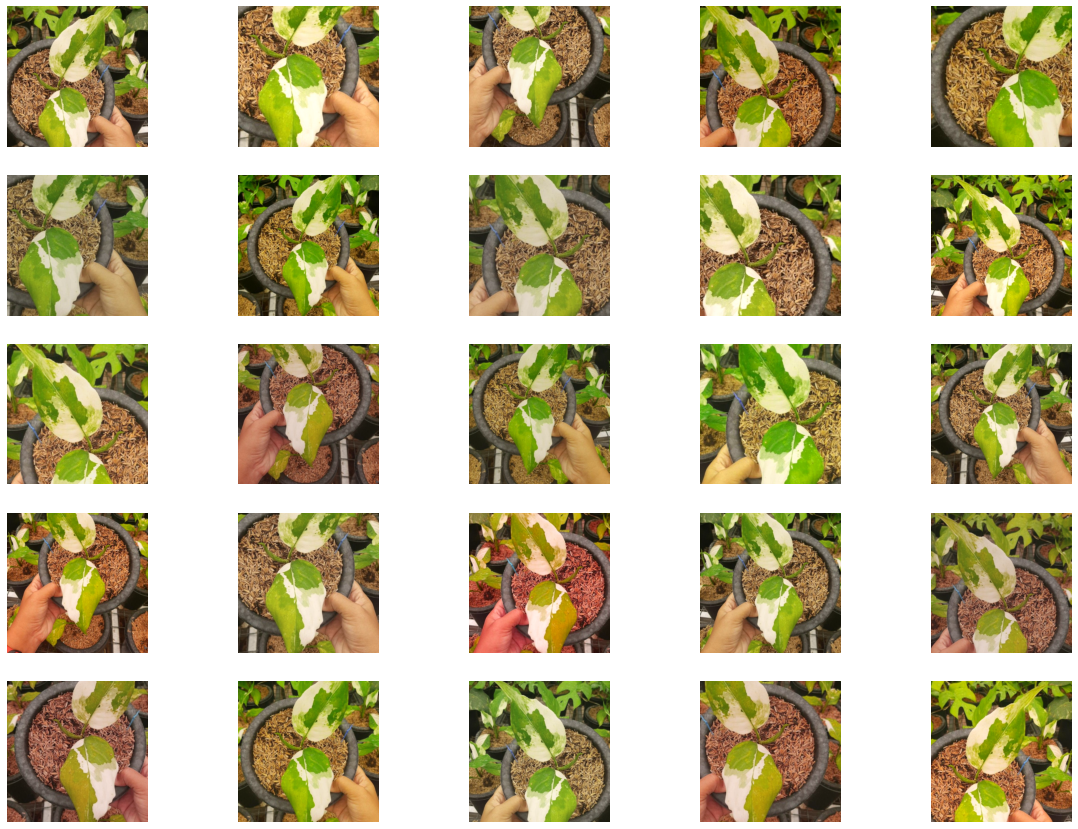

In [ ]:
# fig = plt.figure(figsize=(20, 15))
# for i in range(25):
#     img, _ = ds_preview[1]
#     plt.subplot(5, 5, i + 1)
#     plt.imshow(torch.permute(img, [1, 2, 0]).numpy())
#     plt.axis("off")

## Initialize Neural Network

In [7]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
model.fc = nn.Linear(model.fc.in_features, n_class)
# model

## Define Transform Procedure

In [9]:
# Transform for Training Dataset
transforms_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomResizedCrop(size=128, scale=(0.2, 1.0), ratio=(1.0, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.05),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

transforms_train

Compose(
    ToTensor()
    RandomResizedCrop(size=(128, 128), scale=(0.2, 1.0), ratio=(1.0, 1.0), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.8, 1.2], hue=[-0.05, 0.05])
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [10]:
# Transform for Validation Dataset
transforms_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(128),
        transforms.CenterCrop(128), # unify all image as square shape
        transforms.Normalize( # tied with pre-trained weights
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

transforms_val

Compose(
    ToTensor()
    Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(128, 128))
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [11]:
# Transform for Testing Dataset
transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

transforms_test

Compose(
    ToTensor()
    Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(128, 128))
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

## Initialize Dataset

In [12]:
# Training Dataset
ds_train = GreenFingerDataset(
    path_train,
    label_dict,
    oversample=True,
    transforms=transforms_train
)
print("ds_train", len(ds_train))

ds_train 23140


In [ ]:
# ds_train.df

,cat,image_path
0,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
1,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
2,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
3,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
4,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
...,...,...
10069,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...
10070,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...
10071,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...
10072,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...


In [ ]:
# ds_train.df_oversampled

,cat,image_path
0,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
1,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
2,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
3,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
4,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
...,...,...
23135,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...
23136,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...
23137,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...
23138,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...


In [13]:
# ds_train.df_oversampled['cat'].value_counts()

Aglaonema_commutatum      1157
Asplenium_nidus           1157
Tradescantia_zebrina      1157
Schefflera_arboricola     1157
Rhapis_excelsa            1157
Philodendron_gloriosum    1157
Peperomia_obtusifolia     1157
Peperomia_argyreia        1157
Pachira_aquatica          1157
Nephrolepis_cordifolia    1157
Monstera_deliciosa        1157
Maranta_leuconeura        1157
Hoya_carnosa              1157
Epipremnum_aureum         1157
Dypsis_lutescens          1157
Dracaena_trifasciata      1157
Dracaena_reflexa          1157
Chamaedorea_elegans       1157
Calathea_orbifolia        1157
Zamioculcas               1157
Name: cat, dtype: int64

In [14]:
# Validation Dataset
ds_val = GreenFingerDataset(
    path_val,
    label_dict,
    transforms=transforms_val
)
print("ds_val", len(ds_val))

ds_val 535


In [15]:
# Testing Dataset
ds_test = GreenFingerDataset(
    path_test,
    label_dict,
    transforms=transforms_test
)
print("ds_test", len(ds_test))

ds_test 491


## Training & Validation

In [16]:
# Initialize parameters
n_epoch = 10  # exploded in 2nd epoch
lr = 1e-4
batch_size = 128

# seen counter
seen = 0

# Path for saving the training log
user = 'CY'  # Tom, CY, Zephyr --> Change your name accordingly
log_path = os.path.join('/content/gdrive/MyDrive/Colab Notebooks/Training_Log', user)

In [17]:
# Initialize Data Loader
dl_train = DataLoader(
    ds_train,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True
)
dl_val = DataLoader(
    ds_val,
    shuffle=False,
    batch_size=batch_size,
    drop_last=False,
)

Save & Load Model

Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [18]:
# Initialize Loss Function
loss_fn = nn.CrossEntropyLoss()

# Initialize Optimizer
# Consider 'weight decay'?
optimizer = optim.Adam(model.parameters(), lr=lr)

device = torch.device("cuda:0")
model = model.to(device)

# Initialize Log
train_log = []

for i in range(n_epoch):
    model.train()
    # no need to switch the model back to model.train()?
    for (x, y) in tqdm(dl_train, desc='Training', position=0, leave=True):
        x = x.to(device)
        y = y.to(device)
        # what's the difference if we put optimizer.zero_grad() to later step?
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y[:, 0])
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            seen = seen + x.size(0)
            acc_train = torch.sum(torch.argmax(output, axis=1) == y[:, 0]) / np.sum(batch_size)
            print(f' | Seen {seen} | Loss {loss.item()} | Train Acc: {acc_train}')

    # Validate every 1 epochs
    if (i+1) % 1 == 0:
        model.eval()

        predictions = []

        with torch.no_grad():
            for (x, y) in tqdm(dl_val, desc='Validation', position=0, leave=True):
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                # To-Do: Optimize Prediction & Accuracy?
                predictions.append(output.cpu().numpy())
            # Compute Validation Accuracy
            preds = np.argmax(np.concatenate(predictions, axis=0), axis=1)
            y = np.concatenate([item[1].numpy() for item in ds_val])
            acc_val = np.sum(preds == y) / len(preds)
            print(f' | Seen: {seen} | Loss: {loss.item()} | Val Acc: {acc_val}')
            # Append Training Log
            train_log.append(
                      dict(
                          ePoch = i+1,
                          seen = seen,
                          loss_train = loss.item(),
                          acc_train = acc_train.item(),
                          acc_val = acc_val.item()
                      )
                  )
        torch.save({
          'epoch': i+1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss.item()
        },
          os.path.join(
              # Select your path from above
              log_path, f'epoch_{i+1}_{datetime.now()}.pt'
          )
        )

Training:   1%|          | 1/180 [00:48<2:24:38, 48.48s/it]

 | Seen 128 | Loss 3.0377211570739746 | Train Acc: 0.0859375


Training:   1%|          | 2/180 [01:25<2:04:19, 41.91s/it]

 | Seen 256 | Loss 2.9654321670532227 | Train Acc: 0.0703125


Training:   2%|▏         | 3/180 [02:03<1:58:22, 40.13s/it]

 | Seen 384 | Loss 2.801590919494629 | Train Acc: 0.171875


Training:   2%|▏         | 4/180 [02:39<1:52:38, 38.40s/it]

 | Seen 512 | Loss 2.6907172203063965 | Train Acc: 0.28125


Training:   3%|▎         | 5/180 [03:15<1:49:10, 37.43s/it]

 | Seen 640 | Loss 2.6163172721862793 | Train Acc: 0.328125


Training:   3%|▎         | 6/180 [03:51<1:47:51, 37.19s/it]

 | Seen 768 | Loss 2.539156198501587 | Train Acc: 0.3515625


Training:   4%|▍         | 7/180 [04:27<1:45:19, 36.53s/it]

 | Seen 896 | Loss 2.3786802291870117 | Train Acc: 0.4375


Training:   4%|▍         | 8/180 [05:03<1:44:58, 36.62s/it]

 | Seen 1024 | Loss 2.2913248538970947 | Train Acc: 0.4609375


Training:   5%|▌         | 9/180 [05:35<1:39:59, 35.08s/it]

 | Seen 1152 | Loss 2.1836495399475098 | Train Acc: 0.46875


Training:   6%|▌         | 10/180 [06:08<1:37:16, 34.33s/it]

 | Seen 1280 | Loss 2.107491970062256 | Train Acc: 0.53125


Training:   6%|▌         | 11/180 [06:40<1:35:11, 33.80s/it]

 | Seen 1408 | Loss 2.0268988609313965 | Train Acc: 0.4765625


Training:   7%|▋         | 12/180 [07:14<1:34:27, 33.74s/it]

 | Seen 1536 | Loss 1.9463094472885132 | Train Acc: 0.53125


Training:   7%|▋         | 13/180 [07:46<1:32:23, 33.20s/it]

 | Seen 1664 | Loss 1.9625413417816162 | Train Acc: 0.515625


Training:   8%|▊         | 14/180 [08:19<1:31:55, 33.22s/it]

 | Seen 1792 | Loss 1.8204306364059448 | Train Acc: 0.6015625


Training:   8%|▊         | 15/180 [08:50<1:29:12, 32.44s/it]

 | Seen 1920 | Loss 1.8187553882598877 | Train Acc: 0.5390625


Training:   9%|▉         | 16/180 [09:22<1:28:43, 32.46s/it]

 | Seen 2048 | Loss 1.697440266609192 | Train Acc: 0.5703125


Training:   9%|▉         | 17/180 [09:55<1:28:23, 32.54s/it]

 | Seen 2176 | Loss 1.5478659868240356 | Train Acc: 0.6171875


Training:  10%|█         | 18/180 [10:25<1:25:29, 31.66s/it]

 | Seen 2304 | Loss 1.4972532987594604 | Train Acc: 0.6640625


Training:  11%|█         | 19/180 [10:55<1:24:04, 31.33s/it]

 | Seen 2432 | Loss 1.5091156959533691 | Train Acc: 0.6015625


Training:  11%|█         | 20/180 [11:23<1:20:53, 30.34s/it]

 | Seen 2560 | Loss 1.4631534814834595 | Train Acc: 0.6484375


Training:  12%|█▏        | 21/180 [11:55<1:21:20, 30.70s/it]

 | Seen 2688 | Loss 1.4982048273086548 | Train Acc: 0.59375


Training:  12%|█▏        | 22/180 [12:23<1:18:38, 29.86s/it]

 | Seen 2816 | Loss 1.4449114799499512 | Train Acc: 0.5859375


Training:  13%|█▎        | 23/180 [12:54<1:18:54, 30.15s/it]

 | Seen 2944 | Loss 1.3126381635665894 | Train Acc: 0.6640625


Training:  13%|█▎        | 24/180 [13:21<1:16:24, 29.39s/it]

 | Seen 3072 | Loss 1.2099061012268066 | Train Acc: 0.6953125


Training:  14%|█▍        | 25/180 [13:51<1:15:56, 29.40s/it]

 | Seen 3200 | Loss 1.1003601551055908 | Train Acc: 0.7421875


Training:  14%|█▍        | 26/180 [14:19<1:14:19, 28.95s/it]

 | Seen 3328 | Loss 1.2645723819732666 | Train Acc: 0.6328125


Training:  15%|█▌        | 27/180 [14:42<1:09:43, 27.35s/it]

 | Seen 3456 | Loss 1.0698416233062744 | Train Acc: 0.6796875


Training:  16%|█▌        | 28/180 [15:07<1:07:44, 26.74s/it]

 | Seen 3584 | Loss 1.0087171792984009 | Train Acc: 0.734375


Training:  16%|█▌        | 29/180 [15:33<1:06:09, 26.29s/it]

 | Seen 3712 | Loss 1.1062841415405273 | Train Acc: 0.65625


Training:  17%|█▋        | 30/180 [15:59<1:05:37, 26.25s/it]

 | Seen 3840 | Loss 1.1119627952575684 | Train Acc: 0.6875


Training:  17%|█▋        | 31/180 [16:24<1:04:25, 25.95s/it]

 | Seen 3968 | Loss 0.9245786070823669 | Train Acc: 0.7421875


Training:  18%|█▊        | 32/180 [16:49<1:02:56, 25.52s/it]

 | Seen 4096 | Loss 0.8095852732658386 | Train Acc: 0.7734375


Training:  18%|█▊        | 33/180 [17:14<1:02:23, 25.46s/it]

 | Seen 4224 | Loss 1.0387988090515137 | Train Acc: 0.7109375


Training:  19%|█▉        | 34/180 [17:37<1:00:04, 24.69s/it]

 | Seen 4352 | Loss 0.8561177253723145 | Train Acc: 0.8046875


Training:  19%|█▉        | 35/180 [18:02<1:00:13, 24.92s/it]

 | Seen 4480 | Loss 0.9020362496376038 | Train Acc: 0.75


Training:  20%|██        | 36/180 [18:30<1:02:01, 25.84s/it]

 | Seen 4608 | Loss 0.8613994717597961 | Train Acc: 0.7734375


Training:  21%|██        | 37/180 [18:53<59:32, 24.98s/it]  

 | Seen 4736 | Loss 0.8109999895095825 | Train Acc: 0.78125


Training:  21%|██        | 38/180 [19:17<58:28, 24.70s/it]

 | Seen 4864 | Loss 0.742926299571991 | Train Acc: 0.765625


Training:  22%|██▏       | 39/180 [19:41<57:05, 24.29s/it]

 | Seen 4992 | Loss 0.863180935382843 | Train Acc: 0.75


Training:  22%|██▏       | 40/180 [20:04<56:06, 24.05s/it]

 | Seen 5120 | Loss 0.8411831259727478 | Train Acc: 0.703125


Training:  23%|██▎       | 41/180 [20:28<55:39, 24.03s/it]

 | Seen 5248 | Loss 0.9116780757904053 | Train Acc: 0.734375


Training:  23%|██▎       | 42/180 [20:51<54:26, 23.67s/it]

 | Seen 5376 | Loss 0.9069594144821167 | Train Acc: 0.7421875


Training:  24%|██▍       | 43/180 [21:13<52:43, 23.09s/it]

 | Seen 5504 | Loss 0.7183203101158142 | Train Acc: 0.7734375


Training:  24%|██▍       | 44/180 [21:32<49:54, 22.02s/it]

 | Seen 5632 | Loss 0.6292262673377991 | Train Acc: 0.8046875


Training:  25%|██▌       | 45/180 [21:56<50:53, 22.62s/it]

 | Seen 5760 | Loss 0.820389449596405 | Train Acc: 0.75


Training:  26%|██▌       | 46/180 [22:19<50:48, 22.75s/it]

 | Seen 5888 | Loss 0.7111393809318542 | Train Acc: 0.765625


Training:  26%|██▌       | 47/180 [22:40<49:21, 22.27s/it]

 | Seen 6016 | Loss 0.7628296613693237 | Train Acc: 0.796875


Training:  27%|██▋       | 48/180 [23:03<49:02, 22.29s/it]

 | Seen 6144 | Loss 0.6590261459350586 | Train Acc: 0.8203125


Training:  27%|██▋       | 49/180 [23:22<46:33, 21.32s/it]

 | Seen 6272 | Loss 0.5757629871368408 | Train Acc: 0.875


Training:  28%|██▊       | 50/180 [23:44<46:42, 21.56s/it]

 | Seen 6400 | Loss 0.6588852405548096 | Train Acc: 0.84375


Training:  28%|██▊       | 51/180 [24:07<47:18, 22.01s/it]

 | Seen 6528 | Loss 0.547521710395813 | Train Acc: 0.8671875


Training:  29%|██▉       | 52/180 [24:27<45:47, 21.47s/it]

 | Seen 6656 | Loss 0.5550459623336792 | Train Acc: 0.8515625


Training:  29%|██▉       | 53/180 [24:51<47:11, 22.29s/it]

 | Seen 6784 | Loss 0.7407678961753845 | Train Acc: 0.78125


Training:  30%|███       | 54/180 [25:12<45:57, 21.88s/it]

 | Seen 6912 | Loss 0.6442985534667969 | Train Acc: 0.8125


Training:  31%|███       | 55/180 [25:31<43:53, 21.07s/it]

 | Seen 7040 | Loss 0.5255255699157715 | Train Acc: 0.8515625


Training:  31%|███       | 56/180 [25:49<41:26, 20.05s/it]

 | Seen 7168 | Loss 0.5850445032119751 | Train Acc: 0.8203125


Training:  32%|███▏      | 57/180 [26:08<40:20, 19.68s/it]

 | Seen 7296 | Loss 0.8009119033813477 | Train Acc: 0.7421875


Training:  32%|███▏      | 58/180 [26:27<39:34, 19.46s/it]

 | Seen 7424 | Loss 0.6509411931037903 | Train Acc: 0.7890625


Training:  33%|███▎      | 59/180 [26:48<40:09, 19.91s/it]

 | Seen 7552 | Loss 0.5976800918579102 | Train Acc: 0.828125


Training:  33%|███▎      | 60/180 [27:07<39:16, 19.64s/it]

 | Seen 7680 | Loss 0.5605708360671997 | Train Acc: 0.8125


Training:  34%|███▍      | 61/180 [27:23<36:57, 18.63s/it]

 | Seen 7808 | Loss 0.6055282354354858 | Train Acc: 0.84375


Training:  34%|███▍      | 62/180 [27:41<36:10, 18.39s/it]

 | Seen 7936 | Loss 0.5119439959526062 | Train Acc: 0.875


Training:  35%|███▌      | 63/180 [28:02<37:13, 19.09s/it]

 | Seen 8064 | Loss 0.6410946846008301 | Train Acc: 0.8203125


Training:  36%|███▌      | 64/180 [28:18<35:33, 18.39s/it]

 | Seen 8192 | Loss 0.5870167016983032 | Train Acc: 0.8125


Training:  36%|███▌      | 65/180 [28:37<35:26, 18.49s/it]

 | Seen 8320 | Loss 0.6819051504135132 | Train Acc: 0.796875


Training:  37%|███▋      | 66/180 [28:57<35:50, 18.86s/it]

 | Seen 8448 | Loss 0.7349351644515991 | Train Acc: 0.78125


Training:  37%|███▋      | 67/180 [29:14<34:28, 18.31s/it]

 | Seen 8576 | Loss 0.534062385559082 | Train Acc: 0.8515625


Training:  38%|███▊      | 68/180 [29:33<34:21, 18.41s/it]

 | Seen 8704 | Loss 0.664200484752655 | Train Acc: 0.8203125


Training:  38%|███▊      | 69/180 [29:49<33:11, 17.94s/it]

 | Seen 8832 | Loss 0.4095253348350525 | Train Acc: 0.890625


Training:  39%|███▉      | 70/180 [30:06<31:53, 17.40s/it]

 | Seen 8960 | Loss 0.44742336869239807 | Train Acc: 0.875


Training:  39%|███▉      | 71/180 [30:19<29:18, 16.13s/it]

 | Seen 9088 | Loss 0.37959185242652893 | Train Acc: 0.9140625


Training:  40%|████      | 72/180 [30:37<30:08, 16.74s/it]

 | Seen 9216 | Loss 0.6143739819526672 | Train Acc: 0.828125


Training:  41%|████      | 73/180 [30:58<31:56, 17.91s/it]

 | Seen 9344 | Loss 0.6133399605751038 | Train Acc: 0.7890625


Training:  41%|████      | 74/180 [31:12<29:38, 16.78s/it]

 | Seen 9472 | Loss 0.5221770405769348 | Train Acc: 0.828125


Training:  42%|████▏     | 75/180 [31:29<29:45, 17.00s/it]

 | Seen 9600 | Loss 0.518164873123169 | Train Acc: 0.8671875


Training:  42%|████▏     | 76/180 [31:47<29:48, 17.19s/it]

 | Seen 9728 | Loss 0.6460861563682556 | Train Acc: 0.796875


Training:  43%|████▎     | 77/180 [32:03<29:10, 16.99s/it]

 | Seen 9856 | Loss 0.4301163852214813 | Train Acc: 0.8671875


Training:  43%|████▎     | 78/180 [32:20<28:55, 17.02s/it]

 | Seen 9984 | Loss 0.4977712631225586 | Train Acc: 0.84375


Training:  44%|████▍     | 79/180 [32:38<28:40, 17.03s/it]

 | Seen 10112 | Loss 0.4521373212337494 | Train Acc: 0.8515625


Training:  44%|████▍     | 80/180 [32:52<27:18, 16.39s/it]

 | Seen 10240 | Loss 0.6420902609825134 | Train Acc: 0.84375


Training:  45%|████▌     | 81/180 [33:09<26:55, 16.32s/it]

 | Seen 10368 | Loss 0.6659990549087524 | Train Acc: 0.7890625


Training:  46%|████▌     | 82/180 [33:24<26:15, 16.07s/it]

 | Seen 10496 | Loss 0.4154222905635834 | Train Acc: 0.8828125


Training:  46%|████▌     | 83/180 [33:38<24:51, 15.37s/it]

 | Seen 10624 | Loss 0.3687439560890198 | Train Acc: 0.890625


Training:  47%|████▋     | 84/180 [33:55<25:26, 15.90s/it]

 | Seen 10752 | Loss 0.4689834713935852 | Train Acc: 0.84375


Training:  47%|████▋     | 85/180 [34:08<24:03, 15.20s/it]

 | Seen 10880 | Loss 0.4422687888145447 | Train Acc: 0.84375


Training:  48%|████▊     | 86/180 [34:23<23:23, 14.93s/it]

 | Seen 11008 | Loss 0.46897169947624207 | Train Acc: 0.890625


Training:  48%|████▊     | 87/180 [34:40<24:06, 15.56s/it]

 | Seen 11136 | Loss 0.4888092577457428 | Train Acc: 0.84375


Training:  49%|████▉     | 88/180 [34:53<22:37, 14.76s/it]

 | Seen 11264 | Loss 0.3771781623363495 | Train Acc: 0.90625


Training:  49%|████▉     | 89/180 [35:06<21:42, 14.31s/it]

 | Seen 11392 | Loss 0.5662575364112854 | Train Acc: 0.828125


Training:  50%|█████     | 90/180 [35:21<21:57, 14.64s/it]

 | Seen 11520 | Loss 0.4620474874973297 | Train Acc: 0.859375


Training:  51%|█████     | 91/180 [35:35<21:10, 14.27s/it]

 | Seen 11648 | Loss 0.5324684977531433 | Train Acc: 0.828125


Training:  51%|█████     | 92/180 [35:50<21:20, 14.55s/it]

 | Seen 11776 | Loss 0.4358712434768677 | Train Acc: 0.875


Training:  52%|█████▏    | 93/180 [36:07<22:11, 15.31s/it]

 | Seen 11904 | Loss 0.4070761501789093 | Train Acc: 0.859375


Training:  52%|█████▏    | 94/180 [36:21<21:24, 14.94s/it]

 | Seen 12032 | Loss 0.5750411152839661 | Train Acc: 0.8203125


Training:  53%|█████▎    | 95/180 [36:36<21:10, 14.95s/it]

 | Seen 12160 | Loss 0.4043848514556885 | Train Acc: 0.8671875


Training:  53%|█████▎    | 96/180 [36:51<20:58, 14.99s/it]

 | Seen 12288 | Loss 0.5014583468437195 | Train Acc: 0.8515625


Training:  54%|█████▍    | 97/180 [37:04<19:57, 14.42s/it]

 | Seen 12416 | Loss 0.47732412815093994 | Train Acc: 0.875


Training:  54%|█████▍    | 98/180 [37:17<18:59, 13.90s/it]

 | Seen 12544 | Loss 0.44800880551338196 | Train Acc: 0.8359375


Training:  55%|█████▌    | 99/180 [37:30<18:29, 13.70s/it]

 | Seen 12672 | Loss 0.3636783957481384 | Train Acc: 0.8984375


Training:  56%|█████▌    | 100/180 [37:44<18:17, 13.72s/it]

 | Seen 12800 | Loss 0.44931164383888245 | Train Acc: 0.8359375


Training:  56%|█████▌    | 101/180 [37:57<17:57, 13.64s/it]

 | Seen 12928 | Loss 0.42816898226737976 | Train Acc: 0.875


Training:  57%|█████▋    | 102/180 [38:09<16:56, 13.03s/it]

 | Seen 13056 | Loss 0.5344087481498718 | Train Acc: 0.8515625


Training:  57%|█████▋    | 103/180 [38:23<17:05, 13.32s/it]

 | Seen 13184 | Loss 0.425678014755249 | Train Acc: 0.8828125


Training:  58%|█████▊    | 104/180 [38:35<16:22, 12.93s/it]

 | Seen 13312 | Loss 0.43219253420829773 | Train Acc: 0.890625


Training:  58%|█████▊    | 105/180 [38:47<15:50, 12.67s/it]

 | Seen 13440 | Loss 0.4288857877254486 | Train Acc: 0.8671875


Training:  59%|█████▉    | 106/180 [38:59<15:28, 12.55s/it]

 | Seen 13568 | Loss 0.48449116945266724 | Train Acc: 0.8671875


Training:  59%|█████▉    | 107/180 [39:12<15:21, 12.63s/it]

 | Seen 13696 | Loss 0.3903339207172394 | Train Acc: 0.859375


Training:  60%|██████    | 108/180 [39:26<15:41, 13.08s/it]

 | Seen 13824 | Loss 0.47016236186027527 | Train Acc: 0.875


Training:  61%|██████    | 109/180 [39:40<15:38, 13.21s/it]

 | Seen 13952 | Loss 0.40405386686325073 | Train Acc: 0.8828125


Training:  61%|██████    | 110/180 [39:53<15:17, 13.11s/it]

 | Seen 14080 | Loss 0.4065495431423187 | Train Acc: 0.875


Training:  62%|██████▏   | 111/180 [40:08<15:41, 13.65s/it]

 | Seen 14208 | Loss 0.46701985597610474 | Train Acc: 0.8515625


Training:  62%|██████▏   | 112/180 [40:20<15:05, 13.32s/it]

 | Seen 14336 | Loss 0.5058660507202148 | Train Acc: 0.859375


Training:  63%|██████▎   | 113/180 [40:34<15:01, 13.46s/it]

 | Seen 14464 | Loss 0.4262371063232422 | Train Acc: 0.8828125


Training:  63%|██████▎   | 114/180 [40:44<13:37, 12.39s/it]

 | Seen 14592 | Loss 0.5085297226905823 | Train Acc: 0.828125


Training:  64%|██████▍   | 115/180 [40:57<13:36, 12.56s/it]

 | Seen 14720 | Loss 0.3100343346595764 | Train Acc: 0.9140625


Training:  64%|██████▍   | 116/180 [41:08<12:48, 12.00s/it]

 | Seen 14848 | Loss 0.5766232013702393 | Train Acc: 0.796875


Training:  65%|██████▌   | 117/180 [41:21<12:59, 12.38s/it]

 | Seen 14976 | Loss 0.5242623686790466 | Train Acc: 0.8046875


Training:  66%|██████▌   | 118/180 [41:32<12:29, 12.09s/it]

 | Seen 15104 | Loss 0.38782602548599243 | Train Acc: 0.875


Training:  66%|██████▌   | 119/180 [41:43<11:50, 11.65s/it]

 | Seen 15232 | Loss 0.2939904034137726 | Train Acc: 0.921875


Training:  67%|██████▋   | 120/180 [41:56<12:03, 12.05s/it]

 | Seen 15360 | Loss 0.27404874563217163 | Train Acc: 0.9453125


Training:  67%|██████▋   | 121/180 [42:07<11:43, 11.93s/it]

 | Seen 15488 | Loss 0.4770032465457916 | Train Acc: 0.8828125


Training:  68%|██████▊   | 122/180 [42:18<11:14, 11.63s/it]

 | Seen 15616 | Loss 0.42575252056121826 | Train Acc: 0.8671875


Training:  68%|██████▊   | 123/180 [42:31<11:15, 11.85s/it]

 | Seen 15744 | Loss 0.3943096101284027 | Train Acc: 0.859375


Training:  69%|██████▉   | 124/180 [42:43<11:02, 11.83s/it]

 | Seen 15872 | Loss 0.29689544439315796 | Train Acc: 0.921875


Training:  69%|██████▉   | 125/180 [42:52<10:17, 11.22s/it]

 | Seen 16000 | Loss 0.3462824523448944 | Train Acc: 0.8984375


Training:  70%|███████   | 126/180 [43:03<10:01, 11.14s/it]

 | Seen 16128 | Loss 0.3169189691543579 | Train Acc: 0.90625


Training:  71%|███████   | 127/180 [43:13<09:25, 10.67s/it]

 | Seen 16256 | Loss 0.3770391047000885 | Train Acc: 0.8671875


Training:  71%|███████   | 128/180 [43:25<09:43, 11.23s/it]

 | Seen 16384 | Loss 0.31012341380119324 | Train Acc: 0.8984375


Training:  72%|███████▏  | 129/180 [43:35<09:03, 10.66s/it]

 | Seen 16512 | Loss 0.4068450629711151 | Train Acc: 0.8671875


Training:  72%|███████▏  | 130/180 [43:45<08:44, 10.49s/it]

 | Seen 16640 | Loss 0.39264383912086487 | Train Acc: 0.8671875


Training:  73%|███████▎  | 131/180 [43:53<08:04,  9.88s/it]

 | Seen 16768 | Loss 0.3942609131336212 | Train Acc: 0.890625


Training:  73%|███████▎  | 132/180 [44:03<07:55,  9.91s/it]

 | Seen 16896 | Loss 0.38454073667526245 | Train Acc: 0.9140625


Training:  74%|███████▍  | 133/180 [44:14<07:53, 10.07s/it]

 | Seen 17024 | Loss 0.4150765836238861 | Train Acc: 0.8671875


Training:  74%|███████▍  | 134/180 [44:24<07:44, 10.11s/it]

 | Seen 17152 | Loss 0.3547062277793884 | Train Acc: 0.8984375


Training:  75%|███████▌  | 135/180 [44:36<07:56, 10.60s/it]

 | Seen 17280 | Loss 0.2873882055282593 | Train Acc: 0.9296875


Training:  76%|███████▌  | 136/180 [44:43<07:07,  9.72s/it]

 | Seen 17408 | Loss 0.37309199571609497 | Train Acc: 0.890625


Training:  76%|███████▌  | 137/180 [44:55<07:20, 10.25s/it]

 | Seen 17536 | Loss 0.4788329601287842 | Train Acc: 0.8515625


Training:  77%|███████▋  | 138/180 [45:05<07:03, 10.08s/it]

 | Seen 17664 | Loss 0.364577978849411 | Train Acc: 0.875


Training:  77%|███████▋  | 139/180 [45:14<06:42,  9.82s/it]

 | Seen 17792 | Loss 0.40837791562080383 | Train Acc: 0.8828125


Training:  78%|███████▊  | 140/180 [45:23<06:32,  9.80s/it]

 | Seen 17920 | Loss 0.4105936586856842 | Train Acc: 0.8828125


Training:  78%|███████▊  | 141/180 [45:32<06:10,  9.51s/it]

 | Seen 18048 | Loss 0.41299837827682495 | Train Acc: 0.890625


Training:  79%|███████▉  | 142/180 [45:43<06:15,  9.89s/it]

 | Seen 18176 | Loss 0.3967136740684509 | Train Acc: 0.8984375


Training:  79%|███████▉  | 143/180 [45:52<05:58,  9.69s/it]

 | Seen 18304 | Loss 0.42472508549690247 | Train Acc: 0.859375


Training:  80%|████████  | 144/180 [46:02<05:52,  9.79s/it]

 | Seen 18432 | Loss 0.3939738869667053 | Train Acc: 0.8828125


Training:  81%|████████  | 145/180 [46:10<05:16,  9.04s/it]

 | Seen 18560 | Loss 0.4785923659801483 | Train Acc: 0.84375


Training:  81%|████████  | 146/180 [46:19<05:12,  9.21s/it]

 | Seen 18688 | Loss 0.42090171575546265 | Train Acc: 0.8828125


Training:  82%|████████▏ | 147/180 [46:29<05:08,  9.35s/it]

 | Seen 18816 | Loss 0.4246993660926819 | Train Acc: 0.8515625


Training:  82%|████████▏ | 148/180 [46:40<05:13,  9.80s/it]

 | Seen 18944 | Loss 0.45938315987586975 | Train Acc: 0.8828125


Training:  83%|████████▎ | 149/180 [46:48<04:48,  9.32s/it]

 | Seen 19072 | Loss 0.39372149109840393 | Train Acc: 0.90625


Training:  83%|████████▎ | 150/180 [47:00<05:01, 10.05s/it]

 | Seen 19200 | Loss 0.3538626730442047 | Train Acc: 0.875


Training:  84%|████████▍ | 151/180 [47:09<04:41,  9.71s/it]

 | Seen 19328 | Loss 0.4023717939853668 | Train Acc: 0.8671875


Training:  84%|████████▍ | 152/180 [47:17<04:19,  9.25s/it]

 | Seen 19456 | Loss 0.39050111174583435 | Train Acc: 0.890625


Training:  85%|████████▌ | 153/180 [47:28<04:25,  9.82s/it]

 | Seen 19584 | Loss 0.25915953516960144 | Train Acc: 0.921875


Training:  86%|████████▌ | 154/180 [47:36<04:04,  9.42s/it]

 | Seen 19712 | Loss 0.5274991393089294 | Train Acc: 0.8359375


Training:  86%|████████▌ | 155/180 [47:45<03:50,  9.24s/it]

 | Seen 19840 | Loss 0.3588182330131531 | Train Acc: 0.90625


Training:  87%|████████▋ | 156/180 [47:56<03:49,  9.55s/it]

 | Seen 19968 | Loss 0.4299250841140747 | Train Acc: 0.8671875


Training:  87%|████████▋ | 157/180 [48:04<03:34,  9.33s/it]

 | Seen 20096 | Loss 0.38385361433029175 | Train Acc: 0.890625


Training:  88%|████████▊ | 158/180 [48:14<03:27,  9.45s/it]

 | Seen 20224 | Loss 0.4366318881511688 | Train Acc: 0.8671875


Training:  88%|████████▊ | 159/180 [48:23<03:17,  9.41s/it]

 | Seen 20352 | Loss 0.5785884261131287 | Train Acc: 0.8125


Training:  89%|████████▉ | 160/180 [48:34<03:12,  9.63s/it]

 | Seen 20480 | Loss 0.40595653653144836 | Train Acc: 0.8828125


Training:  89%|████████▉ | 161/180 [48:43<03:00,  9.51s/it]

 | Seen 20608 | Loss 0.19201745092868805 | Train Acc: 0.953125


Training:  90%|█████████ | 162/180 [48:52<02:47,  9.31s/it]

 | Seen 20736 | Loss 0.43468061089515686 | Train Acc: 0.875


Training:  91%|█████████ | 163/180 [49:00<02:34,  9.12s/it]

 | Seen 20864 | Loss 0.42037346959114075 | Train Acc: 0.859375


Training:  91%|█████████ | 164/180 [49:09<02:24,  9.04s/it]

 | Seen 20992 | Loss 0.37657466530799866 | Train Acc: 0.8984375


Training:  92%|█████████▏| 165/180 [49:18<02:15,  9.03s/it]

 | Seen 21120 | Loss 0.3217175304889679 | Train Acc: 0.8984375


Training:  92%|█████████▏| 166/180 [49:26<01:59,  8.56s/it]

 | Seen 21248 | Loss 0.40967491269111633 | Train Acc: 0.921875


Training:  93%|█████████▎| 167/180 [49:34<01:49,  8.42s/it]

 | Seen 21376 | Loss 0.3296141028404236 | Train Acc: 0.890625


Training:  93%|█████████▎| 168/180 [49:43<01:44,  8.70s/it]

 | Seen 21504 | Loss 0.23373153805732727 | Train Acc: 0.9140625


Training:  94%|█████████▍| 169/180 [49:51<01:34,  8.60s/it]

 | Seen 21632 | Loss 0.21209439635276794 | Train Acc: 0.9296875


Training:  94%|█████████▍| 170/180 [50:01<01:30,  9.03s/it]

 | Seen 21760 | Loss 0.3872660994529724 | Train Acc: 0.8515625


Training:  95%|█████████▌| 171/180 [50:09<01:16,  8.50s/it]

 | Seen 21888 | Loss 0.24923057854175568 | Train Acc: 0.921875


Training:  96%|█████████▌| 172/180 [50:17<01:07,  8.41s/it]

 | Seen 22016 | Loss 0.2116294801235199 | Train Acc: 0.9453125


Training:  96%|█████████▌| 173/180 [50:24<00:56,  8.04s/it]

 | Seen 22144 | Loss 0.39849233627319336 | Train Acc: 0.8828125


Training:  97%|█████████▋| 174/180 [50:31<00:46,  7.74s/it]

 | Seen 22272 | Loss 0.37210506200790405 | Train Acc: 0.9140625


Training:  97%|█████████▋| 175/180 [50:40<00:40,  8.02s/it]

 | Seen 22400 | Loss 0.4586481750011444 | Train Acc: 0.8359375


Training:  98%|█████████▊| 176/180 [50:47<00:31,  7.88s/it]

 | Seen 22528 | Loss 0.21193812787532806 | Train Acc: 0.9375


Training:  98%|█████████▊| 177/180 [50:55<00:23,  7.90s/it]

 | Seen 22656 | Loss 0.4402807056903839 | Train Acc: 0.875


Training:  99%|█████████▉| 178/180 [51:04<00:16,  8.08s/it]

 | Seen 22784 | Loss 0.3111690282821655 | Train Acc: 0.921875


Training:  99%|█████████▉| 179/180 [51:09<00:07,  7.35s/it]

 | Seen 22912 | Loss 0.3350751996040344 | Train Acc: 0.90625


Training: 100%|██████████| 180/180 [51:17<00:00, 17.09s/it]


 | Seen 23040 | Loss 0.29394620656967163 | Train Acc: 0.9140625


Validation: 100%|██████████| 5/5 [02:41<00:00, 32.20s/it]


 | Seen: 23040 | Loss: 0.29394620656967163 | Val Acc: 0.8803738317757009


Training:   1%|          | 1/180 [00:03<11:42,  3.92s/it]

 | Seen 23168 | Loss 0.20680630207061768 | Train Acc: 0.9375


Training:   1%|          | 2/180 [00:07<11:30,  3.88s/it]

 | Seen 23296 | Loss 0.3336382508277893 | Train Acc: 0.890625


Training:   2%|▏         | 3/180 [00:12<12:26,  4.22s/it]

 | Seen 23424 | Loss 0.3039293885231018 | Train Acc: 0.8984375


Training:   2%|▏         | 4/180 [00:16<12:00,  4.09s/it]

 | Seen 23552 | Loss 0.28925830125808716 | Train Acc: 0.9140625


Training:   3%|▎         | 5/180 [00:20<11:44,  4.03s/it]

 | Seen 23680 | Loss 0.2967087924480438 | Train Acc: 0.90625


Training:   3%|▎         | 6/180 [00:24<11:30,  3.97s/it]

 | Seen 23808 | Loss 0.18373025953769684 | Train Acc: 0.9453125


Training:   4%|▍         | 7/180 [00:28<12:21,  4.29s/it]

 | Seen 23936 | Loss 0.4421011507511139 | Train Acc: 0.875


Training:   4%|▍         | 8/180 [00:32<11:59,  4.18s/it]

 | Seen 24064 | Loss 0.3053993284702301 | Train Acc: 0.875


Training:   5%|▌         | 9/180 [00:36<11:39,  4.09s/it]

 | Seen 24192 | Loss 0.2883618474006653 | Train Acc: 0.9140625


Training:   6%|▌         | 10/180 [00:41<11:39,  4.11s/it]

 | Seen 24320 | Loss 0.1979222446680069 | Train Acc: 0.9296875


Training:   6%|▌         | 11/180 [00:45<11:36,  4.12s/it]

 | Seen 24448 | Loss 0.31631407141685486 | Train Acc: 0.9140625


Training:   7%|▋         | 12/180 [00:49<11:31,  4.12s/it]

 | Seen 24576 | Loss 0.296682745218277 | Train Acc: 0.8984375


Training:   7%|▋         | 13/180 [00:53<11:15,  4.05s/it]

 | Seen 24704 | Loss 0.28566375374794006 | Train Acc: 0.921875


Training:   8%|▊         | 14/180 [00:57<11:02,  3.99s/it]

 | Seen 24832 | Loss 0.26828715205192566 | Train Acc: 0.90625


Training:   8%|▊         | 15/180 [01:00<10:52,  3.95s/it]

 | Seen 24960 | Loss 0.308885395526886 | Train Acc: 0.9140625


Training:   9%|▉         | 16/180 [01:04<10:46,  3.94s/it]

 | Seen 25088 | Loss 0.2504878640174866 | Train Acc: 0.9140625


Training:   9%|▉         | 17/180 [01:08<10:34,  3.89s/it]

 | Seen 25216 | Loss 0.2722648084163666 | Train Acc: 0.9140625


Training:  10%|█         | 18/180 [01:12<10:29,  3.89s/it]

 | Seen 25344 | Loss 0.15140916407108307 | Train Acc: 0.9609375


Training:  11%|█         | 19/180 [01:16<10:24,  3.88s/it]

 | Seen 25472 | Loss 0.33307820558547974 | Train Acc: 0.9140625


Training:  11%|█         | 20/180 [01:20<10:20,  3.88s/it]

 | Seen 25600 | Loss 0.2000172734260559 | Train Acc: 0.9375


Training:  12%|█▏        | 21/180 [01:23<10:13,  3.86s/it]

 | Seen 25728 | Loss 0.2107885330915451 | Train Acc: 0.9296875


Training:  12%|█▏        | 22/180 [01:27<10:12,  3.88s/it]

 | Seen 25856 | Loss 0.2705311179161072 | Train Acc: 0.9140625


Training:  13%|█▎        | 23/180 [01:31<10:07,  3.87s/it]

 | Seen 25984 | Loss 0.35411524772644043 | Train Acc: 0.90625


Training:  13%|█▎        | 24/180 [01:35<10:06,  3.89s/it]

 | Seen 26112 | Loss 0.21129284799098969 | Train Acc: 0.9453125


Training:  14%|█▍        | 25/180 [01:39<10:00,  3.87s/it]

 | Seen 26240 | Loss 0.23266178369522095 | Train Acc: 0.9140625


Training:  14%|█▍        | 26/180 [01:43<09:54,  3.86s/it]

 | Seen 26368 | Loss 0.23514029383659363 | Train Acc: 0.9296875


Training:  15%|█▌        | 27/180 [01:47<10:03,  3.95s/it]

 | Seen 26496 | Loss 0.20131929218769073 | Train Acc: 0.953125


Training:  16%|█▌        | 28/180 [01:51<09:57,  3.93s/it]

 | Seen 26624 | Loss 0.3326914310455322 | Train Acc: 0.9140625


Training:  16%|█▌        | 29/180 [01:55<09:51,  3.91s/it]

 | Seen 26752 | Loss 0.2478717416524887 | Train Acc: 0.9296875


Training:  17%|█▋        | 30/180 [01:59<09:45,  3.91s/it]

 | Seen 26880 | Loss 0.2713184058666229 | Train Acc: 0.921875


Training:  17%|█▋        | 31/180 [02:03<09:39,  3.89s/it]

 | Seen 27008 | Loss 0.3217615783214569 | Train Acc: 0.9296875


Training:  18%|█▊        | 32/180 [02:06<09:35,  3.89s/it]

 | Seen 27136 | Loss 0.2990046441555023 | Train Acc: 0.9140625


Training:  18%|█▊        | 33/180 [02:11<09:46,  3.99s/it]

 | Seen 27264 | Loss 0.30092424154281616 | Train Acc: 0.9140625


Training:  19%|█▉        | 34/180 [02:15<09:38,  3.97s/it]

 | Seen 27392 | Loss 0.21265509724617004 | Train Acc: 0.9453125


Training:  19%|█▉        | 35/180 [02:18<09:33,  3.95s/it]

 | Seen 27520 | Loss 0.20278115570545197 | Train Acc: 0.96875


Training:  20%|██        | 36/180 [02:22<09:28,  3.95s/it]

 | Seen 27648 | Loss 0.24206526577472687 | Train Acc: 0.9453125


Training:  21%|██        | 37/180 [02:27<09:43,  4.08s/it]

 | Seen 27776 | Loss 0.20457753539085388 | Train Acc: 0.9296875


Training:  21%|██        | 38/180 [02:31<09:54,  4.18s/it]

 | Seen 27904 | Loss 0.30757611989974976 | Train Acc: 0.8984375


Training:  22%|██▏       | 39/180 [02:35<09:36,  4.09s/it]

 | Seen 28032 | Loss 0.26110899448394775 | Train Acc: 0.9140625


Training:  22%|██▏       | 40/180 [02:39<09:22,  4.02s/it]

 | Seen 28160 | Loss 0.34138253331184387 | Train Acc: 0.9140625


Training:  23%|██▎       | 41/180 [02:43<09:12,  3.97s/it]

 | Seen 28288 | Loss 0.2948460876941681 | Train Acc: 0.90625


Training:  23%|██▎       | 42/180 [02:47<09:03,  3.94s/it]

 | Seen 28416 | Loss 0.30616891384124756 | Train Acc: 0.9140625


Training:  24%|██▍       | 43/180 [02:51<08:57,  3.93s/it]

 | Seen 28544 | Loss 0.2600516378879547 | Train Acc: 0.90625


Training:  24%|██▍       | 44/180 [02:54<08:50,  3.90s/it]

 | Seen 28672 | Loss 0.1984143704175949 | Train Acc: 0.9453125


Training:  25%|██▌       | 45/180 [02:58<08:44,  3.89s/it]

 | Seen 28800 | Loss 0.19832077622413635 | Train Acc: 0.953125


Training:  26%|██▌       | 46/180 [03:02<08:40,  3.89s/it]

 | Seen 28928 | Loss 0.26439276337623596 | Train Acc: 0.9140625


Training:  26%|██▌       | 47/180 [03:06<08:36,  3.88s/it]

 | Seen 29056 | Loss 0.21556229889392853 | Train Acc: 0.9140625


Training:  27%|██▋       | 48/180 [03:10<08:31,  3.88s/it]

 | Seen 29184 | Loss 0.2709790766239166 | Train Acc: 0.9375


Training:  27%|██▋       | 49/180 [03:14<08:29,  3.89s/it]

 | Seen 29312 | Loss 0.2563670873641968 | Train Acc: 0.921875


Training:  28%|██▊       | 50/180 [03:18<08:36,  3.98s/it]

 | Seen 29440 | Loss 0.17955847084522247 | Train Acc: 0.9375


Training:  28%|██▊       | 51/180 [03:22<08:27,  3.93s/it]

 | Seen 29568 | Loss 0.1977345496416092 | Train Acc: 0.953125


Training:  29%|██▉       | 52/180 [03:26<08:19,  3.91s/it]

 | Seen 29696 | Loss 0.12540504336357117 | Train Acc: 0.9375


Training:  29%|██▉       | 53/180 [03:30<08:14,  3.90s/it]

 | Seen 29824 | Loss 0.3073257803916931 | Train Acc: 0.90625


Training:  30%|███       | 54/180 [03:33<08:08,  3.87s/it]

 | Seen 29952 | Loss 0.32707470655441284 | Train Acc: 0.90625


Training:  31%|███       | 55/180 [03:37<08:05,  3.88s/it]

 | Seen 30080 | Loss 0.21987557411193848 | Train Acc: 0.9140625


Training:  31%|███       | 56/180 [03:41<08:01,  3.89s/it]

 | Seen 30208 | Loss 0.3721989095211029 | Train Acc: 0.8828125


Training:  32%|███▏      | 57/180 [03:45<07:57,  3.88s/it]

 | Seen 30336 | Loss 0.20926399528980255 | Train Acc: 0.9296875


Training:  32%|███▏      | 58/180 [03:49<07:50,  3.86s/it]

 | Seen 30464 | Loss 0.4059373140335083 | Train Acc: 0.8984375


Training:  33%|███▎      | 59/180 [03:53<07:47,  3.86s/it]

 | Seen 30592 | Loss 0.2464354783296585 | Train Acc: 0.9140625


Training:  33%|███▎      | 60/180 [03:57<07:43,  3.87s/it]

 | Seen 30720 | Loss 0.3433956503868103 | Train Acc: 0.9140625


Training:  34%|███▍      | 61/180 [04:00<07:37,  3.84s/it]

 | Seen 30848 | Loss 0.2175961136817932 | Train Acc: 0.9375


Training:  34%|███▍      | 62/180 [04:04<07:33,  3.84s/it]

 | Seen 30976 | Loss 0.1289767622947693 | Train Acc: 0.96875


Training:  35%|███▌      | 63/180 [04:08<07:27,  3.82s/it]

 | Seen 31104 | Loss 0.2958119511604309 | Train Acc: 0.90625


Training:  36%|███▌      | 64/180 [04:12<07:28,  3.87s/it]

 | Seen 31232 | Loss 0.3657429814338684 | Train Acc: 0.90625


Training:  36%|███▌      | 65/180 [04:16<07:23,  3.86s/it]

 | Seen 31360 | Loss 0.24818500876426697 | Train Acc: 0.9296875


Training:  37%|███▋      | 66/180 [04:20<07:19,  3.85s/it]

 | Seen 31488 | Loss 0.2231370061635971 | Train Acc: 0.9296875


Training:  37%|███▋      | 67/180 [04:23<07:13,  3.83s/it]

 | Seen 31616 | Loss 0.20440833270549774 | Train Acc: 0.9296875


Training:  38%|███▊      | 68/180 [04:28<07:22,  3.95s/it]

 | Seen 31744 | Loss 0.3136877417564392 | Train Acc: 0.890625


Training:  38%|███▊      | 69/180 [04:32<07:43,  4.18s/it]

 | Seen 31872 | Loss 0.2230657935142517 | Train Acc: 0.921875


Training:  39%|███▉      | 70/180 [04:36<07:30,  4.09s/it]

 | Seen 32000 | Loss 0.16651564836502075 | Train Acc: 0.9375


Training:  39%|███▉      | 71/180 [04:40<07:19,  4.04s/it]

 | Seen 32128 | Loss 0.25335654616355896 | Train Acc: 0.9375


Training:  40%|████      | 72/180 [04:44<07:10,  3.99s/it]

 | Seen 32256 | Loss 0.17015744745731354 | Train Acc: 0.9296875


Training:  41%|████      | 73/180 [04:48<06:59,  3.92s/it]

 | Seen 32384 | Loss 0.245003342628479 | Train Acc: 0.9140625


Training:  41%|████      | 74/180 [04:52<06:53,  3.90s/it]

 | Seen 32512 | Loss 0.24695897102355957 | Train Acc: 0.9453125


Training:  42%|████▏     | 75/180 [04:55<06:43,  3.84s/it]

 | Seen 32640 | Loss 0.3068103492259979 | Train Acc: 0.9375


Training:  42%|████▏     | 76/180 [04:59<06:42,  3.87s/it]

 | Seen 32768 | Loss 0.3289724290370941 | Train Acc: 0.8984375


Training:  43%|████▎     | 77/180 [05:03<06:40,  3.89s/it]

 | Seen 32896 | Loss 0.2429835945367813 | Train Acc: 0.953125


Training:  43%|████▎     | 78/180 [05:07<06:36,  3.89s/it]

 | Seen 33024 | Loss 0.2157246172428131 | Train Acc: 0.9609375


Training:  44%|████▍     | 79/180 [05:11<06:31,  3.87s/it]

 | Seen 33152 | Loss 0.32613199949264526 | Train Acc: 0.9140625


Training:  44%|████▍     | 80/180 [05:15<06:25,  3.86s/it]

 | Seen 33280 | Loss 0.26153358817100525 | Train Acc: 0.8984375


Training:  45%|████▌     | 81/180 [05:19<06:21,  3.85s/it]

 | Seen 33408 | Loss 0.4000173509120941 | Train Acc: 0.875


Training:  46%|████▌     | 82/180 [05:22<06:17,  3.85s/it]

 | Seen 33536 | Loss 0.3810129463672638 | Train Acc: 0.875


Training:  46%|████▌     | 83/180 [05:26<06:12,  3.84s/it]

 | Seen 33664 | Loss 0.37506163120269775 | Train Acc: 0.890625


Training:  47%|████▋     | 84/180 [05:30<06:06,  3.82s/it]

 | Seen 33792 | Loss 0.3364754915237427 | Train Acc: 0.90625


Training:  47%|████▋     | 85/180 [05:34<06:04,  3.84s/it]

 | Seen 33920 | Loss 0.3329242467880249 | Train Acc: 0.90625


Training:  48%|████▊     | 86/180 [05:38<06:03,  3.87s/it]

 | Seen 34048 | Loss 0.2169189453125 | Train Acc: 0.9375


Training:  48%|████▊     | 87/180 [05:42<06:00,  3.87s/it]

 | Seen 34176 | Loss 0.36689555644989014 | Train Acc: 0.859375


Training:  49%|████▉     | 88/180 [05:46<05:55,  3.87s/it]

 | Seen 34304 | Loss 0.19128893315792084 | Train Acc: 0.9375


Training:  49%|████▉     | 89/180 [05:49<05:51,  3.86s/it]

 | Seen 34432 | Loss 0.1435149908065796 | Train Acc: 0.953125


Training:  50%|█████     | 90/180 [05:53<05:44,  3.83s/it]

 | Seen 34560 | Loss 0.3070903420448303 | Train Acc: 0.921875


Training:  51%|█████     | 91/180 [05:57<05:41,  3.84s/it]

 | Seen 34688 | Loss 0.22224867343902588 | Train Acc: 0.9375


Training:  51%|█████     | 92/180 [06:01<05:37,  3.83s/it]

 | Seen 34816 | Loss 0.2817491590976715 | Train Acc: 0.890625


Training:  52%|█████▏    | 93/180 [06:05<05:34,  3.84s/it]

 | Seen 34944 | Loss 0.2908695936203003 | Train Acc: 0.8984375


Training:  52%|█████▏    | 94/180 [06:09<05:30,  3.85s/it]

 | Seen 35072 | Loss 0.23407860100269318 | Train Acc: 0.921875


Training:  53%|█████▎    | 95/180 [06:13<05:29,  3.88s/it]

 | Seen 35200 | Loss 0.2431892305612564 | Train Acc: 0.90625


Training:  53%|█████▎    | 96/180 [06:16<05:24,  3.86s/it]

 | Seen 35328 | Loss 0.32376420497894287 | Train Acc: 0.890625


Training:  54%|█████▍    | 97/180 [06:20<05:19,  3.85s/it]

 | Seen 35456 | Loss 0.19934992492198944 | Train Acc: 0.9375


Training:  54%|█████▍    | 98/180 [06:24<05:13,  3.82s/it]

 | Seen 35584 | Loss 0.22736793756484985 | Train Acc: 0.9453125


Training:  55%|█████▌    | 99/180 [06:28<05:09,  3.82s/it]

 | Seen 35712 | Loss 0.293544739484787 | Train Acc: 0.8984375


Training:  56%|█████▌    | 100/180 [06:33<05:33,  4.16s/it]

 | Seen 35840 | Loss 0.24417118728160858 | Train Acc: 0.9296875


Training:  56%|█████▌    | 101/180 [06:37<05:20,  4.06s/it]

 | Seen 35968 | Loss 0.352355420589447 | Train Acc: 0.9296875


Training:  57%|█████▋    | 102/180 [06:40<05:09,  3.96s/it]

 | Seen 36096 | Loss 0.3406628966331482 | Train Acc: 0.890625


Training:  57%|█████▋    | 103/180 [06:44<04:59,  3.89s/it]

 | Seen 36224 | Loss 0.21719461679458618 | Train Acc: 0.921875


Training:  58%|█████▊    | 104/180 [06:48<04:54,  3.87s/it]

 | Seen 36352 | Loss 0.19100087881088257 | Train Acc: 0.9375


Training:  58%|█████▊    | 105/180 [06:52<04:54,  3.93s/it]

 | Seen 36480 | Loss 0.20458991825580597 | Train Acc: 0.921875


Training:  59%|█████▉    | 106/180 [06:56<04:52,  3.95s/it]

 | Seen 36608 | Loss 0.2192053496837616 | Train Acc: 0.9296875


Training:  59%|█████▉    | 107/180 [07:00<04:44,  3.90s/it]

 | Seen 36736 | Loss 0.29413902759552 | Train Acc: 0.9296875


Training:  60%|██████    | 108/180 [07:03<04:38,  3.86s/it]

 | Seen 36864 | Loss 0.23879797756671906 | Train Acc: 0.9140625


Training:  61%|██████    | 109/180 [07:07<04:33,  3.86s/it]

 | Seen 36992 | Loss 0.14370198547840118 | Train Acc: 0.953125


Training:  61%|██████    | 110/180 [07:11<04:32,  3.89s/it]

 | Seen 37120 | Loss 0.29419854283332825 | Train Acc: 0.890625


Training:  62%|██████▏   | 111/180 [07:15<04:28,  3.89s/it]

 | Seen 37248 | Loss 0.21476957201957703 | Train Acc: 0.953125


Training:  62%|██████▏   | 112/180 [07:19<04:23,  3.87s/it]

 | Seen 37376 | Loss 0.2452327311038971 | Train Acc: 0.9140625


Training:  63%|██████▎   | 113/180 [07:23<04:19,  3.87s/it]

 | Seen 37504 | Loss 0.23789286613464355 | Train Acc: 0.9453125


Training:  63%|██████▎   | 114/180 [07:27<04:13,  3.84s/it]

 | Seen 37632 | Loss 0.21084772050380707 | Train Acc: 0.9375


Training:  64%|██████▍   | 115/180 [07:30<04:08,  3.82s/it]

 | Seen 37760 | Loss 0.21488985419273376 | Train Acc: 0.9140625


Training:  64%|██████▍   | 116/180 [07:34<04:04,  3.82s/it]

 | Seen 37888 | Loss 0.27011993527412415 | Train Acc: 0.921875


Training:  65%|██████▌   | 117/180 [07:38<04:00,  3.82s/it]

 | Seen 38016 | Loss 0.24756579101085663 | Train Acc: 0.9140625


Training:  66%|██████▌   | 118/180 [07:42<03:55,  3.79s/it]

 | Seen 38144 | Loss 0.24368368089199066 | Train Acc: 0.921875


Training:  66%|██████▌   | 119/180 [07:45<03:50,  3.77s/it]

 | Seen 38272 | Loss 0.21136347949504852 | Train Acc: 0.9375


Training:  67%|██████▋   | 120/180 [07:49<03:47,  3.79s/it]

 | Seen 38400 | Loss 0.15931986272335052 | Train Acc: 0.953125


Training:  67%|██████▋   | 121/180 [07:53<03:41,  3.76s/it]

 | Seen 38528 | Loss 0.16748173534870148 | Train Acc: 0.9609375


Training:  68%|██████▊   | 122/180 [07:57<03:38,  3.77s/it]

 | Seen 38656 | Loss 0.3353818356990814 | Train Acc: 0.90625


Training:  68%|██████▊   | 123/180 [08:01<03:37,  3.82s/it]

 | Seen 38784 | Loss 0.21420449018478394 | Train Acc: 0.9296875


Training:  69%|██████▉   | 124/180 [08:05<03:35,  3.84s/it]

 | Seen 38912 | Loss 0.1540561467409134 | Train Acc: 0.9453125


Training:  69%|██████▉   | 125/180 [08:08<03:31,  3.84s/it]

 | Seen 39040 | Loss 0.11677049100399017 | Train Acc: 0.953125


Training:  70%|███████   | 126/180 [08:12<03:26,  3.82s/it]

 | Seen 39168 | Loss 0.28337281942367554 | Train Acc: 0.921875


Training:  71%|███████   | 127/180 [08:16<03:22,  3.82s/it]

 | Seen 39296 | Loss 0.1904110461473465 | Train Acc: 0.9453125


Training:  71%|███████   | 128/180 [08:20<03:24,  3.94s/it]

 | Seen 39424 | Loss 0.2878490686416626 | Train Acc: 0.9140625


Training:  72%|███████▏  | 129/180 [08:24<03:19,  3.92s/it]

 | Seen 39552 | Loss 0.17304417490959167 | Train Acc: 0.9375


Training:  72%|███████▏  | 130/180 [08:28<03:14,  3.89s/it]

 | Seen 39680 | Loss 0.19504407048225403 | Train Acc: 0.9453125


Training:  73%|███████▎  | 131/180 [08:33<03:29,  4.27s/it]

 | Seen 39808 | Loss 0.1850629597902298 | Train Acc: 0.9375


Training:  73%|███████▎  | 132/180 [08:37<03:19,  4.16s/it]

 | Seen 39936 | Loss 0.16098852455615997 | Train Acc: 0.953125


Training:  74%|███████▍  | 133/180 [08:41<03:10,  4.06s/it]

 | Seen 40064 | Loss 0.29376038908958435 | Train Acc: 0.921875


Training:  74%|███████▍  | 134/180 [08:45<03:07,  4.08s/it]

 | Seen 40192 | Loss 0.25381380319595337 | Train Acc: 0.921875


Training:  75%|███████▌  | 135/180 [08:49<03:02,  4.06s/it]

 | Seen 40320 | Loss 0.18011586368083954 | Train Acc: 0.9609375


Training:  76%|███████▌  | 136/180 [08:53<02:56,  4.02s/it]

 | Seen 40448 | Loss 0.11111069470643997 | Train Acc: 0.984375


Training:  76%|███████▌  | 137/180 [08:57<02:52,  4.02s/it]

 | Seen 40576 | Loss 0.2223951518535614 | Train Acc: 0.9375


Training:  77%|███████▋  | 138/180 [09:01<02:47,  3.98s/it]

 | Seen 40704 | Loss 0.18839816749095917 | Train Acc: 0.9453125


Training:  77%|███████▋  | 139/180 [09:05<02:40,  3.91s/it]

 | Seen 40832 | Loss 0.20986288785934448 | Train Acc: 0.9296875


Training:  78%|███████▊  | 140/180 [09:08<02:34,  3.87s/it]

 | Seen 40960 | Loss 0.19937680661678314 | Train Acc: 0.9375


Training:  78%|███████▊  | 141/180 [09:12<02:31,  3.87s/it]

 | Seen 41088 | Loss 0.14721743762493134 | Train Acc: 0.9375


Training:  79%|███████▉  | 142/180 [09:16<02:26,  3.85s/it]

 | Seen 41216 | Loss 0.2201436311006546 | Train Acc: 0.953125


Training:  79%|███████▉  | 143/180 [09:20<02:21,  3.82s/it]

 | Seen 41344 | Loss 0.2967609763145447 | Train Acc: 0.9140625


Training:  80%|████████  | 144/180 [09:24<02:16,  3.80s/it]

 | Seen 41472 | Loss 0.30984240770339966 | Train Acc: 0.90625


Training:  81%|████████  | 145/180 [09:27<02:13,  3.83s/it]

 | Seen 41600 | Loss 0.17372773587703705 | Train Acc: 0.9453125


Training:  81%|████████  | 146/180 [09:31<02:10,  3.83s/it]

 | Seen 41728 | Loss 0.145681232213974 | Train Acc: 0.953125


Training:  82%|████████▏ | 147/180 [09:35<02:05,  3.80s/it]

 | Seen 41856 | Loss 0.22958265244960785 | Train Acc: 0.9140625


Training:  82%|████████▏ | 148/180 [09:39<02:02,  3.82s/it]

 | Seen 41984 | Loss 0.32599711418151855 | Train Acc: 0.8984375


Training:  83%|████████▎ | 149/180 [09:43<02:00,  3.89s/it]

 | Seen 42112 | Loss 0.21489746868610382 | Train Acc: 0.9296875


Training:  83%|████████▎ | 150/180 [09:47<01:57,  3.92s/it]

 | Seen 42240 | Loss 0.21503768861293793 | Train Acc: 0.921875


Training:  84%|████████▍ | 151/180 [09:51<01:53,  3.90s/it]

 | Seen 42368 | Loss 0.18240399658679962 | Train Acc: 0.9453125


Training:  84%|████████▍ | 152/180 [09:54<01:46,  3.82s/it]

 | Seen 42496 | Loss 0.15546874701976776 | Train Acc: 0.9609375


Training:  85%|████████▌ | 153/180 [09:58<01:43,  3.84s/it]

 | Seen 42624 | Loss 0.1675693392753601 | Train Acc: 0.9609375


Training:  86%|████████▌ | 154/180 [10:02<01:39,  3.81s/it]

 | Seen 42752 | Loss 0.24342259764671326 | Train Acc: 0.9140625


Training:  86%|████████▌ | 155/180 [10:06<01:35,  3.82s/it]

 | Seen 42880 | Loss 0.15838727355003357 | Train Acc: 0.9609375


Training:  87%|████████▋ | 156/180 [10:10<01:31,  3.80s/it]

 | Seen 43008 | Loss 0.22885194420814514 | Train Acc: 0.921875


Training:  87%|████████▋ | 157/180 [10:13<01:27,  3.81s/it]

 | Seen 43136 | Loss 0.15516500174999237 | Train Acc: 0.9453125


Training:  88%|████████▊ | 158/180 [10:17<01:23,  3.79s/it]

 | Seen 43264 | Loss 0.29505980014801025 | Train Acc: 0.890625


Training:  88%|████████▊ | 159/180 [10:21<01:19,  3.78s/it]

 | Seen 43392 | Loss 0.12637902796268463 | Train Acc: 0.96875


Training:  89%|████████▉ | 160/180 [10:25<01:15,  3.76s/it]

 | Seen 43520 | Loss 0.1723196655511856 | Train Acc: 0.953125


Training:  89%|████████▉ | 161/180 [10:28<01:11,  3.78s/it]

 | Seen 43648 | Loss 0.22299785912036896 | Train Acc: 0.921875


Training:  90%|█████████ | 162/180 [10:33<01:14,  4.13s/it]

 | Seen 43776 | Loss 0.20348092913627625 | Train Acc: 0.921875


Training:  91%|█████████ | 163/180 [10:37<01:08,  4.05s/it]

 | Seen 43904 | Loss 0.22353917360305786 | Train Acc: 0.9296875


Training:  91%|█████████ | 164/180 [10:41<01:03,  3.96s/it]

 | Seen 44032 | Loss 0.29755640029907227 | Train Acc: 0.8984375


Training:  92%|█████████▏| 165/180 [10:45<00:58,  3.91s/it]

 | Seen 44160 | Loss 0.24100081622600555 | Train Acc: 0.9296875


Training:  92%|█████████▏| 166/180 [10:49<00:54,  3.90s/it]

 | Seen 44288 | Loss 0.1643121838569641 | Train Acc: 0.9609375


Training:  93%|█████████▎| 167/180 [10:53<00:50,  3.88s/it]

 | Seen 44416 | Loss 0.1761874258518219 | Train Acc: 0.953125


Training:  93%|█████████▎| 168/180 [10:56<00:46,  3.87s/it]

 | Seen 44544 | Loss 0.35045912861824036 | Train Acc: 0.875


Training:  94%|█████████▍| 169/180 [11:00<00:42,  3.85s/it]

 | Seen 44672 | Loss 0.27425384521484375 | Train Acc: 0.90625


Training:  94%|█████████▍| 170/180 [11:04<00:38,  3.82s/it]

 | Seen 44800 | Loss 0.18637877702713013 | Train Acc: 0.9453125


Training:  95%|█████████▌| 171/180 [11:08<00:34,  3.80s/it]

 | Seen 44928 | Loss 0.2624846398830414 | Train Acc: 0.921875


Training:  96%|█████████▌| 172/180 [11:11<00:30,  3.79s/it]

 | Seen 45056 | Loss 0.31618326902389526 | Train Acc: 0.9140625


Training:  96%|█████████▌| 173/180 [11:15<00:26,  3.86s/it]

 | Seen 45184 | Loss 0.35997912287712097 | Train Acc: 0.8828125


Training:  97%|█████████▋| 174/180 [11:19<00:22,  3.82s/it]

 | Seen 45312 | Loss 0.32233306765556335 | Train Acc: 0.8984375


Training:  97%|█████████▋| 175/180 [11:23<00:19,  3.82s/it]

 | Seen 45440 | Loss 0.21596631407737732 | Train Acc: 0.921875


Training:  98%|█████████▊| 176/180 [11:27<00:15,  3.81s/it]

 | Seen 45568 | Loss 0.3330938220024109 | Train Acc: 0.8984375


Training:  98%|█████████▊| 177/180 [11:31<00:11,  3.79s/it]

 | Seen 45696 | Loss 0.15741637349128723 | Train Acc: 0.9609375


Training:  99%|█████████▉| 178/180 [11:34<00:07,  3.78s/it]

 | Seen 45824 | Loss 0.41132232546806335 | Train Acc: 0.859375


Training:  99%|█████████▉| 179/180 [11:38<00:03,  3.74s/it]

 | Seen 45952 | Loss 0.2567446231842041 | Train Acc: 0.921875


Training: 100%|██████████| 180/180 [11:42<00:00,  3.90s/it]


 | Seen 46080 | Loss 0.20441289246082306 | Train Acc: 0.921875


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


 | Seen: 46080 | Loss: 0.20441289246082306 | Val Acc: 0.8691588785046729


Training:   1%|          | 1/180 [00:03<11:21,  3.81s/it]

 | Seen 46208 | Loss 0.18983981013298035 | Train Acc: 0.9375


Training:   1%|          | 2/180 [00:07<11:13,  3.78s/it]

 | Seen 46336 | Loss 0.20457766950130463 | Train Acc: 0.9609375


Training:   2%|▏         | 3/180 [00:12<12:29,  4.23s/it]

 | Seen 46464 | Loss 0.1862950325012207 | Train Acc: 0.9453125


Training:   2%|▏         | 4/180 [00:16<11:50,  4.04s/it]

 | Seen 46592 | Loss 0.14651723206043243 | Train Acc: 0.9453125


Training:   3%|▎         | 5/180 [00:19<11:32,  3.96s/it]

 | Seen 46720 | Loss 0.2223379909992218 | Train Acc: 0.9140625


Training:   3%|▎         | 6/180 [00:23<11:21,  3.92s/it]

 | Seen 46848 | Loss 0.14379657804965973 | Train Acc: 0.9453125


Training:   4%|▍         | 7/180 [00:28<12:12,  4.23s/it]

 | Seen 46976 | Loss 0.1391974687576294 | Train Acc: 0.9609375


Training:   4%|▍         | 8/180 [00:32<11:42,  4.08s/it]

 | Seen 47104 | Loss 0.06146738678216934 | Train Acc: 0.9921875


Training:   5%|▌         | 9/180 [00:36<11:23,  4.00s/it]

 | Seen 47232 | Loss 0.1851997822523117 | Train Acc: 0.9375


Training:   6%|▌         | 10/180 [00:39<11:03,  3.90s/it]

 | Seen 47360 | Loss 0.18967348337173462 | Train Acc: 0.953125


Training:   6%|▌         | 11/180 [00:43<10:54,  3.87s/it]

 | Seen 47488 | Loss 0.18670454621315002 | Train Acc: 0.9453125


Training:   7%|▋         | 12/180 [00:47<10:41,  3.82s/it]

 | Seen 47616 | Loss 0.20719140768051147 | Train Acc: 0.9453125


Training:   7%|▋         | 13/180 [00:51<10:33,  3.79s/it]

 | Seen 47744 | Loss 0.19818717241287231 | Train Acc: 0.9375


Training:   8%|▊         | 14/180 [00:54<10:24,  3.76s/it]

 | Seen 47872 | Loss 0.2279057651758194 | Train Acc: 0.9296875


Training:   8%|▊         | 15/180 [00:58<10:21,  3.77s/it]

 | Seen 48000 | Loss 0.12106842547655106 | Train Acc: 0.9765625


Training:   9%|▉         | 16/180 [01:02<10:16,  3.76s/it]

 | Seen 48128 | Loss 0.10088174045085907 | Train Acc: 0.9609375


Training:   9%|▉         | 17/180 [01:06<10:13,  3.77s/it]

 | Seen 48256 | Loss 0.17627611756324768 | Train Acc: 0.953125


Training:  10%|█         | 18/180 [01:09<10:12,  3.78s/it]

 | Seen 48384 | Loss 0.13421198725700378 | Train Acc: 0.9375


Training:  11%|█         | 19/180 [01:13<10:06,  3.77s/it]

 | Seen 48512 | Loss 0.17083226144313812 | Train Acc: 0.9609375


Training:  11%|█         | 20/180 [01:17<10:02,  3.77s/it]

 | Seen 48640 | Loss 0.09693745523691177 | Train Acc: 0.9609375


Training:  12%|█▏        | 21/180 [01:21<09:57,  3.76s/it]

 | Seen 48768 | Loss 0.1871216893196106 | Train Acc: 0.9453125


Training:  12%|█▏        | 22/180 [01:24<09:52,  3.75s/it]

 | Seen 48896 | Loss 0.13516752421855927 | Train Acc: 0.9609375


Training:  13%|█▎        | 23/180 [01:28<09:48,  3.75s/it]

 | Seen 49024 | Loss 0.21982678771018982 | Train Acc: 0.953125


Training:  13%|█▎        | 24/180 [01:32<09:43,  3.74s/it]

 | Seen 49152 | Loss 0.14454546570777893 | Train Acc: 0.96875


Training:  14%|█▍        | 25/180 [01:36<09:41,  3.75s/it]

 | Seen 49280 | Loss 0.2113712579011917 | Train Acc: 0.9296875


Training:  14%|█▍        | 26/180 [01:39<09:33,  3.73s/it]

 | Seen 49408 | Loss 0.17731909453868866 | Train Acc: 0.9609375


Training:  15%|█▌        | 27/180 [01:43<09:30,  3.73s/it]

 | Seen 49536 | Loss 0.20521867275238037 | Train Acc: 0.921875


Training:  16%|█▌        | 28/180 [01:47<09:25,  3.72s/it]

 | Seen 49664 | Loss 0.22091011703014374 | Train Acc: 0.9375


Training:  16%|█▌        | 29/180 [01:51<09:23,  3.73s/it]

 | Seen 49792 | Loss 0.16218151152133942 | Train Acc: 0.953125


Training:  17%|█▋        | 30/180 [01:54<09:21,  3.74s/it]

 | Seen 49920 | Loss 0.13579881191253662 | Train Acc: 0.953125


Training:  17%|█▋        | 31/180 [01:58<09:16,  3.73s/it]

 | Seen 50048 | Loss 0.1886688768863678 | Train Acc: 0.921875


Training:  18%|█▊        | 32/180 [02:02<09:12,  3.74s/it]

 | Seen 50176 | Loss 0.1694514900445938 | Train Acc: 0.9296875


Training:  18%|█▊        | 33/180 [02:06<09:12,  3.76s/it]

 | Seen 50304 | Loss 0.11516027897596359 | Train Acc: 0.9765625


Training:  19%|█▉        | 34/180 [02:09<09:04,  3.73s/it]

 | Seen 50432 | Loss 0.09693139791488647 | Train Acc: 0.96875


Training:  19%|█▉        | 35/180 [02:13<09:01,  3.74s/it]

 | Seen 50560 | Loss 0.13909845054149628 | Train Acc: 0.9609375


Training:  20%|██        | 36/180 [02:17<08:58,  3.74s/it]

 | Seen 50688 | Loss 0.24523156881332397 | Train Acc: 0.9375


Training:  21%|██        | 37/180 [02:20<08:54,  3.74s/it]

 | Seen 50816 | Loss 0.26380252838134766 | Train Acc: 0.90625


Training:  21%|██        | 38/180 [02:25<09:05,  3.84s/it]

 | Seen 50944 | Loss 0.07267627120018005 | Train Acc: 0.9765625


Training:  22%|██▏       | 39/180 [02:29<09:31,  4.05s/it]

 | Seen 51072 | Loss 0.15426158905029297 | Train Acc: 0.9609375


Training:  22%|██▏       | 40/180 [02:33<09:13,  3.95s/it]

 | Seen 51200 | Loss 0.1896689534187317 | Train Acc: 0.9375


Training:  23%|██▎       | 41/180 [02:37<09:01,  3.90s/it]

 | Seen 51328 | Loss 0.113488107919693 | Train Acc: 0.96875


Training:  23%|██▎       | 42/180 [02:40<08:51,  3.85s/it]

 | Seen 51456 | Loss 0.21376067399978638 | Train Acc: 0.9453125


Training:  24%|██▍       | 43/180 [02:44<08:44,  3.83s/it]

 | Seen 51584 | Loss 0.09265992045402527 | Train Acc: 0.9609375


Training:  24%|██▍       | 44/180 [02:48<08:38,  3.81s/it]

 | Seen 51712 | Loss 0.127412348985672 | Train Acc: 0.953125


Training:  25%|██▌       | 45/180 [02:52<08:32,  3.80s/it]

 | Seen 51840 | Loss 0.1575523167848587 | Train Acc: 0.9609375


Training:  26%|██▌       | 46/180 [02:55<08:25,  3.77s/it]

 | Seen 51968 | Loss 0.24602524936199188 | Train Acc: 0.9296875


Training:  26%|██▌       | 47/180 [02:59<08:22,  3.78s/it]

 | Seen 52096 | Loss 0.08636794984340668 | Train Acc: 0.9765625


Training:  27%|██▋       | 48/180 [03:03<08:18,  3.77s/it]

 | Seen 52224 | Loss 0.14350248873233795 | Train Acc: 0.9375


Training:  27%|██▋       | 49/180 [03:07<08:16,  3.79s/it]

 | Seen 52352 | Loss 0.10589611530303955 | Train Acc: 0.9765625


Training:  28%|██▊       | 50/180 [03:10<08:12,  3.79s/it]

 | Seen 52480 | Loss 0.3710273206233978 | Train Acc: 0.890625


Training:  28%|██▊       | 51/180 [03:14<08:09,  3.79s/it]

 | Seen 52608 | Loss 0.1737702488899231 | Train Acc: 0.9375


Training:  29%|██▉       | 52/180 [03:18<08:04,  3.78s/it]

 | Seen 52736 | Loss 0.08504907041788101 | Train Acc: 0.9765625


Training:  29%|██▉       | 53/180 [03:22<08:01,  3.79s/it]

 | Seen 52864 | Loss 0.1990969032049179 | Train Acc: 0.921875


Training:  30%|███       | 54/180 [03:26<07:53,  3.76s/it]

 | Seen 52992 | Loss 0.17783081531524658 | Train Acc: 0.9375


Training:  31%|███       | 55/180 [03:29<07:49,  3.76s/it]

 | Seen 53120 | Loss 0.18776395916938782 | Train Acc: 0.9296875


Training:  31%|███       | 56/180 [03:33<07:48,  3.78s/it]

 | Seen 53248 | Loss 0.33566829562187195 | Train Acc: 0.8671875


Training:  32%|███▏      | 57/180 [03:37<07:44,  3.78s/it]

 | Seen 53376 | Loss 0.13936537504196167 | Train Acc: 0.953125


Training:  32%|███▏      | 58/180 [03:41<07:40,  3.78s/it]

 | Seen 53504 | Loss 0.17764951288700104 | Train Acc: 0.9453125


Training:  33%|███▎      | 59/180 [03:44<07:37,  3.78s/it]

 | Seen 53632 | Loss 0.18768316507339478 | Train Acc: 0.9375


Training:  33%|███▎      | 60/180 [03:48<07:37,  3.81s/it]

 | Seen 53760 | Loss 0.16953620314598083 | Train Acc: 0.9375


Training:  34%|███▍      | 61/180 [03:52<07:33,  3.81s/it]

 | Seen 53888 | Loss 0.1335660070180893 | Train Acc: 0.96875


Training:  34%|███▍      | 62/180 [03:56<07:29,  3.81s/it]

 | Seen 54016 | Loss 0.18161526322364807 | Train Acc: 0.9453125


Training:  35%|███▌      | 63/180 [04:00<07:26,  3.81s/it]

 | Seen 54144 | Loss 0.13389898836612701 | Train Acc: 0.96875


Training:  36%|███▌      | 64/180 [04:04<07:21,  3.80s/it]

 | Seen 54272 | Loss 0.17292384803295135 | Train Acc: 0.953125


Training:  36%|███▌      | 65/180 [04:07<07:14,  3.78s/it]

 | Seen 54400 | Loss 0.2047913372516632 | Train Acc: 0.953125


Training:  37%|███▋      | 66/180 [04:11<07:09,  3.77s/it]

 | Seen 54528 | Loss 0.20709103345870972 | Train Acc: 0.921875


Training:  37%|███▋      | 67/180 [04:15<07:03,  3.75s/it]

 | Seen 54656 | Loss 0.12982961535453796 | Train Acc: 0.953125


Training:  38%|███▊      | 68/180 [04:19<07:00,  3.76s/it]

 | Seen 54784 | Loss 0.19253112375736237 | Train Acc: 0.9453125


Training:  38%|███▊      | 69/180 [04:22<06:59,  3.78s/it]

 | Seen 54912 | Loss 0.1883787363767624 | Train Acc: 0.953125


Training:  39%|███▉      | 70/180 [04:27<07:09,  3.91s/it]

 | Seen 55040 | Loss 0.14140452444553375 | Train Acc: 0.953125


Training:  39%|███▉      | 71/180 [04:31<07:16,  4.01s/it]

 | Seen 55168 | Loss 0.06121393293142319 | Train Acc: 0.984375


Training:  40%|████      | 72/180 [04:34<07:02,  3.91s/it]

 | Seen 55296 | Loss 0.13190339505672455 | Train Acc: 0.96875


Training:  41%|████      | 73/180 [04:38<06:51,  3.84s/it]

 | Seen 55424 | Loss 0.17691196501255035 | Train Acc: 0.953125


Training:  41%|████      | 74/180 [04:42<06:45,  3.83s/it]

 | Seen 55552 | Loss 0.08734449744224548 | Train Acc: 0.953125


Training:  42%|████▏     | 75/180 [04:46<06:40,  3.81s/it]

 | Seen 55680 | Loss 0.12799637019634247 | Train Acc: 0.9609375


Training:  42%|████▏     | 76/180 [04:49<06:33,  3.79s/it]

 | Seen 55808 | Loss 0.1435827910900116 | Train Acc: 0.953125


Training:  43%|████▎     | 77/180 [04:53<06:30,  3.79s/it]

 | Seen 55936 | Loss 0.15748661756515503 | Train Acc: 0.9609375


Training:  43%|████▎     | 78/180 [04:57<06:26,  3.78s/it]

 | Seen 56064 | Loss 0.16674630343914032 | Train Acc: 0.953125


Training:  44%|████▍     | 79/180 [05:01<06:21,  3.78s/it]

 | Seen 56192 | Loss 0.21184873580932617 | Train Acc: 0.8828125


Training:  44%|████▍     | 80/180 [05:05<06:18,  3.79s/it]

 | Seen 56320 | Loss 0.23267552256584167 | Train Acc: 0.921875


Training:  45%|████▌     | 81/180 [05:08<06:14,  3.78s/it]

 | Seen 56448 | Loss 0.11510750651359558 | Train Acc: 0.96875


Training:  46%|████▌     | 82/180 [05:12<06:10,  3.78s/it]

 | Seen 56576 | Loss 0.1690010279417038 | Train Acc: 0.9609375


Training:  46%|████▌     | 83/180 [05:16<06:07,  3.79s/it]

 | Seen 56704 | Loss 0.23057574033737183 | Train Acc: 0.921875


Training:  47%|████▋     | 84/180 [05:20<06:03,  3.79s/it]

 | Seen 56832 | Loss 0.13057278096675873 | Train Acc: 0.96875


Training:  47%|████▋     | 85/180 [05:23<05:58,  3.77s/it]

 | Seen 56960 | Loss 0.1610240638256073 | Train Acc: 0.953125


Training:  48%|████▊     | 86/180 [05:27<05:53,  3.76s/it]

 | Seen 57088 | Loss 0.17095065116882324 | Train Acc: 0.96875


Training:  48%|████▊     | 87/180 [05:31<05:54,  3.82s/it]

 | Seen 57216 | Loss 0.15186360478401184 | Train Acc: 0.9609375


Training:  49%|████▉     | 88/180 [05:35<05:52,  3.83s/it]

 | Seen 57344 | Loss 0.16861002147197723 | Train Acc: 0.953125


Training:  49%|████▉     | 89/180 [05:39<05:46,  3.81s/it]

 | Seen 57472 | Loss 0.12192266434431076 | Train Acc: 0.9609375


Training:  50%|█████     | 90/180 [05:43<05:42,  3.81s/it]

 | Seen 57600 | Loss 0.21893176436424255 | Train Acc: 0.9296875


Training:  51%|█████     | 91/180 [05:46<05:38,  3.80s/it]

 | Seen 57728 | Loss 0.19980284571647644 | Train Acc: 0.9375


Training:  51%|█████     | 92/180 [05:50<05:31,  3.76s/it]

 | Seen 57856 | Loss 0.0743151530623436 | Train Acc: 0.96875


Training:  52%|█████▏    | 93/180 [05:54<05:27,  3.77s/it]

 | Seen 57984 | Loss 0.1812756359577179 | Train Acc: 0.9296875


Training:  52%|█████▏    | 94/180 [05:58<05:22,  3.75s/it]

 | Seen 58112 | Loss 0.0844675749540329 | Train Acc: 0.96875


Training:  53%|█████▎    | 95/180 [06:01<05:17,  3.74s/it]

 | Seen 58240 | Loss 0.20072439312934875 | Train Acc: 0.9453125


Training:  53%|█████▎    | 96/180 [06:05<05:14,  3.74s/it]

 | Seen 58368 | Loss 0.210354745388031 | Train Acc: 0.9375


Training:  54%|█████▍    | 97/180 [06:09<05:10,  3.74s/it]

 | Seen 58496 | Loss 0.21178673207759857 | Train Acc: 0.9375


Training:  54%|█████▍    | 98/180 [06:13<05:07,  3.75s/it]

 | Seen 58624 | Loss 0.15041351318359375 | Train Acc: 0.9609375


Training:  55%|█████▌    | 99/180 [06:16<05:04,  3.76s/it]

 | Seen 58752 | Loss 0.20421679317951202 | Train Acc: 0.9453125


Training:  56%|█████▌    | 100/180 [06:20<05:00,  3.75s/it]

 | Seen 58880 | Loss 0.15663842856884003 | Train Acc: 0.9609375


Training:  56%|█████▌    | 101/180 [06:24<04:56,  3.76s/it]

 | Seen 59008 | Loss 0.13085387647151947 | Train Acc: 0.9609375


Training:  57%|█████▋    | 102/180 [06:28<05:09,  3.96s/it]

 | Seen 59136 | Loss 0.2117196023464203 | Train Acc: 0.9296875


Training:  57%|█████▋    | 103/180 [06:33<05:13,  4.08s/it]

 | Seen 59264 | Loss 0.1426493376493454 | Train Acc: 0.96875


Training:  58%|█████▊    | 104/180 [06:36<05:01,  3.97s/it]

 | Seen 59392 | Loss 0.18067467212677002 | Train Acc: 0.953125


Training:  58%|█████▊    | 105/180 [06:40<04:53,  3.92s/it]

 | Seen 59520 | Loss 0.1776581108570099 | Train Acc: 0.953125


Training:  59%|█████▉    | 106/180 [06:44<04:45,  3.85s/it]

 | Seen 59648 | Loss 0.2498822808265686 | Train Acc: 0.9375


Training:  59%|█████▉    | 107/180 [06:48<04:38,  3.81s/it]

 | Seen 59776 | Loss 0.14714904129505157 | Train Acc: 0.9453125


Training:  60%|██████    | 108/180 [06:51<04:33,  3.80s/it]

 | Seen 59904 | Loss 0.25076407194137573 | Train Acc: 0.90625


Training:  61%|██████    | 109/180 [06:55<04:28,  3.78s/it]

 | Seen 60032 | Loss 0.17954957485198975 | Train Acc: 0.953125


Training:  61%|██████    | 110/180 [06:59<04:24,  3.78s/it]

 | Seen 60160 | Loss 0.15317140519618988 | Train Acc: 0.953125


Training:  62%|██████▏   | 111/180 [07:03<04:19,  3.76s/it]

 | Seen 60288 | Loss 0.20490936934947968 | Train Acc: 0.9375


Training:  62%|██████▏   | 112/180 [07:06<04:16,  3.78s/it]

 | Seen 60416 | Loss 0.16102875769138336 | Train Acc: 0.9765625


Training:  63%|██████▎   | 113/180 [07:10<04:12,  3.77s/it]

 | Seen 60544 | Loss 0.12079023569822311 | Train Acc: 0.9453125


Training:  63%|██████▎   | 114/180 [07:14<04:09,  3.78s/it]

 | Seen 60672 | Loss 0.1792965531349182 | Train Acc: 0.921875


Training:  64%|██████▍   | 115/180 [07:18<04:05,  3.78s/it]

 | Seen 60800 | Loss 0.147406205534935 | Train Acc: 0.953125


Training:  64%|██████▍   | 116/180 [07:21<04:00,  3.75s/it]

 | Seen 60928 | Loss 0.13830873370170593 | Train Acc: 0.9609375


Training:  65%|██████▌   | 117/180 [07:25<03:55,  3.75s/it]

 | Seen 61056 | Loss 0.14414863288402557 | Train Acc: 0.953125


Training:  66%|██████▌   | 118/180 [07:29<03:50,  3.72s/it]

 | Seen 61184 | Loss 0.1307094246149063 | Train Acc: 0.953125


Training:  66%|██████▌   | 119/180 [07:32<03:47,  3.73s/it]

 | Seen 61312 | Loss 0.1340988427400589 | Train Acc: 0.9609375


Training:  67%|██████▋   | 120/180 [07:36<03:43,  3.73s/it]

 | Seen 61440 | Loss 0.11850322037935257 | Train Acc: 0.9609375


Training:  67%|██████▋   | 121/180 [07:40<03:40,  3.74s/it]

 | Seen 61568 | Loss 0.19645220041275024 | Train Acc: 0.9375


Training:  68%|██████▊   | 122/180 [07:44<03:35,  3.72s/it]

 | Seen 61696 | Loss 0.15243178606033325 | Train Acc: 0.9375


Training:  68%|██████▊   | 123/180 [07:47<03:32,  3.72s/it]

 | Seen 61824 | Loss 0.19046923518180847 | Train Acc: 0.953125


Training:  69%|██████▉   | 124/180 [07:51<03:28,  3.73s/it]

 | Seen 61952 | Loss 0.13570982217788696 | Train Acc: 0.9453125


Training:  69%|██████▉   | 125/180 [07:55<03:25,  3.74s/it]

 | Seen 62080 | Loss 0.15190882980823517 | Train Acc: 0.9375


Training:  70%|███████   | 126/180 [07:59<03:22,  3.74s/it]

 | Seen 62208 | Loss 0.1497488021850586 | Train Acc: 0.9765625


Training:  71%|███████   | 127/180 [08:02<03:17,  3.72s/it]

 | Seen 62336 | Loss 0.11945383995771408 | Train Acc: 0.96875


Training:  71%|███████   | 128/180 [08:06<03:13,  3.73s/it]

 | Seen 62464 | Loss 0.21251551806926727 | Train Acc: 0.953125


Training:  72%|███████▏  | 129/180 [08:10<03:10,  3.74s/it]

 | Seen 62592 | Loss 0.15113922953605652 | Train Acc: 0.953125


Training:  72%|███████▏  | 130/180 [08:14<03:08,  3.78s/it]

 | Seen 62720 | Loss 0.1677539348602295 | Train Acc: 0.9375


Training:  73%|███████▎  | 131/180 [08:17<03:02,  3.73s/it]

 | Seen 62848 | Loss 0.09920605272054672 | Train Acc: 0.96875


Training:  73%|███████▎  | 132/180 [08:21<02:59,  3.74s/it]

 | Seen 62976 | Loss 0.21614471077919006 | Train Acc: 0.9296875


Training:  74%|███████▍  | 133/180 [08:25<02:54,  3.72s/it]

 | Seen 63104 | Loss 0.14377442002296448 | Train Acc: 0.96875


Training:  74%|███████▍  | 134/180 [08:29<02:55,  3.82s/it]

 | Seen 63232 | Loss 0.15969499945640564 | Train Acc: 0.9375


Training:  75%|███████▌  | 135/180 [08:33<03:03,  4.07s/it]

 | Seen 63360 | Loss 0.0958186611533165 | Train Acc: 0.96875


Training:  76%|███████▌  | 136/180 [08:37<02:54,  3.98s/it]

 | Seen 63488 | Loss 0.06136881187558174 | Train Acc: 0.9921875


Training:  76%|███████▌  | 137/180 [08:41<02:48,  3.93s/it]

 | Seen 63616 | Loss 0.09693659842014313 | Train Acc: 0.9609375


Training:  77%|███████▋  | 138/180 [08:45<02:43,  3.89s/it]

 | Seen 63744 | Loss 0.146399587392807 | Train Acc: 0.953125


Training:  77%|███████▋  | 139/180 [08:49<02:37,  3.84s/it]

 | Seen 63872 | Loss 0.21283885836601257 | Train Acc: 0.9375


Training:  78%|███████▊  | 140/180 [08:52<02:32,  3.82s/it]

 | Seen 64000 | Loss 0.1624930500984192 | Train Acc: 0.9375


Training:  78%|███████▊  | 141/180 [08:56<02:28,  3.81s/it]

 | Seen 64128 | Loss 0.12861375510692596 | Train Acc: 0.96875


Training:  79%|███████▉  | 142/180 [09:00<02:24,  3.80s/it]

 | Seen 64256 | Loss 0.2161460965871811 | Train Acc: 0.9453125


Training:  79%|███████▉  | 143/180 [09:04<02:19,  3.78s/it]

 | Seen 64384 | Loss 0.187043696641922 | Train Acc: 0.96875


Training:  80%|████████  | 144/180 [09:07<02:17,  3.81s/it]

 | Seen 64512 | Loss 0.08806401491165161 | Train Acc: 0.984375


Training:  81%|████████  | 145/180 [09:11<02:12,  3.79s/it]

 | Seen 64640 | Loss 0.09951108694076538 | Train Acc: 0.9609375


Training:  81%|████████  | 146/180 [09:15<02:08,  3.77s/it]

 | Seen 64768 | Loss 0.2706885039806366 | Train Acc: 0.90625


Training:  82%|████████▏ | 147/180 [09:19<02:03,  3.75s/it]

 | Seen 64896 | Loss 0.12291646003723145 | Train Acc: 0.9453125


Training:  82%|████████▏ | 148/180 [09:22<02:00,  3.76s/it]

 | Seen 65024 | Loss 0.23771707713603973 | Train Acc: 0.90625


Training:  83%|████████▎ | 149/180 [09:26<01:56,  3.76s/it]

 | Seen 65152 | Loss 0.13910022377967834 | Train Acc: 0.953125


Training:  83%|████████▎ | 150/180 [09:30<01:52,  3.75s/it]

 | Seen 65280 | Loss 0.26845410466194153 | Train Acc: 0.921875


Training:  84%|████████▍ | 151/180 [09:34<01:49,  3.77s/it]

 | Seen 65408 | Loss 0.25345471501350403 | Train Acc: 0.921875


Training:  84%|████████▍ | 152/180 [09:37<01:44,  3.75s/it]

 | Seen 65536 | Loss 0.11402970552444458 | Train Acc: 0.9765625


Training:  85%|████████▌ | 153/180 [09:41<01:41,  3.75s/it]

 | Seen 65664 | Loss 0.135803684592247 | Train Acc: 0.953125


Training:  86%|████████▌ | 154/180 [09:45<01:37,  3.75s/it]

 | Seen 65792 | Loss 0.11012059450149536 | Train Acc: 0.9609375


Training:  86%|████████▌ | 155/180 [09:49<01:34,  3.77s/it]

 | Seen 65920 | Loss 0.19110047817230225 | Train Acc: 0.9453125


Training:  87%|████████▋ | 156/180 [09:52<01:29,  3.74s/it]

 | Seen 66048 | Loss 0.13622915744781494 | Train Acc: 0.9609375


Training:  87%|████████▋ | 157/180 [09:56<01:26,  3.75s/it]

 | Seen 66176 | Loss 0.21040163934230804 | Train Acc: 0.9453125


Training:  88%|████████▊ | 158/180 [10:00<01:22,  3.74s/it]

 | Seen 66304 | Loss 0.17174190282821655 | Train Acc: 0.9453125


Training:  88%|████████▊ | 159/180 [10:04<01:18,  3.75s/it]

 | Seen 66432 | Loss 0.17480863630771637 | Train Acc: 0.9453125


Training:  89%|████████▉ | 160/180 [10:08<01:15,  3.77s/it]

 | Seen 66560 | Loss 0.08934155106544495 | Train Acc: 0.96875


Training:  89%|████████▉ | 161/180 [10:11<01:11,  3.78s/it]

 | Seen 66688 | Loss 0.13453379273414612 | Train Acc: 0.953125


Training:  90%|█████████ | 162/180 [10:15<01:07,  3.74s/it]

 | Seen 66816 | Loss 0.2822110056877136 | Train Acc: 0.921875


Training:  91%|█████████ | 163/180 [10:19<01:03,  3.76s/it]

 | Seen 66944 | Loss 0.19587339460849762 | Train Acc: 0.9375


Training:  91%|█████████ | 164/180 [10:22<00:59,  3.74s/it]

 | Seen 67072 | Loss 0.15355616807937622 | Train Acc: 0.9375


Training:  92%|█████████▏| 165/180 [10:26<00:55,  3.71s/it]

 | Seen 67200 | Loss 0.14831848442554474 | Train Acc: 0.953125


Training:  92%|█████████▏| 166/180 [10:30<00:53,  3.82s/it]

 | Seen 67328 | Loss 0.16537143290042877 | Train Acc: 0.9375


Training:  93%|█████████▎| 167/180 [10:35<00:52,  4.05s/it]

 | Seen 67456 | Loss 0.24278558790683746 | Train Acc: 0.921875


Training:  93%|█████████▎| 168/180 [10:39<00:47,  3.96s/it]

 | Seen 67584 | Loss 0.13916052877902985 | Train Acc: 0.9609375


Training:  94%|█████████▍| 169/180 [10:42<00:43,  3.92s/it]

 | Seen 67712 | Loss 0.23445510864257812 | Train Acc: 0.9296875


Training:  94%|█████████▍| 170/180 [10:46<00:38,  3.87s/it]

 | Seen 67840 | Loss 0.16824102401733398 | Train Acc: 0.9453125


Training:  95%|█████████▌| 171/180 [10:50<00:34,  3.83s/it]

 | Seen 67968 | Loss 0.16510988771915436 | Train Acc: 0.9453125


Training:  96%|█████████▌| 172/180 [10:54<00:30,  3.80s/it]

 | Seen 68096 | Loss 0.16197770833969116 | Train Acc: 0.953125


Training:  96%|█████████▌| 173/180 [10:57<00:26,  3.75s/it]

 | Seen 68224 | Loss 0.20646661520004272 | Train Acc: 0.9296875


Training:  97%|█████████▋| 174/180 [11:01<00:22,  3.73s/it]

 | Seen 68352 | Loss 0.12265957146883011 | Train Acc: 0.953125


Training:  97%|█████████▋| 175/180 [11:05<00:18,  3.75s/it]

 | Seen 68480 | Loss 0.14500917494297028 | Train Acc: 0.9609375


Training:  98%|█████████▊| 176/180 [11:08<00:14,  3.74s/it]

 | Seen 68608 | Loss 0.11320039629936218 | Train Acc: 0.953125


Training:  98%|█████████▊| 177/180 [11:12<00:11,  3.76s/it]

 | Seen 68736 | Loss 0.27203595638275146 | Train Acc: 0.921875


Training:  99%|█████████▉| 178/180 [11:16<00:07,  3.74s/it]

 | Seen 68864 | Loss 0.09461949020624161 | Train Acc: 0.9765625


Training:  99%|█████████▉| 179/180 [11:20<00:03,  3.74s/it]

 | Seen 68992 | Loss 0.17658434808254242 | Train Acc: 0.953125


Training: 100%|██████████| 180/180 [11:23<00:00,  3.80s/it]


 | Seen 69120 | Loss 0.17672134935855865 | Train Acc: 0.9296875


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


 | Seen: 69120 | Loss: 0.17672134935855865 | Val Acc: 0.8897196261682243


Training:   1%|          | 1/180 [00:03<11:18,  3.79s/it]

 | Seen 69248 | Loss 0.10432277619838715 | Train Acc: 0.96875


Training:   1%|          | 2/180 [00:07<10:59,  3.71s/it]

 | Seen 69376 | Loss 0.1784369796514511 | Train Acc: 0.96875


Training:   2%|▏         | 3/180 [00:11<11:39,  3.95s/it]

 | Seen 69504 | Loss 0.09409256279468536 | Train Acc: 0.953125


Training:   2%|▏         | 4/180 [00:15<11:47,  4.02s/it]

 | Seen 69632 | Loss 0.13212008774280548 | Train Acc: 0.9609375


Training:   3%|▎         | 5/180 [00:19<11:30,  3.94s/it]

 | Seen 69760 | Loss 0.065728560090065 | Train Acc: 0.9765625


Training:   3%|▎         | 6/180 [00:23<11:16,  3.89s/it]

 | Seen 69888 | Loss 0.11398297548294067 | Train Acc: 0.9765625


Training:   4%|▍         | 7/180 [00:27<11:06,  3.85s/it]

 | Seen 70016 | Loss 0.14853207767009735 | Train Acc: 0.9453125


Training:   4%|▍         | 8/180 [00:30<10:56,  3.82s/it]

 | Seen 70144 | Loss 0.21016886830329895 | Train Acc: 0.953125


Training:   5%|▌         | 9/180 [00:34<10:48,  3.79s/it]

 | Seen 70272 | Loss 0.17795509099960327 | Train Acc: 0.953125


Training:   6%|▌         | 10/180 [00:38<10:38,  3.76s/it]

 | Seen 70400 | Loss 0.22393836081027985 | Train Acc: 0.9375


Training:   6%|▌         | 11/180 [00:42<10:35,  3.76s/it]

 | Seen 70528 | Loss 0.11828597635030746 | Train Acc: 0.9375


Training:   7%|▋         | 12/180 [00:46<11:26,  4.08s/it]

 | Seen 70656 | Loss 0.12478651851415634 | Train Acc: 0.984375


Training:   7%|▋         | 13/180 [00:50<11:05,  3.98s/it]

 | Seen 70784 | Loss 0.06441439688205719 | Train Acc: 0.984375


Training:   8%|▊         | 14/180 [00:54<10:46,  3.90s/it]

 | Seen 70912 | Loss 0.14967523515224457 | Train Acc: 0.9609375


Training:   8%|▊         | 15/180 [00:58<10:37,  3.87s/it]

 | Seen 71040 | Loss 0.2040354460477829 | Train Acc: 0.921875


Training:   9%|▉         | 16/180 [01:01<10:28,  3.83s/it]

 | Seen 71168 | Loss 0.10965851694345474 | Train Acc: 0.9609375


Training:   9%|▉         | 17/180 [01:05<10:23,  3.82s/it]

 | Seen 71296 | Loss 0.1640542447566986 | Train Acc: 0.9609375


Training:  10%|█         | 18/180 [01:09<10:16,  3.81s/it]

 | Seen 71424 | Loss 0.11673099547624588 | Train Acc: 0.9375


Training:  11%|█         | 19/180 [01:13<10:10,  3.79s/it]

 | Seen 71552 | Loss 0.10993145406246185 | Train Acc: 0.953125


Training:  11%|█         | 20/180 [01:16<10:02,  3.77s/it]

 | Seen 71680 | Loss 0.06761636584997177 | Train Acc: 0.9765625


Training:  12%|█▏        | 21/180 [01:20<09:55,  3.74s/it]

 | Seen 71808 | Loss 0.05649810656905174 | Train Acc: 0.9921875


Training:  12%|█▏        | 22/180 [01:24<09:54,  3.76s/it]

 | Seen 71936 | Loss 0.14643217623233795 | Train Acc: 0.953125


Training:  13%|█▎        | 23/180 [01:28<09:51,  3.77s/it]

 | Seen 72064 | Loss 0.22138039767742157 | Train Acc: 0.9296875


Training:  13%|█▎        | 24/180 [01:31<09:45,  3.75s/it]

 | Seen 72192 | Loss 0.1314377635717392 | Train Acc: 0.9609375


Training:  14%|█▍        | 25/180 [01:35<09:36,  3.72s/it]

 | Seen 72320 | Loss 0.16018161177635193 | Train Acc: 0.9375


Training:  14%|█▍        | 26/180 [01:39<09:32,  3.72s/it]

 | Seen 72448 | Loss 0.20231805741786957 | Train Acc: 0.9375


Training:  15%|█▌        | 27/180 [01:42<09:24,  3.69s/it]

 | Seen 72576 | Loss 0.08851779997348785 | Train Acc: 0.9765625


Training:  16%|█▌        | 28/180 [01:46<09:19,  3.68s/it]

 | Seen 72704 | Loss 0.1645088493824005 | Train Acc: 0.9453125


Training:  16%|█▌        | 29/180 [01:50<09:21,  3.72s/it]

 | Seen 72832 | Loss 0.18441301584243774 | Train Acc: 0.9453125


Training:  17%|█▋        | 30/180 [01:54<09:17,  3.72s/it]

 | Seen 72960 | Loss 0.28847241401672363 | Train Acc: 0.9296875


Training:  17%|█▋        | 31/180 [01:57<09:12,  3.71s/it]

 | Seen 73088 | Loss 0.13042008876800537 | Train Acc: 0.953125


Training:  18%|█▊        | 32/180 [02:01<09:05,  3.69s/it]

 | Seen 73216 | Loss 0.14961840212345123 | Train Acc: 0.9453125


Training:  18%|█▊        | 33/180 [02:05<09:06,  3.72s/it]

 | Seen 73344 | Loss 0.17500463128089905 | Train Acc: 0.9296875


Training:  19%|█▉        | 34/180 [02:09<09:07,  3.75s/it]

 | Seen 73472 | Loss 0.17122775316238403 | Train Acc: 0.96875


Training:  19%|█▉        | 35/180 [02:12<09:02,  3.74s/it]

 | Seen 73600 | Loss 0.2269430011510849 | Train Acc: 0.9296875


Training:  20%|██        | 36/180 [02:16<08:59,  3.74s/it]

 | Seen 73728 | Loss 0.1178942397236824 | Train Acc: 0.9765625


Training:  21%|██        | 37/180 [02:20<08:56,  3.75s/it]

 | Seen 73856 | Loss 0.09939680248498917 | Train Acc: 0.9609375


Training:  21%|██        | 38/180 [02:24<08:53,  3.75s/it]

 | Seen 73984 | Loss 0.10159813612699509 | Train Acc: 0.9609375


Training:  22%|██▏       | 39/180 [02:27<08:53,  3.78s/it]

 | Seen 74112 | Loss 0.14954450726509094 | Train Acc: 0.9609375


Training:  22%|██▏       | 40/180 [02:31<08:47,  3.77s/it]

 | Seen 74240 | Loss 0.1548105627298355 | Train Acc: 0.953125


Training:  23%|██▎       | 41/180 [02:35<08:38,  3.73s/it]

 | Seen 74368 | Loss 0.16513949632644653 | Train Acc: 0.9609375


Training:  23%|██▎       | 42/180 [02:39<08:35,  3.73s/it]

 | Seen 74496 | Loss 0.10827380418777466 | Train Acc: 0.9609375


Training:  24%|██▍       | 43/180 [02:42<08:31,  3.73s/it]

 | Seen 74624 | Loss 0.11849577724933624 | Train Acc: 0.953125


Training:  24%|██▍       | 44/180 [02:47<08:59,  3.97s/it]

 | Seen 74752 | Loss 0.09034097194671631 | Train Acc: 0.9765625


Training:  25%|██▌       | 45/180 [02:51<09:00,  4.00s/it]

 | Seen 74880 | Loss 0.1087694987654686 | Train Acc: 0.96875


Training:  26%|██▌       | 46/180 [02:55<08:48,  3.94s/it]

 | Seen 75008 | Loss 0.19514751434326172 | Train Acc: 0.9375


Training:  26%|██▌       | 47/180 [02:58<08:37,  3.89s/it]

 | Seen 75136 | Loss 0.11029374599456787 | Train Acc: 0.953125


Training:  27%|██▋       | 48/180 [03:02<08:23,  3.82s/it]

 | Seen 75264 | Loss 0.1532294899225235 | Train Acc: 0.96875


Training:  27%|██▋       | 49/180 [03:06<08:14,  3.78s/it]

 | Seen 75392 | Loss 0.11513175815343857 | Train Acc: 0.9609375


Training:  28%|██▊       | 50/180 [03:09<08:06,  3.75s/it]

 | Seen 75520 | Loss 0.1762334108352661 | Train Acc: 0.953125


Training:  28%|██▊       | 51/180 [03:13<07:59,  3.72s/it]

 | Seen 75648 | Loss 0.14258518815040588 | Train Acc: 0.953125


Training:  29%|██▉       | 52/180 [03:17<07:53,  3.70s/it]

 | Seen 75776 | Loss 0.11799532920122147 | Train Acc: 0.9609375


Training:  29%|██▉       | 53/180 [03:20<07:49,  3.70s/it]

 | Seen 75904 | Loss 0.08429446816444397 | Train Acc: 0.9765625


Training:  30%|███       | 54/180 [03:24<07:45,  3.70s/it]

 | Seen 76032 | Loss 0.2436453253030777 | Train Acc: 0.9140625


Training:  31%|███       | 55/180 [03:28<07:43,  3.71s/it]

 | Seen 76160 | Loss 0.21039621531963348 | Train Acc: 0.9375


Training:  31%|███       | 56/180 [03:31<07:34,  3.67s/it]

 | Seen 76288 | Loss 0.16809557378292084 | Train Acc: 0.953125


Training:  32%|███▏      | 57/180 [03:35<07:32,  3.68s/it]

 | Seen 76416 | Loss 0.10079231858253479 | Train Acc: 0.96875


Training:  32%|███▏      | 58/180 [03:39<07:32,  3.71s/it]

 | Seen 76544 | Loss 0.10551062971353531 | Train Acc: 0.9765625


Training:  33%|███▎      | 59/180 [03:43<07:29,  3.72s/it]

 | Seen 76672 | Loss 0.15783625841140747 | Train Acc: 0.9609375


Training:  33%|███▎      | 60/180 [03:46<07:27,  3.73s/it]

 | Seen 76800 | Loss 0.13077659904956818 | Train Acc: 0.9453125


Training:  34%|███▍      | 61/180 [03:50<07:23,  3.72s/it]

 | Seen 76928 | Loss 0.12219426035881042 | Train Acc: 0.9609375


Training:  34%|███▍      | 62/180 [03:54<07:15,  3.69s/it]

 | Seen 77056 | Loss 0.17010919749736786 | Train Acc: 0.9296875


Training:  35%|███▌      | 63/180 [03:57<07:07,  3.66s/it]

 | Seen 77184 | Loss 0.12892134487628937 | Train Acc: 0.9609375


Training:  36%|███▌      | 64/180 [04:01<07:03,  3.66s/it]

 | Seen 77312 | Loss 0.13183969259262085 | Train Acc: 0.953125


Training:  36%|███▌      | 65/180 [04:05<07:03,  3.68s/it]

 | Seen 77440 | Loss 0.13309219479560852 | Train Acc: 0.9609375


Training:  37%|███▋      | 66/180 [04:08<06:58,  3.67s/it]

 | Seen 77568 | Loss 0.14189903438091278 | Train Acc: 0.953125


Training:  37%|███▋      | 67/180 [04:12<06:55,  3.68s/it]

 | Seen 77696 | Loss 0.1639021933078766 | Train Acc: 0.9296875


Training:  38%|███▊      | 68/180 [04:16<06:50,  3.66s/it]

 | Seen 77824 | Loss 0.08381889760494232 | Train Acc: 0.9765625


Training:  38%|███▊      | 69/180 [04:19<06:46,  3.66s/it]

 | Seen 77952 | Loss 0.07110200822353363 | Train Acc: 0.96875


Training:  39%|███▉      | 70/180 [04:23<06:43,  3.67s/it]

 | Seen 78080 | Loss 0.07947414368391037 | Train Acc: 0.96875


Training:  39%|███▉      | 71/180 [04:27<06:36,  3.64s/it]

 | Seen 78208 | Loss 0.09970229864120483 | Train Acc: 0.9609375


Training:  40%|████      | 72/180 [04:30<06:35,  3.66s/it]

 | Seen 78336 | Loss 0.12395045906305313 | Train Acc: 0.9609375


Training:  41%|████      | 73/180 [04:34<06:31,  3.66s/it]

 | Seen 78464 | Loss 0.20834290981292725 | Train Acc: 0.9296875


Training:  41%|████      | 74/180 [04:38<06:27,  3.66s/it]

 | Seen 78592 | Loss 0.12074204534292221 | Train Acc: 0.953125


Training:  42%|████▏     | 75/180 [04:41<06:23,  3.65s/it]

 | Seen 78720 | Loss 0.12537570297718048 | Train Acc: 0.953125


Training:  42%|████▏     | 76/180 [04:45<06:19,  3.65s/it]

 | Seen 78848 | Loss 0.04917557165026665 | Train Acc: 0.9921875


Training:  43%|████▎     | 77/180 [04:49<06:18,  3.67s/it]

 | Seen 78976 | Loss 0.11924470961093903 | Train Acc: 0.9609375


Training:  43%|████▎     | 78/180 [04:52<06:13,  3.66s/it]

 | Seen 79104 | Loss 0.10131105780601501 | Train Acc: 0.96875


Training:  44%|████▍     | 79/180 [04:56<06:13,  3.70s/it]

 | Seen 79232 | Loss 0.09516242146492004 | Train Acc: 0.9765625


Training:  44%|████▍     | 80/180 [05:00<06:06,  3.66s/it]

 | Seen 79360 | Loss 0.14784228801727295 | Train Acc: 0.9375


Training:  45%|████▌     | 81/180 [05:03<06:05,  3.69s/it]

 | Seen 79488 | Loss 0.14089863002300262 | Train Acc: 0.9453125


Training:  46%|████▌     | 82/180 [05:07<06:00,  3.68s/it]

 | Seen 79616 | Loss 0.07068812102079391 | Train Acc: 0.96875


Training:  46%|████▌     | 83/180 [05:11<05:54,  3.66s/it]

 | Seen 79744 | Loss 0.2000735104084015 | Train Acc: 0.9296875


Training:  47%|████▋     | 84/180 [05:14<05:52,  3.67s/it]

 | Seen 79872 | Loss 0.12279268354177475 | Train Acc: 0.9609375


Training:  47%|████▋     | 85/180 [05:18<05:51,  3.70s/it]

 | Seen 80000 | Loss 0.08262327313423157 | Train Acc: 0.9765625


Training:  48%|████▊     | 86/180 [05:22<05:48,  3.70s/it]

 | Seen 80128 | Loss 0.0596691370010376 | Train Acc: 0.9921875


Training:  48%|████▊     | 87/180 [05:25<05:42,  3.68s/it]

 | Seen 80256 | Loss 0.08247755467891693 | Train Acc: 0.96875


Training:  49%|████▉     | 88/180 [05:29<05:34,  3.64s/it]

 | Seen 80384 | Loss 0.07113546133041382 | Train Acc: 0.984375


Training:  49%|████▉     | 89/180 [05:33<05:30,  3.63s/it]

 | Seen 80512 | Loss 0.1589670330286026 | Train Acc: 0.9609375


Training:  50%|█████     | 90/180 [05:36<05:26,  3.63s/it]

 | Seen 80640 | Loss 0.06314123421907425 | Train Acc: 0.9765625


Training:  51%|█████     | 91/180 [05:40<05:23,  3.64s/it]

 | Seen 80768 | Loss 0.0685982033610344 | Train Acc: 0.984375


Training:  51%|█████     | 92/180 [05:44<05:22,  3.66s/it]

 | Seen 80896 | Loss 0.08748576045036316 | Train Acc: 0.9765625


Training:  52%|█████▏    | 93/180 [05:47<05:16,  3.64s/it]

 | Seen 81024 | Loss 0.10852110385894775 | Train Acc: 0.96875


Training:  52%|█████▏    | 94/180 [05:51<05:13,  3.64s/it]

 | Seen 81152 | Loss 0.07820092141628265 | Train Acc: 0.9765625


Training:  53%|█████▎    | 95/180 [05:54<05:09,  3.64s/it]

 | Seen 81280 | Loss 0.08202636241912842 | Train Acc: 0.9609375


Training:  53%|█████▎    | 96/180 [05:58<05:05,  3.63s/it]

 | Seen 81408 | Loss 0.33477288484573364 | Train Acc: 0.9140625


Training:  54%|█████▍    | 97/180 [06:02<05:02,  3.64s/it]

 | Seen 81536 | Loss 0.1312204748392105 | Train Acc: 0.953125


Training:  54%|█████▍    | 98/180 [06:05<04:57,  3.63s/it]

 | Seen 81664 | Loss 0.11792894452810287 | Train Acc: 0.9609375


Training:  55%|█████▌    | 99/180 [06:09<04:54,  3.63s/it]

 | Seen 81792 | Loss 0.056852832436561584 | Train Acc: 0.984375


Training:  56%|█████▌    | 100/180 [06:13<04:52,  3.65s/it]

 | Seen 81920 | Loss 0.09823555499315262 | Train Acc: 0.9609375


Training:  56%|█████▌    | 101/180 [06:16<04:50,  3.67s/it]

 | Seen 82048 | Loss 0.13405945897102356 | Train Acc: 0.9453125


Training:  57%|█████▋    | 102/180 [06:20<04:45,  3.66s/it]

 | Seen 82176 | Loss 0.11717595160007477 | Train Acc: 0.9765625


Training:  57%|█████▋    | 103/180 [06:24<04:42,  3.67s/it]

 | Seen 82304 | Loss 0.1601601094007492 | Train Acc: 0.9609375


Training:  58%|█████▊    | 104/180 [06:27<04:37,  3.65s/it]

 | Seen 82432 | Loss 0.12273397296667099 | Train Acc: 0.9609375


Training:  58%|█████▊    | 105/180 [06:31<04:33,  3.65s/it]

 | Seen 82560 | Loss 0.05021152272820473 | Train Acc: 0.984375


Training:  59%|█████▉    | 106/180 [06:35<04:28,  3.62s/it]

 | Seen 82688 | Loss 0.12673534452915192 | Train Acc: 0.9453125


Training:  59%|█████▉    | 107/180 [06:38<04:22,  3.60s/it]

 | Seen 82816 | Loss 0.14647617936134338 | Train Acc: 0.9453125


Training:  60%|██████    | 108/180 [06:42<04:19,  3.60s/it]

 | Seen 82944 | Loss 0.21098172664642334 | Train Acc: 0.921875


Training:  61%|██████    | 109/180 [06:45<04:15,  3.60s/it]

 | Seen 83072 | Loss 0.04594454541802406 | Train Acc: 0.984375


Training:  61%|██████    | 110/180 [06:49<04:12,  3.61s/it]

 | Seen 83200 | Loss 0.09493490308523178 | Train Acc: 0.9609375


Training:  62%|██████▏   | 111/180 [06:53<04:09,  3.62s/it]

 | Seen 83328 | Loss 0.08703114092350006 | Train Acc: 0.9765625


Training:  62%|██████▏   | 112/180 [06:56<04:05,  3.62s/it]

 | Seen 83456 | Loss 0.19425764679908752 | Train Acc: 0.953125


Training:  63%|██████▎   | 113/180 [07:00<04:00,  3.60s/it]

 | Seen 83584 | Loss 0.17331326007843018 | Train Acc: 0.9375


Training:  63%|██████▎   | 114/180 [07:03<03:57,  3.60s/it]

 | Seen 83712 | Loss 0.10416783392429352 | Train Acc: 0.96875


Training:  64%|██████▍   | 115/180 [07:07<03:55,  3.62s/it]

 | Seen 83840 | Loss 0.13920418918132782 | Train Acc: 0.9609375


Training:  64%|██████▍   | 116/180 [07:10<03:49,  3.58s/it]

 | Seen 83968 | Loss 0.11556332558393478 | Train Acc: 0.96875


Training:  65%|██████▌   | 117/180 [07:14<03:48,  3.63s/it]

 | Seen 84096 | Loss 0.14402954280376434 | Train Acc: 0.9765625


Training:  66%|██████▌   | 118/180 [07:18<03:45,  3.64s/it]

 | Seen 84224 | Loss 0.10055691748857498 | Train Acc: 0.9609375


Training:  66%|██████▌   | 119/180 [07:22<03:42,  3.65s/it]

 | Seen 84352 | Loss 0.1297323852777481 | Train Acc: 0.9453125


Training:  67%|██████▋   | 120/180 [07:25<03:38,  3.64s/it]

 | Seen 84480 | Loss 0.10241895169019699 | Train Acc: 0.9765625


Training:  67%|██████▋   | 121/180 [07:29<03:34,  3.63s/it]

 | Seen 84608 | Loss 0.13352808356285095 | Train Acc: 0.953125


Training:  68%|██████▊   | 122/180 [07:32<03:32,  3.66s/it]

 | Seen 84736 | Loss 0.17002832889556885 | Train Acc: 0.9453125


Training:  68%|██████▊   | 123/180 [07:36<03:29,  3.67s/it]

 | Seen 84864 | Loss 0.072437584400177 | Train Acc: 0.984375


Training:  69%|██████▉   | 124/180 [07:40<03:25,  3.67s/it]

 | Seen 84992 | Loss 0.21263697743415833 | Train Acc: 0.9453125


Training:  69%|██████▉   | 125/180 [07:44<03:23,  3.69s/it]

 | Seen 85120 | Loss 0.06655865907669067 | Train Acc: 0.9765625


Training:  70%|███████   | 126/180 [07:47<03:17,  3.67s/it]

 | Seen 85248 | Loss 0.10416855663061142 | Train Acc: 0.9765625


Training:  71%|███████   | 127/180 [07:51<03:14,  3.67s/it]

 | Seen 85376 | Loss 0.13337039947509766 | Train Acc: 0.9609375


Training:  71%|███████   | 128/180 [07:55<03:10,  3.66s/it]

 | Seen 85504 | Loss 0.11553959548473358 | Train Acc: 0.9453125


Training:  72%|███████▏  | 129/180 [07:58<03:04,  3.63s/it]

 | Seen 85632 | Loss 0.1134488433599472 | Train Acc: 0.9765625


Training:  72%|███████▏  | 130/180 [08:02<03:01,  3.63s/it]

 | Seen 85760 | Loss 0.11257448047399521 | Train Acc: 0.96875


Training:  73%|███████▎  | 131/180 [08:05<02:57,  3.63s/it]

 | Seen 85888 | Loss 0.10560937225818634 | Train Acc: 0.9765625


Training:  73%|███████▎  | 132/180 [08:09<02:52,  3.60s/it]

 | Seen 86016 | Loss 0.17321453988552094 | Train Acc: 0.9375


Training:  74%|███████▍  | 133/180 [08:12<02:49,  3.60s/it]

 | Seen 86144 | Loss 0.1841188371181488 | Train Acc: 0.953125


Training:  74%|███████▍  | 134/180 [08:16<02:46,  3.62s/it]

 | Seen 86272 | Loss 0.1608077436685562 | Train Acc: 0.96875


Training:  75%|███████▌  | 135/180 [08:20<02:44,  3.65s/it]

 | Seen 86400 | Loss 0.20772157609462738 | Train Acc: 0.921875


Training:  76%|███████▌  | 136/180 [08:24<02:40,  3.65s/it]

 | Seen 86528 | Loss 0.142144575715065 | Train Acc: 0.96875


Training:  76%|███████▌  | 137/180 [08:27<02:36,  3.65s/it]

 | Seen 86656 | Loss 0.06667204946279526 | Train Acc: 0.984375


Training:  77%|███████▋  | 138/180 [08:31<02:32,  3.64s/it]

 | Seen 86784 | Loss 0.21344327926635742 | Train Acc: 0.9453125


Training:  77%|███████▋  | 139/180 [08:34<02:29,  3.64s/it]

 | Seen 86912 | Loss 0.12001434713602066 | Train Acc: 0.9609375


Training:  78%|███████▊  | 140/180 [08:38<02:25,  3.63s/it]

 | Seen 87040 | Loss 0.12577199935913086 | Train Acc: 0.96875


Training:  78%|███████▊  | 141/180 [08:42<02:22,  3.64s/it]

 | Seen 87168 | Loss 0.18367737531661987 | Train Acc: 0.953125


Training:  79%|███████▉  | 142/180 [08:45<02:18,  3.65s/it]

 | Seen 87296 | Loss 0.09689218550920486 | Train Acc: 0.984375


Training:  79%|███████▉  | 143/180 [08:49<02:14,  3.64s/it]

 | Seen 87424 | Loss 0.15528590977191925 | Train Acc: 0.9296875


Training:  80%|████████  | 144/180 [08:53<02:12,  3.67s/it]

 | Seen 87552 | Loss 0.09232938289642334 | Train Acc: 0.96875


Training:  81%|████████  | 145/180 [08:56<02:09,  3.69s/it]

 | Seen 87680 | Loss 0.1616852730512619 | Train Acc: 0.9453125


Training:  81%|████████  | 146/180 [09:00<02:05,  3.69s/it]

 | Seen 87808 | Loss 0.08297112584114075 | Train Acc: 0.96875


Training:  82%|████████▏ | 147/180 [09:04<02:01,  3.68s/it]

 | Seen 87936 | Loss 0.11488202214241028 | Train Acc: 0.96875


Training:  82%|████████▏ | 148/180 [09:07<01:57,  3.66s/it]

 | Seen 88064 | Loss 0.10977133363485336 | Train Acc: 0.96875


Training:  83%|████████▎ | 149/180 [09:11<01:51,  3.60s/it]

 | Seen 88192 | Loss 0.14523568749427795 | Train Acc: 0.9375


Training:  83%|████████▎ | 150/180 [09:15<01:48,  3.62s/it]

 | Seen 88320 | Loss 0.07233664393424988 | Train Acc: 0.9765625


Training:  84%|████████▍ | 151/180 [09:18<01:45,  3.65s/it]

 | Seen 88448 | Loss 0.030267439782619476 | Train Acc: 1.0


Training:  84%|████████▍ | 152/180 [09:22<01:42,  3.66s/it]

 | Seen 88576 | Loss 0.09572142362594604 | Train Acc: 0.953125


Training:  85%|████████▌ | 153/180 [09:26<01:39,  3.67s/it]

 | Seen 88704 | Loss 0.1357310265302658 | Train Acc: 0.9609375


Training:  86%|████████▌ | 154/180 [09:29<01:35,  3.66s/it]

 | Seen 88832 | Loss 0.11297377198934555 | Train Acc: 0.9765625


Training:  86%|████████▌ | 155/180 [09:33<01:31,  3.65s/it]

 | Seen 88960 | Loss 0.17015795409679413 | Train Acc: 0.9375


Training:  87%|████████▋ | 156/180 [09:36<01:26,  3.61s/it]

 | Seen 89088 | Loss 0.04748998582363129 | Train Acc: 0.984375


Training:  87%|████████▋ | 157/180 [09:40<01:22,  3.60s/it]

 | Seen 89216 | Loss 0.10475286096334457 | Train Acc: 0.96875


Training:  88%|████████▊ | 158/180 [09:44<01:19,  3.61s/it]

 | Seen 89344 | Loss 0.08371667563915253 | Train Acc: 0.9765625


Training:  88%|████████▊ | 159/180 [09:47<01:15,  3.61s/it]

 | Seen 89472 | Loss 0.10127660632133484 | Train Acc: 0.984375


Training:  89%|████████▉ | 160/180 [09:51<01:13,  3.67s/it]

 | Seen 89600 | Loss 0.1700238138437271 | Train Acc: 0.9453125


Training:  89%|████████▉ | 161/180 [09:55<01:09,  3.66s/it]

 | Seen 89728 | Loss 0.03767024725675583 | Train Acc: 0.984375


Training:  90%|█████████ | 162/180 [09:58<01:06,  3.67s/it]

 | Seen 89856 | Loss 0.11016063392162323 | Train Acc: 0.9453125


Training:  91%|█████████ | 163/180 [10:02<01:02,  3.67s/it]

 | Seen 89984 | Loss 0.19018815457820892 | Train Acc: 0.9453125


Training:  91%|█████████ | 164/180 [10:06<00:58,  3.67s/it]

 | Seen 90112 | Loss 0.08737032115459442 | Train Acc: 0.984375


Training:  92%|█████████▏| 165/180 [10:09<00:54,  3.66s/it]

 | Seen 90240 | Loss 0.08824004232883453 | Train Acc: 0.9765625


Training:  92%|█████████▏| 166/180 [10:13<00:51,  3.65s/it]

 | Seen 90368 | Loss 0.144259974360466 | Train Acc: 0.9609375


Training:  93%|█████████▎| 167/180 [10:17<00:47,  3.67s/it]

 | Seen 90496 | Loss 0.1794876754283905 | Train Acc: 0.9453125


Training:  93%|█████████▎| 168/180 [10:20<00:43,  3.62s/it]

 | Seen 90624 | Loss 0.06439334899187088 | Train Acc: 0.984375


Training:  94%|█████████▍| 169/180 [10:24<00:40,  3.67s/it]

 | Seen 90752 | Loss 0.19374100863933563 | Train Acc: 0.9296875


Training:  94%|█████████▍| 170/180 [10:28<00:36,  3.68s/it]

 | Seen 90880 | Loss 0.15442529320716858 | Train Acc: 0.9453125


Training:  95%|█████████▌| 171/180 [10:31<00:33,  3.69s/it]

 | Seen 91008 | Loss 0.15469476580619812 | Train Acc: 0.9609375


Training:  96%|█████████▌| 172/180 [10:35<00:29,  3.66s/it]

 | Seen 91136 | Loss 0.18084433674812317 | Train Acc: 0.953125


Training:  96%|█████████▌| 173/180 [10:39<00:25,  3.65s/it]

 | Seen 91264 | Loss 0.12045042961835861 | Train Acc: 0.96875


Training:  97%|█████████▋| 174/180 [10:42<00:21,  3.65s/it]

 | Seen 91392 | Loss 0.09347199648618698 | Train Acc: 0.984375


Training:  97%|█████████▋| 175/180 [10:46<00:18,  3.66s/it]

 | Seen 91520 | Loss 0.11857173591852188 | Train Acc: 0.96875


Training:  98%|█████████▊| 176/180 [10:50<00:14,  3.68s/it]

 | Seen 91648 | Loss 0.12998858094215393 | Train Acc: 0.953125


Training:  98%|█████████▊| 177/180 [10:53<00:11,  3.70s/it]

 | Seen 91776 | Loss 0.2711084187030792 | Train Acc: 0.9296875


Training:  99%|█████████▉| 178/180 [10:57<00:07,  3.71s/it]

 | Seen 91904 | Loss 0.10685737431049347 | Train Acc: 0.9609375


Training:  99%|█████████▉| 179/180 [11:01<00:03,  3.70s/it]

 | Seen 92032 | Loss 0.16660620272159576 | Train Acc: 0.9453125


Training: 100%|██████████| 180/180 [11:05<00:00,  3.69s/it]


 | Seen 92160 | Loss 0.12271120399236679 | Train Acc: 0.9609375


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


 | Seen: 92160 | Loss: 0.12271120399236679 | Val Acc: 0.8897196261682243


Training:   1%|          | 1/180 [00:03<10:46,  3.61s/it]

 | Seen 92288 | Loss 0.1255020797252655 | Train Acc: 0.9609375


Training:   1%|          | 2/180 [00:07<10:42,  3.61s/it]

 | Seen 92416 | Loss 0.0834951251745224 | Train Acc: 0.96875


Training:   2%|▏         | 3/180 [00:11<11:20,  3.85s/it]

 | Seen 92544 | Loss 0.059039629995822906 | Train Acc: 0.9765625


Training:   2%|▏         | 4/180 [00:15<11:23,  3.88s/it]

 | Seen 92672 | Loss 0.04736839979887009 | Train Acc: 0.9921875


Training:   3%|▎         | 5/180 [00:18<11:03,  3.79s/it]

 | Seen 92800 | Loss 0.14619357883930206 | Train Acc: 0.96875


Training:   3%|▎         | 6/180 [00:22<10:52,  3.75s/it]

 | Seen 92928 | Loss 0.09247025847434998 | Train Acc: 0.9765625


Training:   4%|▍         | 7/180 [00:26<10:46,  3.73s/it]

 | Seen 93056 | Loss 0.0313042476773262 | Train Acc: 0.9921875


Training:   4%|▍         | 8/180 [00:29<10:34,  3.69s/it]

 | Seen 93184 | Loss 0.09215106070041656 | Train Acc: 0.96875


Training:   5%|▌         | 9/180 [00:33<10:30,  3.68s/it]

 | Seen 93312 | Loss 0.12565866112709045 | Train Acc: 0.953125


Training:   6%|▌         | 10/180 [00:37<10:21,  3.66s/it]

 | Seen 93440 | Loss 0.0851733386516571 | Train Acc: 0.984375


Training:   6%|▌         | 11/180 [00:40<10:13,  3.63s/it]

 | Seen 93568 | Loss 0.12257321923971176 | Train Acc: 0.9453125


Training:   7%|▋         | 12/180 [00:44<10:11,  3.64s/it]

 | Seen 93696 | Loss 0.15588222444057465 | Train Acc: 0.9296875


Training:   7%|▋         | 13/180 [00:48<10:10,  3.65s/it]

 | Seen 93824 | Loss 0.13779990375041962 | Train Acc: 0.9453125


Training:   8%|▊         | 14/180 [00:51<10:11,  3.69s/it]

 | Seen 93952 | Loss 0.11983388662338257 | Train Acc: 0.953125


Training:   8%|▊         | 15/180 [00:55<10:10,  3.70s/it]

 | Seen 94080 | Loss 0.05964149162173271 | Train Acc: 0.984375


Training:   9%|▉         | 16/180 [00:59<10:04,  3.69s/it]

 | Seen 94208 | Loss 0.08147028833627701 | Train Acc: 0.9765625


Training:   9%|▉         | 17/180 [01:02<10:04,  3.71s/it]

 | Seen 94336 | Loss 0.1544685959815979 | Train Acc: 0.953125


Training:  10%|█         | 18/180 [01:06<10:00,  3.71s/it]

 | Seen 94464 | Loss 0.13713786005973816 | Train Acc: 0.9609375


Training:  11%|█         | 19/180 [01:10<10:00,  3.73s/it]

 | Seen 94592 | Loss 0.0609796978533268 | Train Acc: 0.9921875


Training:  11%|█         | 20/180 [01:14<09:55,  3.72s/it]

 | Seen 94720 | Loss 0.08552155643701553 | Train Acc: 0.953125


Training:  12%|█▏        | 21/180 [01:18<09:59,  3.77s/it]

 | Seen 94848 | Loss 0.09789979457855225 | Train Acc: 0.96875


Training:  12%|█▏        | 22/180 [01:21<09:53,  3.76s/it]

 | Seen 94976 | Loss 0.11066366732120514 | Train Acc: 0.9453125


Training:  13%|█▎        | 23/180 [01:25<09:51,  3.77s/it]

 | Seen 95104 | Loss 0.04915201663970947 | Train Acc: 0.984375


Training:  13%|█▎        | 24/180 [01:29<09:42,  3.73s/it]

 | Seen 95232 | Loss 0.057533569633960724 | Train Acc: 0.9921875


Training:  14%|█▍        | 25/180 [01:32<09:34,  3.70s/it]

 | Seen 95360 | Loss 0.1135053038597107 | Train Acc: 0.9609375


Training:  14%|█▍        | 26/180 [01:36<09:29,  3.70s/it]

 | Seen 95488 | Loss 0.09574345499277115 | Train Acc: 0.96875


Training:  15%|█▌        | 27/180 [01:40<09:23,  3.68s/it]

 | Seen 95616 | Loss 0.11035212129354477 | Train Acc: 0.96875


Training:  16%|█▌        | 28/180 [01:43<09:19,  3.68s/it]

 | Seen 95744 | Loss 0.08637687563896179 | Train Acc: 0.984375


Training:  16%|█▌        | 29/180 [01:47<09:17,  3.69s/it]

 | Seen 95872 | Loss 0.08755920082330704 | Train Acc: 0.9765625


Training:  17%|█▋        | 30/180 [01:51<09:17,  3.72s/it]

 | Seen 96000 | Loss 0.10643497854471207 | Train Acc: 0.96875


Training:  17%|█▋        | 31/180 [01:55<09:15,  3.73s/it]

 | Seen 96128 | Loss 0.1132672056555748 | Train Acc: 0.9453125


Training:  18%|█▊        | 32/180 [01:58<09:11,  3.73s/it]

 | Seen 96256 | Loss 0.11989222466945648 | Train Acc: 0.96875


Training:  18%|█▊        | 33/180 [02:02<09:07,  3.72s/it]

 | Seen 96384 | Loss 0.08453001827001572 | Train Acc: 0.9609375


Training:  19%|█▉        | 34/180 [02:06<09:01,  3.71s/it]

 | Seen 96512 | Loss 0.13044008612632751 | Train Acc: 0.953125


Training:  19%|█▉        | 35/180 [02:09<08:57,  3.71s/it]

 | Seen 96640 | Loss 0.06772647798061371 | Train Acc: 0.984375


Training:  20%|██        | 36/180 [02:13<08:51,  3.69s/it]

 | Seen 96768 | Loss 0.06964602321386337 | Train Acc: 0.9609375


Training:  21%|██        | 37/180 [02:17<08:46,  3.68s/it]

 | Seen 96896 | Loss 0.08024377375841141 | Train Acc: 0.96875


Training:  21%|██        | 38/180 [02:20<08:42,  3.68s/it]

 | Seen 97024 | Loss 0.133097842335701 | Train Acc: 0.9453125


Training:  22%|██▏       | 39/180 [02:24<08:42,  3.70s/it]

 | Seen 97152 | Loss 0.15951669216156006 | Train Acc: 0.953125


Training:  22%|██▏       | 40/180 [02:28<08:34,  3.68s/it]

 | Seen 97280 | Loss 0.11764786392450333 | Train Acc: 0.953125


Training:  23%|██▎       | 41/180 [02:31<08:27,  3.65s/it]

 | Seen 97408 | Loss 0.16065797209739685 | Train Acc: 0.953125


Training:  23%|██▎       | 42/180 [02:35<08:22,  3.64s/it]

 | Seen 97536 | Loss 0.19775360822677612 | Train Acc: 0.9609375


Training:  24%|██▍       | 43/180 [02:39<08:18,  3.64s/it]

 | Seen 97664 | Loss 0.15572597086429596 | Train Acc: 0.9609375


Training:  24%|██▍       | 44/180 [02:42<08:12,  3.62s/it]

 | Seen 97792 | Loss 0.2313394546508789 | Train Acc: 0.9296875


Training:  25%|██▌       | 45/180 [02:46<08:09,  3.62s/it]

 | Seen 97920 | Loss 0.19182609021663666 | Train Acc: 0.9375


Training:  26%|██▌       | 46/180 [02:49<08:06,  3.63s/it]

 | Seen 98048 | Loss 0.11445077508687973 | Train Acc: 0.9609375


Training:  26%|██▌       | 47/180 [02:53<08:07,  3.67s/it]

 | Seen 98176 | Loss 0.1426886022090912 | Train Acc: 0.953125


Training:  27%|██▋       | 48/180 [02:57<08:03,  3.66s/it]

 | Seen 98304 | Loss 0.09835830330848694 | Train Acc: 0.9765625


Training:  27%|██▋       | 49/180 [03:01<07:59,  3.66s/it]

 | Seen 98432 | Loss 0.2393256574869156 | Train Acc: 0.921875


Training:  28%|██▊       | 50/180 [03:04<07:55,  3.66s/it]

 | Seen 98560 | Loss 0.0923837274312973 | Train Acc: 0.96875


Training:  28%|██▊       | 51/180 [03:08<07:52,  3.66s/it]

 | Seen 98688 | Loss 0.22078227996826172 | Train Acc: 0.921875


Training:  29%|██▉       | 52/180 [03:12<07:47,  3.65s/it]

 | Seen 98816 | Loss 0.3017829656600952 | Train Acc: 0.9296875


Training:  29%|██▉       | 53/180 [03:15<07:45,  3.67s/it]

 | Seen 98944 | Loss 0.11073129624128342 | Train Acc: 0.9609375


Training:  30%|███       | 54/180 [03:19<07:40,  3.65s/it]

 | Seen 99072 | Loss 0.0968257337808609 | Train Acc: 0.9765625


Training:  31%|███       | 55/180 [03:22<07:36,  3.65s/it]

 | Seen 99200 | Loss 0.07775882631540298 | Train Acc: 0.9921875


Training:  31%|███       | 56/180 [03:26<07:32,  3.65s/it]

 | Seen 99328 | Loss 0.1079125851392746 | Train Acc: 0.9609375


Training:  32%|███▏      | 57/180 [03:30<07:31,  3.67s/it]

 | Seen 99456 | Loss 0.08050702512264252 | Train Acc: 0.9765625


Training:  32%|███▏      | 58/180 [03:34<07:29,  3.68s/it]

 | Seen 99584 | Loss 0.2079494744539261 | Train Acc: 0.9453125


Training:  33%|███▎      | 59/180 [03:37<07:29,  3.72s/it]

 | Seen 99712 | Loss 0.0716094970703125 | Train Acc: 0.9609375


Training:  33%|███▎      | 60/180 [03:41<07:23,  3.69s/it]

 | Seen 99840 | Loss 0.13441422581672668 | Train Acc: 0.953125


Training:  34%|███▍      | 61/180 [03:45<07:21,  3.71s/it]

 | Seen 99968 | Loss 0.12234245985746384 | Train Acc: 0.9765625


Training:  34%|███▍      | 62/180 [03:48<07:19,  3.72s/it]

 | Seen 100096 | Loss 0.1797340214252472 | Train Acc: 0.953125


Training:  35%|███▌      | 63/180 [03:52<07:15,  3.73s/it]

 | Seen 100224 | Loss 0.14447328448295593 | Train Acc: 0.9609375


Training:  36%|███▌      | 64/180 [03:56<07:11,  3.72s/it]

 | Seen 100352 | Loss 0.16371473670005798 | Train Acc: 0.953125


Training:  36%|███▌      | 65/180 [04:00<07:04,  3.69s/it]

 | Seen 100480 | Loss 0.1263090819120407 | Train Acc: 0.9609375


Training:  37%|███▋      | 66/180 [04:03<06:57,  3.66s/it]

 | Seen 100608 | Loss 0.11043544113636017 | Train Acc: 0.953125


Training:  37%|███▋      | 67/180 [04:07<06:50,  3.63s/it]

 | Seen 100736 | Loss 0.22418877482414246 | Train Acc: 0.9296875


Training:  38%|███▊      | 68/180 [04:10<06:44,  3.61s/it]

 | Seen 100864 | Loss 0.07532462477684021 | Train Acc: 0.984375


Training:  38%|███▊      | 69/180 [04:14<06:40,  3.61s/it]

 | Seen 100992 | Loss 0.09538496285676956 | Train Acc: 0.96875


Training:  39%|███▉      | 70/180 [04:17<06:37,  3.62s/it]

 | Seen 101120 | Loss 0.09324339032173157 | Train Acc: 0.984375


Training:  39%|███▉      | 71/180 [04:21<06:33,  3.61s/it]

 | Seen 101248 | Loss 0.18067380785942078 | Train Acc: 0.9296875


Training:  40%|████      | 72/180 [04:25<06:30,  3.62s/it]

 | Seen 101376 | Loss 0.14541716873645782 | Train Acc: 0.9609375


Training:  41%|████      | 73/180 [04:28<06:28,  3.63s/it]

 | Seen 101504 | Loss 0.12800854444503784 | Train Acc: 0.9453125


Training:  41%|████      | 74/180 [04:32<06:22,  3.61s/it]

 | Seen 101632 | Loss 0.1432357281446457 | Train Acc: 0.953125


Training:  42%|████▏     | 75/180 [04:36<06:18,  3.61s/it]

 | Seen 101760 | Loss 0.10411188751459122 | Train Acc: 0.9765625


Training:  42%|████▏     | 76/180 [04:39<06:14,  3.60s/it]

 | Seen 101888 | Loss 0.09193786978721619 | Train Acc: 0.96875


Training:  43%|████▎     | 77/180 [04:43<06:10,  3.60s/it]

 | Seen 102016 | Loss 0.11854638159275055 | Train Acc: 0.9609375


Training:  43%|████▎     | 78/180 [04:46<06:05,  3.58s/it]

 | Seen 102144 | Loss 0.13482432067394257 | Train Acc: 0.9453125


Training:  44%|████▍     | 79/180 [04:50<06:02,  3.59s/it]

 | Seen 102272 | Loss 0.08475907891988754 | Train Acc: 0.984375


Training:  44%|████▍     | 80/180 [04:54<06:06,  3.66s/it]

 | Seen 102400 | Loss 0.10667041689157486 | Train Acc: 0.9765625


Training:  45%|████▌     | 81/180 [04:57<06:05,  3.70s/it]

 | Seen 102528 | Loss 0.03707745671272278 | Train Acc: 1.0


Training:  46%|████▌     | 82/180 [05:01<06:01,  3.69s/it]

 | Seen 102656 | Loss 0.14258195459842682 | Train Acc: 0.9609375


Training:  46%|████▌     | 83/180 [05:05<05:57,  3.69s/it]

 | Seen 102784 | Loss 0.2124979943037033 | Train Acc: 0.921875


Training:  47%|████▋     | 84/180 [05:09<05:56,  3.71s/it]

 | Seen 102912 | Loss 0.09957891702651978 | Train Acc: 0.9609375


Training:  47%|████▋     | 85/180 [05:12<05:52,  3.71s/it]

 | Seen 103040 | Loss 0.20080310106277466 | Train Acc: 0.9609375


Training:  48%|████▊     | 86/180 [05:16<05:47,  3.69s/it]

 | Seen 103168 | Loss 0.08529199659824371 | Train Acc: 0.984375


Training:  48%|████▊     | 87/180 [05:20<05:40,  3.67s/it]

 | Seen 103296 | Loss 0.13369137048721313 | Train Acc: 0.9453125


Training:  49%|████▉     | 88/180 [05:23<05:38,  3.68s/it]

 | Seen 103424 | Loss 0.154715895652771 | Train Acc: 0.9609375


Training:  49%|████▉     | 89/180 [05:27<05:35,  3.68s/it]

 | Seen 103552 | Loss 0.1482854187488556 | Train Acc: 0.9609375


Training:  50%|█████     | 90/180 [05:31<05:30,  3.67s/it]

 | Seen 103680 | Loss 0.15341873466968536 | Train Acc: 0.9453125


Training:  51%|█████     | 91/180 [05:34<05:26,  3.66s/it]

 | Seen 103808 | Loss 0.07488182187080383 | Train Acc: 0.9765625


Training:  51%|█████     | 92/180 [05:38<05:22,  3.67s/it]

 | Seen 103936 | Loss 0.1224626824259758 | Train Acc: 0.96875


Training:  52%|█████▏    | 93/180 [05:42<05:17,  3.65s/it]

 | Seen 104064 | Loss 0.1424303948879242 | Train Acc: 0.96875


Training:  52%|█████▏    | 94/180 [05:45<05:13,  3.65s/it]

 | Seen 104192 | Loss 0.11051947623491287 | Train Acc: 0.9765625


Training:  53%|█████▎    | 95/180 [05:49<05:13,  3.69s/it]

 | Seen 104320 | Loss 0.13711975514888763 | Train Acc: 0.9609375


Training:  53%|█████▎    | 96/180 [05:53<05:08,  3.67s/it]

 | Seen 104448 | Loss 0.066534623503685 | Train Acc: 0.9765625


Training:  54%|█████▍    | 97/180 [05:56<05:06,  3.69s/it]

 | Seen 104576 | Loss 0.09195546805858612 | Train Acc: 0.984375


Training:  54%|█████▍    | 98/180 [06:00<05:04,  3.71s/it]

 | Seen 104704 | Loss 0.13641270995140076 | Train Acc: 0.9609375


Training:  55%|█████▌    | 99/180 [06:04<05:00,  3.71s/it]

 | Seen 104832 | Loss 0.04308311641216278 | Train Acc: 0.9921875


Training:  56%|█████▌    | 100/180 [06:07<04:55,  3.69s/it]

 | Seen 104960 | Loss 0.2013479322195053 | Train Acc: 0.9296875


Training:  56%|█████▌    | 101/180 [06:11<04:49,  3.67s/it]

 | Seen 105088 | Loss 0.044159334152936935 | Train Acc: 0.9921875


Training:  57%|█████▋    | 102/180 [06:15<04:45,  3.66s/it]

 | Seen 105216 | Loss 0.14895856380462646 | Train Acc: 0.9453125


Training:  57%|█████▋    | 103/180 [06:18<04:43,  3.68s/it]

 | Seen 105344 | Loss 0.12146895378828049 | Train Acc: 0.953125


Training:  58%|█████▊    | 104/180 [06:22<04:41,  3.70s/it]

 | Seen 105472 | Loss 0.07158708572387695 | Train Acc: 0.984375


Training:  58%|█████▊    | 105/180 [06:26<04:39,  3.73s/it]

 | Seen 105600 | Loss 0.086836077272892 | Train Acc: 0.96875


Training:  59%|█████▉    | 106/180 [06:30<04:35,  3.72s/it]

 | Seen 105728 | Loss 0.09565432369709015 | Train Acc: 0.96875


Training:  59%|█████▉    | 107/180 [06:33<04:31,  3.72s/it]

 | Seen 105856 | Loss 0.05132594332098961 | Train Acc: 0.9921875


Training:  60%|██████    | 108/180 [06:37<04:27,  3.71s/it]

 | Seen 105984 | Loss 0.0907883420586586 | Train Acc: 0.96875


Training:  61%|██████    | 109/180 [06:41<04:24,  3.72s/it]

 | Seen 106112 | Loss 0.07695566117763519 | Train Acc: 0.9765625


Training:  61%|██████    | 110/180 [06:44<04:17,  3.68s/it]

 | Seen 106240 | Loss 0.08784846216440201 | Train Acc: 0.9609375


Training:  62%|██████▏   | 111/180 [06:48<04:14,  3.69s/it]

 | Seen 106368 | Loss 0.09750516712665558 | Train Acc: 0.96875


Training:  62%|██████▏   | 112/180 [06:52<04:09,  3.66s/it]

 | Seen 106496 | Loss 0.08901577442884445 | Train Acc: 0.9609375


Training:  63%|██████▎   | 113/180 [06:55<04:06,  3.68s/it]

 | Seen 106624 | Loss 0.12620536983013153 | Train Acc: 0.9765625


Training:  63%|██████▎   | 114/180 [06:59<04:01,  3.66s/it]

 | Seen 106752 | Loss 0.11469415575265884 | Train Acc: 0.96875


Training:  64%|██████▍   | 115/180 [07:03<03:56,  3.64s/it]

 | Seen 106880 | Loss 0.1266414076089859 | Train Acc: 0.9609375


Training:  64%|██████▍   | 116/180 [07:06<03:53,  3.65s/it]

 | Seen 107008 | Loss 0.0876631960272789 | Train Acc: 0.9765625


Training:  65%|██████▌   | 117/180 [07:10<03:49,  3.64s/it]

 | Seen 107136 | Loss 0.11425986886024475 | Train Acc: 0.953125


Training:  66%|██████▌   | 118/180 [07:14<03:46,  3.65s/it]

 | Seen 107264 | Loss 0.09283746033906937 | Train Acc: 0.9765625


Training:  66%|██████▌   | 119/180 [07:17<03:42,  3.66s/it]

 | Seen 107392 | Loss 0.16859683394432068 | Train Acc: 0.9453125


Training:  67%|██████▋   | 120/180 [07:21<03:39,  3.66s/it]

 | Seen 107520 | Loss 0.09488258510828018 | Train Acc: 0.96875


Training:  67%|██████▋   | 121/180 [07:25<03:36,  3.66s/it]

 | Seen 107648 | Loss 0.12721124291419983 | Train Acc: 0.9609375


Training:  68%|██████▊   | 122/180 [07:28<03:31,  3.64s/it]

 | Seen 107776 | Loss 0.12700216472148895 | Train Acc: 0.953125


Training:  68%|██████▊   | 123/180 [07:32<03:28,  3.66s/it]

 | Seen 107904 | Loss 0.12194264680147171 | Train Acc: 0.953125


Training:  69%|██████▉   | 124/180 [07:36<03:25,  3.67s/it]

 | Seen 108032 | Loss 0.0767117589712143 | Train Acc: 0.96875


Training:  69%|██████▉   | 125/180 [07:39<03:20,  3.65s/it]

 | Seen 108160 | Loss 0.21594801545143127 | Train Acc: 0.9453125


Training:  70%|███████   | 126/180 [07:43<03:17,  3.66s/it]

 | Seen 108288 | Loss 0.10356871783733368 | Train Acc: 0.9609375


Training:  71%|███████   | 127/180 [07:47<03:13,  3.65s/it]

 | Seen 108416 | Loss 0.09130842983722687 | Train Acc: 0.96875


Training:  71%|███████   | 128/180 [07:50<03:09,  3.65s/it]

 | Seen 108544 | Loss 0.08990180492401123 | Train Acc: 0.96875


Training:  72%|███████▏  | 129/180 [07:54<03:07,  3.67s/it]

 | Seen 108672 | Loss 0.12719441950321198 | Train Acc: 0.953125


Training:  72%|███████▏  | 130/180 [07:58<03:03,  3.67s/it]

 | Seen 108800 | Loss 0.155091792345047 | Train Acc: 0.9609375


Training:  73%|███████▎  | 131/180 [08:01<03:00,  3.68s/it]

 | Seen 108928 | Loss 0.1268922984600067 | Train Acc: 0.96875


Training:  73%|███████▎  | 132/180 [08:05<02:55,  3.65s/it]

 | Seen 109056 | Loss 0.11385812610387802 | Train Acc: 0.96875


Training:  74%|███████▍  | 133/180 [08:09<02:52,  3.67s/it]

 | Seen 109184 | Loss 0.09044846892356873 | Train Acc: 0.9765625


Training:  74%|███████▍  | 134/180 [08:12<02:48,  3.66s/it]

 | Seen 109312 | Loss 0.1050257533788681 | Train Acc: 0.96875


Training:  75%|███████▌  | 135/180 [08:16<02:44,  3.66s/it]

 | Seen 109440 | Loss 0.06556262820959091 | Train Acc: 0.9921875


Training:  76%|███████▌  | 136/180 [08:19<02:40,  3.64s/it]

 | Seen 109568 | Loss 0.12401259690523148 | Train Acc: 0.953125


Training:  76%|███████▌  | 137/180 [08:23<02:37,  3.66s/it]

 | Seen 109696 | Loss 0.08091466128826141 | Train Acc: 0.96875


Training:  77%|███████▋  | 138/180 [08:27<02:34,  3.68s/it]

 | Seen 109824 | Loss 0.22096489369869232 | Train Acc: 0.9453125


Training:  77%|███████▋  | 139/180 [08:31<02:30,  3.67s/it]

 | Seen 109952 | Loss 0.09890099614858627 | Train Acc: 0.96875


Training:  78%|███████▊  | 140/180 [08:34<02:27,  3.68s/it]

 | Seen 110080 | Loss 0.07499950379133224 | Train Acc: 0.9765625


Training:  78%|███████▊  | 141/180 [08:38<02:23,  3.68s/it]

 | Seen 110208 | Loss 0.1788831502199173 | Train Acc: 0.9453125


Training:  79%|███████▉  | 142/180 [08:41<02:18,  3.65s/it]

 | Seen 110336 | Loss 0.11864066869020462 | Train Acc: 0.953125


Training:  79%|███████▉  | 143/180 [08:45<02:14,  3.64s/it]

 | Seen 110464 | Loss 0.1986105889081955 | Train Acc: 0.9296875


Training:  80%|████████  | 144/180 [08:49<02:11,  3.65s/it]

 | Seen 110592 | Loss 0.0836365669965744 | Train Acc: 0.96875


Training:  81%|████████  | 145/180 [08:52<02:07,  3.64s/it]

 | Seen 110720 | Loss 0.07721233367919922 | Train Acc: 0.9765625


Training:  81%|████████  | 146/180 [08:56<02:04,  3.66s/it]

 | Seen 110848 | Loss 0.10960002988576889 | Train Acc: 0.96875


Training:  82%|████████▏ | 147/180 [09:00<02:00,  3.67s/it]

 | Seen 110976 | Loss 0.03281368687748909 | Train Acc: 1.0


Training:  82%|████████▏ | 148/180 [09:03<01:56,  3.65s/it]

 | Seen 111104 | Loss 0.07213421165943146 | Train Acc: 0.9765625


Training:  83%|████████▎ | 149/180 [09:07<01:53,  3.66s/it]

 | Seen 111232 | Loss 0.09758269786834717 | Train Acc: 0.9765625


Training:  83%|████████▎ | 150/180 [09:11<01:49,  3.66s/it]

 | Seen 111360 | Loss 0.10724028199911118 | Train Acc: 0.9765625


Training:  84%|████████▍ | 151/180 [09:14<01:46,  3.66s/it]

 | Seen 111488 | Loss 0.07399693876504898 | Train Acc: 0.9765625


Training:  84%|████████▍ | 152/180 [09:18<01:41,  3.64s/it]

 | Seen 111616 | Loss 0.11287631839513779 | Train Acc: 0.96875


Training:  85%|████████▌ | 153/180 [09:22<01:37,  3.63s/it]

 | Seen 111744 | Loss 0.0837552472949028 | Train Acc: 0.96875


Training:  86%|████████▌ | 154/180 [09:25<01:34,  3.64s/it]

 | Seen 111872 | Loss 0.11731952428817749 | Train Acc: 0.9609375


Training:  86%|████████▌ | 155/180 [09:29<01:31,  3.66s/it]

 | Seen 112000 | Loss 0.08632010966539383 | Train Acc: 0.9765625


Training:  87%|████████▋ | 156/180 [09:33<01:28,  3.67s/it]

 | Seen 112128 | Loss 0.17515000700950623 | Train Acc: 0.9453125


Training:  87%|████████▋ | 157/180 [09:36<01:24,  3.69s/it]

 | Seen 112256 | Loss 0.06752478331327438 | Train Acc: 0.96875


Training:  88%|████████▊ | 158/180 [09:40<01:21,  3.70s/it]

 | Seen 112384 | Loss 0.12367167323827744 | Train Acc: 0.953125


Training:  88%|████████▊ | 159/180 [09:44<01:17,  3.71s/it]

 | Seen 112512 | Loss 0.13754750788211823 | Train Acc: 0.9453125


Training:  89%|████████▉ | 160/180 [09:48<01:14,  3.72s/it]

 | Seen 112640 | Loss 0.04244127869606018 | Train Acc: 0.984375


Training:  89%|████████▉ | 161/180 [09:51<01:10,  3.69s/it]

 | Seen 112768 | Loss 0.047609079629182816 | Train Acc: 0.9921875


Training:  90%|█████████ | 162/180 [09:55<01:06,  3.70s/it]

 | Seen 112896 | Loss 0.06673876941204071 | Train Acc: 0.984375


Training:  91%|█████████ | 163/180 [09:59<01:02,  3.69s/it]

 | Seen 113024 | Loss 0.08661260455846786 | Train Acc: 0.9765625


Training:  91%|█████████ | 164/180 [10:02<00:59,  3.70s/it]

 | Seen 113152 | Loss 0.0963916927576065 | Train Acc: 0.9609375


Training:  92%|█████████▏| 165/180 [10:06<00:55,  3.70s/it]

 | Seen 113280 | Loss 0.10200389474630356 | Train Acc: 0.96875


Training:  92%|█████████▏| 166/180 [10:10<00:52,  3.72s/it]

 | Seen 113408 | Loss 0.07789762318134308 | Train Acc: 0.96875


Training:  93%|█████████▎| 167/180 [10:13<00:48,  3.71s/it]

 | Seen 113536 | Loss 0.1772591918706894 | Train Acc: 0.9296875


Training:  93%|█████████▎| 168/180 [10:17<00:44,  3.70s/it]

 | Seen 113664 | Loss 0.07800567150115967 | Train Acc: 0.9765625


Training:  94%|█████████▍| 169/180 [10:21<00:40,  3.69s/it]

 | Seen 113792 | Loss 0.12005838751792908 | Train Acc: 0.9609375


Training:  94%|█████████▍| 170/180 [10:25<00:37,  3.71s/it]

 | Seen 113920 | Loss 0.16961993277072906 | Train Acc: 0.9453125


Training:  95%|█████████▌| 171/180 [10:28<00:33,  3.71s/it]

 | Seen 114048 | Loss 0.08984167873859406 | Train Acc: 0.9765625


Training:  96%|█████████▌| 172/180 [10:32<00:29,  3.69s/it]

 | Seen 114176 | Loss 0.06017391383647919 | Train Acc: 0.984375


Training:  96%|█████████▌| 173/180 [10:36<00:25,  3.68s/it]

 | Seen 114304 | Loss 0.06823394447565079 | Train Acc: 0.96875


Training:  97%|█████████▋| 174/180 [10:39<00:22,  3.68s/it]

 | Seen 114432 | Loss 0.08335262537002563 | Train Acc: 0.9765625


Training:  97%|█████████▋| 175/180 [10:43<00:18,  3.66s/it]

 | Seen 114560 | Loss 0.07361438870429993 | Train Acc: 0.9609375


Training:  98%|█████████▊| 176/180 [10:47<00:14,  3.66s/it]

 | Seen 114688 | Loss 0.10546165704727173 | Train Acc: 0.9765625


Training:  98%|█████████▊| 177/180 [10:50<00:10,  3.63s/it]

 | Seen 114816 | Loss 0.08283800631761551 | Train Acc: 0.96875


Training:  99%|█████████▉| 178/180 [10:54<00:07,  3.62s/it]

 | Seen 114944 | Loss 0.05815059691667557 | Train Acc: 0.9765625


Training:  99%|█████████▉| 179/180 [10:57<00:03,  3.61s/it]

 | Seen 115072 | Loss 0.09356328099966049 | Train Acc: 0.9609375


Training: 100%|██████████| 180/180 [11:01<00:00,  3.67s/it]


 | Seen 115200 | Loss 0.039101846516132355 | Train Acc: 0.9921875


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


 | Seen: 115200 | Loss: 0.039101846516132355 | Val Acc: 0.8990654205607477


Training:   1%|          | 1/180 [00:03<11:12,  3.76s/it]

 | Seen 115328 | Loss 0.036296483129262924 | Train Acc: 1.0


Training:   1%|          | 2/180 [00:07<11:07,  3.75s/it]

 | Seen 115456 | Loss 0.08255800604820251 | Train Acc: 0.9765625


Training:   2%|▏         | 3/180 [00:12<12:10,  4.13s/it]

 | Seen 115584 | Loss 0.10621106624603271 | Train Acc: 0.96875


Training:   2%|▏         | 4/180 [00:15<11:47,  4.02s/it]

 | Seen 115712 | Loss 0.11858779937028885 | Train Acc: 0.96875


Training:   3%|▎         | 5/180 [00:19<11:23,  3.91s/it]

 | Seen 115840 | Loss 0.026855861768126488 | Train Acc: 0.9921875


Training:   3%|▎         | 6/180 [00:23<11:06,  3.83s/it]

 | Seen 115968 | Loss 0.0770568922162056 | Train Acc: 0.96875


Training:   4%|▍         | 7/180 [00:26<10:50,  3.76s/it]

 | Seen 116096 | Loss 0.1431559920310974 | Train Acc: 0.9453125


Training:   4%|▍         | 8/180 [00:30<10:41,  3.73s/it]

 | Seen 116224 | Loss 0.16766750812530518 | Train Acc: 0.9453125


Training:   5%|▌         | 9/180 [00:34<10:32,  3.70s/it]

 | Seen 116352 | Loss 0.14750535786151886 | Train Acc: 0.9765625


Training:   6%|▌         | 10/180 [00:37<10:28,  3.70s/it]

 | Seen 116480 | Loss 0.01975148357450962 | Train Acc: 1.0


Training:   6%|▌         | 11/180 [00:41<10:18,  3.66s/it]

 | Seen 116608 | Loss 0.051855042576789856 | Train Acc: 0.9765625


Training:   7%|▋         | 12/180 [00:45<10:10,  3.64s/it]

 | Seen 116736 | Loss 0.12301303446292877 | Train Acc: 0.953125


Training:   7%|▋         | 13/180 [00:48<10:03,  3.62s/it]

 | Seen 116864 | Loss 0.05333369970321655 | Train Acc: 0.984375


Training:   8%|▊         | 14/180 [00:52<10:01,  3.63s/it]

 | Seen 116992 | Loss 0.08018682897090912 | Train Acc: 0.9765625


Training:   8%|▊         | 15/180 [00:55<09:54,  3.60s/it]

 | Seen 117120 | Loss 0.12225253880023956 | Train Acc: 0.96875


Training:   9%|▉         | 16/180 [00:59<09:51,  3.61s/it]

 | Seen 117248 | Loss 0.02634831704199314 | Train Acc: 0.9921875


Training:   9%|▉         | 17/180 [01:03<09:50,  3.62s/it]

 | Seen 117376 | Loss 0.04225602373480797 | Train Acc: 0.9921875


Training:  10%|█         | 18/180 [01:06<09:46,  3.62s/it]

 | Seen 117504 | Loss 0.13902965188026428 | Train Acc: 0.9609375


Training:  11%|█         | 19/180 [01:10<09:47,  3.65s/it]

 | Seen 117632 | Loss 0.18876150250434875 | Train Acc: 0.9453125


Training:  11%|█         | 20/180 [01:14<09:45,  3.66s/it]

 | Seen 117760 | Loss 0.12783239781856537 | Train Acc: 0.9609375


Training:  12%|█▏        | 21/180 [01:17<09:39,  3.64s/it]

 | Seen 117888 | Loss 0.033432334661483765 | Train Acc: 0.984375


Training:  12%|█▏        | 22/180 [01:21<09:31,  3.62s/it]

 | Seen 118016 | Loss 0.06585417687892914 | Train Acc: 0.9765625


Training:  13%|█▎        | 23/180 [01:25<09:33,  3.65s/it]

 | Seen 118144 | Loss 0.093259297311306 | Train Acc: 0.96875


Training:  13%|█▎        | 24/180 [01:28<09:29,  3.65s/it]

 | Seen 118272 | Loss 0.09938643127679825 | Train Acc: 0.9609375


Training:  14%|█▍        | 25/180 [01:32<09:28,  3.67s/it]

 | Seen 118400 | Loss 0.12389775365591049 | Train Acc: 0.96875


Training:  14%|█▍        | 26/180 [01:36<09:23,  3.66s/it]

 | Seen 118528 | Loss 0.15630583465099335 | Train Acc: 0.953125


Training:  15%|█▌        | 27/180 [01:39<09:20,  3.66s/it]

 | Seen 118656 | Loss 0.11518591642379761 | Train Acc: 0.9375


Training:  16%|█▌        | 28/180 [01:43<09:15,  3.65s/it]

 | Seen 118784 | Loss 0.06599479913711548 | Train Acc: 0.984375


Training:  16%|█▌        | 29/180 [01:46<09:10,  3.65s/it]

 | Seen 118912 | Loss 0.06885932385921478 | Train Acc: 0.9765625


Training:  17%|█▋        | 30/180 [01:50<09:04,  3.63s/it]

 | Seen 119040 | Loss 0.0478670671582222 | Train Acc: 0.984375


Training:  17%|█▋        | 31/180 [01:54<09:01,  3.64s/it]

 | Seen 119168 | Loss 0.0753503143787384 | Train Acc: 0.96875


Training:  18%|█▊        | 32/180 [01:57<08:55,  3.62s/it]

 | Seen 119296 | Loss 0.10238000750541687 | Train Acc: 0.9765625


Training:  18%|█▊        | 33/180 [02:01<08:52,  3.62s/it]

 | Seen 119424 | Loss 0.1439744532108307 | Train Acc: 0.9375


Training:  19%|█▉        | 34/180 [02:05<08:51,  3.64s/it]

 | Seen 119552 | Loss 0.1576291024684906 | Train Acc: 0.9609375


Training:  19%|█▉        | 35/180 [02:08<08:52,  3.67s/it]

 | Seen 119680 | Loss 0.080390565097332 | Train Acc: 0.96875


Training:  20%|██        | 36/180 [02:12<08:41,  3.62s/it]

 | Seen 119808 | Loss 0.06530999392271042 | Train Acc: 0.984375


Training:  21%|██        | 37/180 [02:15<08:38,  3.62s/it]

 | Seen 119936 | Loss 0.22806818783283234 | Train Acc: 0.9453125


Training:  21%|██        | 38/180 [02:19<08:31,  3.61s/it]

 | Seen 120064 | Loss 0.2156514972448349 | Train Acc: 0.953125


Training:  22%|██▏       | 39/180 [02:23<08:29,  3.62s/it]

 | Seen 120192 | Loss 0.06410921365022659 | Train Acc: 0.984375


Training:  22%|██▏       | 40/180 [02:26<08:24,  3.60s/it]

 | Seen 120320 | Loss 0.11993896961212158 | Train Acc: 0.9609375


Training:  23%|██▎       | 41/180 [02:30<08:23,  3.62s/it]

 | Seen 120448 | Loss 0.02453232742846012 | Train Acc: 1.0


Training:  23%|██▎       | 42/180 [02:34<08:21,  3.63s/it]

 | Seen 120576 | Loss 0.10506293922662735 | Train Acc: 0.9609375


Training:  24%|██▍       | 43/180 [02:37<08:17,  3.63s/it]

 | Seen 120704 | Loss 0.0700424537062645 | Train Acc: 0.9765625


Training:  24%|██▍       | 44/180 [02:41<08:14,  3.64s/it]

 | Seen 120832 | Loss 0.056930430233478546 | Train Acc: 0.984375


Training:  25%|██▌       | 45/180 [02:44<08:08,  3.62s/it]

 | Seen 120960 | Loss 0.21723085641860962 | Train Acc: 0.953125


Training:  26%|██▌       | 46/180 [02:48<08:04,  3.61s/it]

 | Seen 121088 | Loss 0.0537174716591835 | Train Acc: 0.9765625


Training:  26%|██▌       | 47/180 [02:52<07:59,  3.61s/it]

 | Seen 121216 | Loss 0.0740317851305008 | Train Acc: 0.9765625


Training:  27%|██▋       | 48/180 [02:55<07:54,  3.59s/it]

 | Seen 121344 | Loss 0.10812729597091675 | Train Acc: 0.9609375


Training:  27%|██▋       | 49/180 [02:59<07:51,  3.60s/it]

 | Seen 121472 | Loss 0.075301393866539 | Train Acc: 0.96875


Training:  28%|██▊       | 50/180 [03:02<07:46,  3.59s/it]

 | Seen 121600 | Loss 0.13287058472633362 | Train Acc: 0.9453125


Training:  28%|██▊       | 51/180 [03:06<07:44,  3.60s/it]

 | Seen 121728 | Loss 0.10733809322118759 | Train Acc: 0.9765625


Training:  29%|██▉       | 52/180 [03:10<07:45,  3.64s/it]

 | Seen 121856 | Loss 0.11885954439640045 | Train Acc: 0.96875


Training:  29%|██▉       | 53/180 [03:13<07:41,  3.63s/it]

 | Seen 121984 | Loss 0.0636521428823471 | Train Acc: 0.9609375


Training:  30%|███       | 54/180 [03:17<07:36,  3.62s/it]

 | Seen 122112 | Loss 0.08482599258422852 | Train Acc: 0.984375


Training:  31%|███       | 55/180 [03:21<07:32,  3.62s/it]

 | Seen 122240 | Loss 0.1612711399793625 | Train Acc: 0.953125


Training:  31%|███       | 56/180 [03:24<07:27,  3.61s/it]

 | Seen 122368 | Loss 0.07968740165233612 | Train Acc: 0.9609375


Training:  32%|███▏      | 57/180 [03:28<07:27,  3.64s/it]

 | Seen 122496 | Loss 0.06195889413356781 | Train Acc: 0.9765625


Training:  32%|███▏      | 58/180 [03:31<07:22,  3.62s/it]

 | Seen 122624 | Loss 0.11364182084798813 | Train Acc: 0.96875


Training:  33%|███▎      | 59/180 [03:35<07:21,  3.65s/it]

 | Seen 122752 | Loss 0.0707569494843483 | Train Acc: 0.984375


Training:  33%|███▎      | 60/180 [03:39<07:19,  3.66s/it]

 | Seen 122880 | Loss 0.17819266021251678 | Train Acc: 0.953125


Training:  34%|███▍      | 61/180 [03:42<07:14,  3.65s/it]

 | Seen 123008 | Loss 0.10225620865821838 | Train Acc: 0.953125


Training:  34%|███▍      | 62/180 [03:46<07:09,  3.64s/it]

 | Seen 123136 | Loss 0.08644232153892517 | Train Acc: 0.9609375


Training:  35%|███▌      | 63/180 [03:50<07:06,  3.64s/it]

 | Seen 123264 | Loss 0.16628925502300262 | Train Acc: 0.96875


Training:  36%|███▌      | 64/180 [03:53<07:00,  3.63s/it]

 | Seen 123392 | Loss 0.0821022167801857 | Train Acc: 0.9765625


Training:  36%|███▌      | 65/180 [03:57<06:57,  3.63s/it]

 | Seen 123520 | Loss 0.12265144288539886 | Train Acc: 0.9609375


Training:  37%|███▋      | 66/180 [04:01<06:52,  3.62s/it]

 | Seen 123648 | Loss 0.09333469718694687 | Train Acc: 0.9765625


Training:  37%|███▋      | 67/180 [04:04<06:47,  3.61s/it]

 | Seen 123776 | Loss 0.23631063103675842 | Train Acc: 0.953125


Training:  38%|███▊      | 68/180 [04:08<06:43,  3.60s/it]

 | Seen 123904 | Loss 0.10435336083173752 | Train Acc: 0.9609375


Training:  38%|███▊      | 69/180 [04:11<06:42,  3.62s/it]

 | Seen 124032 | Loss 0.12424549460411072 | Train Acc: 0.9609375


Training:  39%|███▉      | 70/180 [04:15<06:36,  3.61s/it]

 | Seen 124160 | Loss 0.12996190786361694 | Train Acc: 0.9765625


Training:  39%|███▉      | 71/180 [04:19<06:32,  3.60s/it]

 | Seen 124288 | Loss 0.07822508364915848 | Train Acc: 0.9765625


Training:  40%|████      | 72/180 [04:22<06:31,  3.63s/it]

 | Seen 124416 | Loss 0.12791219353675842 | Train Acc: 0.953125


Training:  41%|████      | 73/180 [04:26<06:28,  3.63s/it]

 | Seen 124544 | Loss 0.06478966027498245 | Train Acc: 0.9609375


Training:  41%|████      | 74/180 [04:30<06:26,  3.65s/it]

 | Seen 124672 | Loss 0.07993759959936142 | Train Acc: 0.9765625


Training:  42%|████▏     | 75/180 [04:33<06:24,  3.66s/it]

 | Seen 124800 | Loss 0.04952565208077431 | Train Acc: 0.984375


Training:  42%|████▏     | 76/180 [04:37<06:17,  3.63s/it]

 | Seen 124928 | Loss 0.08041264116764069 | Train Acc: 0.96875


Training:  43%|████▎     | 77/180 [04:40<06:13,  3.62s/it]

 | Seen 125056 | Loss 0.10882273316383362 | Train Acc: 0.9609375


Training:  43%|████▎     | 78/180 [04:44<06:07,  3.60s/it]

 | Seen 125184 | Loss 0.08608400076627731 | Train Acc: 0.96875


Training:  44%|████▍     | 79/180 [04:48<06:04,  3.61s/it]

 | Seen 125312 | Loss 0.0593096986413002 | Train Acc: 0.96875


Training:  44%|████▍     | 80/180 [04:51<06:00,  3.61s/it]

 | Seen 125440 | Loss 0.08537757396697998 | Train Acc: 0.9765625


Training:  45%|████▌     | 81/180 [04:55<06:00,  3.64s/it]

 | Seen 125568 | Loss 0.07146477699279785 | Train Acc: 0.984375


Training:  46%|████▌     | 82/180 [04:58<05:54,  3.62s/it]

 | Seen 125696 | Loss 0.09165970236063004 | Train Acc: 0.96875


Training:  46%|████▌     | 83/180 [05:02<05:49,  3.61s/it]

 | Seen 125824 | Loss 0.06894358992576599 | Train Acc: 0.984375


Training:  47%|████▋     | 84/180 [05:06<05:45,  3.59s/it]

 | Seen 125952 | Loss 0.13042406737804413 | Train Acc: 0.9609375


Training:  47%|████▋     | 85/180 [05:09<05:43,  3.62s/it]

 | Seen 126080 | Loss 0.05061294138431549 | Train Acc: 0.9765625


Training:  48%|████▊     | 86/180 [05:13<05:41,  3.63s/it]

 | Seen 126208 | Loss 0.11594552546739578 | Train Acc: 0.9609375


Training:  48%|████▊     | 87/180 [05:17<05:38,  3.64s/it]

 | Seen 126336 | Loss 0.12064636498689651 | Train Acc: 0.96875


Training:  49%|████▉     | 88/180 [05:20<05:35,  3.64s/it]

 | Seen 126464 | Loss 0.06518030166625977 | Train Acc: 0.9765625


Training:  49%|████▉     | 89/180 [05:24<05:35,  3.68s/it]

 | Seen 126592 | Loss 0.0361686646938324 | Train Acc: 0.9921875


Training:  50%|█████     | 90/180 [05:28<05:29,  3.66s/it]

 | Seen 126720 | Loss 0.09563366323709488 | Train Acc: 0.9765625


Training:  51%|█████     | 91/180 [05:31<05:26,  3.66s/it]

 | Seen 126848 | Loss 0.06585784256458282 | Train Acc: 0.984375


Training:  51%|█████     | 92/180 [05:35<05:21,  3.66s/it]

 | Seen 126976 | Loss 0.1113864853978157 | Train Acc: 0.953125


Training:  52%|█████▏    | 93/180 [05:39<05:17,  3.65s/it]

 | Seen 127104 | Loss 0.07032669335603714 | Train Acc: 0.984375


Training:  52%|█████▏    | 94/180 [05:42<05:17,  3.69s/it]

 | Seen 127232 | Loss 0.13683761656284332 | Train Acc: 0.953125


Training:  53%|█████▎    | 95/180 [05:46<05:14,  3.70s/it]

 | Seen 127360 | Loss 0.0401025228202343 | Train Acc: 0.984375


Training:  53%|█████▎    | 96/180 [05:50<05:09,  3.68s/it]

 | Seen 127488 | Loss 0.11042487621307373 | Train Acc: 0.9609375


Training:  54%|█████▍    | 97/180 [05:53<05:05,  3.68s/it]

 | Seen 127616 | Loss 0.0774821937084198 | Train Acc: 0.9765625


Training:  54%|█████▍    | 98/180 [05:57<04:59,  3.65s/it]

 | Seen 127744 | Loss 0.1230081245303154 | Train Acc: 0.953125


Training:  55%|█████▌    | 99/180 [06:01<04:57,  3.68s/it]

 | Seen 127872 | Loss 0.12821529805660248 | Train Acc: 0.9453125


Training:  56%|█████▌    | 100/180 [06:04<04:51,  3.64s/it]

 | Seen 128000 | Loss 0.0714261457324028 | Train Acc: 0.984375


Training:  56%|█████▌    | 101/180 [06:08<04:47,  3.64s/it]

 | Seen 128128 | Loss 0.07735083997249603 | Train Acc: 0.96875


Training:  57%|█████▋    | 102/180 [06:12<04:43,  3.64s/it]

 | Seen 128256 | Loss 0.1544467955827713 | Train Acc: 0.953125


Training:  57%|█████▋    | 103/180 [06:15<04:39,  3.63s/it]

 | Seen 128384 | Loss 0.08042355626821518 | Train Acc: 0.9765625


Training:  58%|█████▊    | 104/180 [06:19<04:33,  3.60s/it]

 | Seen 128512 | Loss 0.12631550431251526 | Train Acc: 0.9765625


Training:  58%|█████▊    | 105/180 [06:22<04:31,  3.63s/it]

 | Seen 128640 | Loss 0.08151095360517502 | Train Acc: 0.984375


Training:  59%|█████▉    | 106/180 [06:26<04:29,  3.64s/it]

 | Seen 128768 | Loss 0.051713358610868454 | Train Acc: 0.984375


Training:  59%|█████▉    | 107/180 [06:30<04:25,  3.64s/it]

 | Seen 128896 | Loss 0.09100092947483063 | Train Acc: 0.9609375


Training:  60%|██████    | 108/180 [06:33<04:21,  3.63s/it]

 | Seen 129024 | Loss 0.030175233259797096 | Train Acc: 0.9921875


Training:  61%|██████    | 109/180 [06:37<04:19,  3.65s/it]

 | Seen 129152 | Loss 0.05138378590345383 | Train Acc: 0.984375


Training:  61%|██████    | 110/180 [06:41<04:13,  3.63s/it]

 | Seen 129280 | Loss 0.14800135791301727 | Train Acc: 0.96875


Training:  62%|██████▏   | 111/180 [06:44<04:09,  3.61s/it]

 | Seen 129408 | Loss 0.11636015772819519 | Train Acc: 0.96875


Training:  62%|██████▏   | 112/180 [06:48<04:05,  3.61s/it]

 | Seen 129536 | Loss 0.06374616920948029 | Train Acc: 0.984375


Training:  63%|██████▎   | 113/180 [06:51<04:00,  3.60s/it]

 | Seen 129664 | Loss 0.05089513584971428 | Train Acc: 0.9921875


Training:  63%|██████▎   | 114/180 [06:55<03:58,  3.61s/it]

 | Seen 129792 | Loss 0.18128849565982819 | Train Acc: 0.953125


Training:  64%|██████▍   | 115/180 [06:59<03:55,  3.62s/it]

 | Seen 129920 | Loss 0.16158075630664825 | Train Acc: 0.96875


Training:  64%|██████▍   | 116/180 [07:02<03:51,  3.62s/it]

 | Seen 130048 | Loss 0.039873141795396805 | Train Acc: 0.984375


Training:  65%|██████▌   | 117/180 [07:06<03:47,  3.62s/it]

 | Seen 130176 | Loss 0.0729520320892334 | Train Acc: 0.9765625


Training:  66%|██████▌   | 118/180 [07:09<03:44,  3.62s/it]

 | Seen 130304 | Loss 0.09261056780815125 | Train Acc: 0.9453125


Training:  66%|██████▌   | 119/180 [07:13<03:41,  3.63s/it]

 | Seen 130432 | Loss 0.061216652393341064 | Train Acc: 0.96875


Training:  67%|██████▋   | 120/180 [07:17<03:36,  3.61s/it]

 | Seen 130560 | Loss 0.03774590790271759 | Train Acc: 0.9921875


Training:  67%|██████▋   | 121/180 [07:20<03:32,  3.61s/it]

 | Seen 130688 | Loss 0.1033751517534256 | Train Acc: 0.9609375


Training:  68%|██████▊   | 122/180 [07:24<03:30,  3.63s/it]

 | Seen 130816 | Loss 0.0895138680934906 | Train Acc: 0.9765625


Training:  68%|██████▊   | 123/180 [07:28<03:28,  3.66s/it]

 | Seen 130944 | Loss 0.07984359562397003 | Train Acc: 0.96875


Training:  69%|██████▉   | 124/180 [07:31<03:23,  3.63s/it]

 | Seen 131072 | Loss 0.10987718403339386 | Train Acc: 0.96875


Training:  69%|██████▉   | 125/180 [07:35<03:20,  3.64s/it]

 | Seen 131200 | Loss 0.08769533038139343 | Train Acc: 0.9765625


Training:  70%|███████   | 126/180 [07:39<03:15,  3.61s/it]

 | Seen 131328 | Loss 0.1475915014743805 | Train Acc: 0.953125


Training:  71%|███████   | 127/180 [07:42<03:10,  3.59s/it]

 | Seen 131456 | Loss 0.03075377829372883 | Train Acc: 1.0


Training:  71%|███████   | 128/180 [07:46<03:05,  3.57s/it]

 | Seen 131584 | Loss 0.08243189752101898 | Train Acc: 0.984375


Training:  72%|███████▏  | 129/180 [07:49<03:02,  3.58s/it]

 | Seen 131712 | Loss 0.06392908841371536 | Train Acc: 0.9765625


Training:  72%|███████▏  | 130/180 [07:53<02:58,  3.56s/it]

 | Seen 131840 | Loss 0.0879855826497078 | Train Acc: 0.953125


Training:  73%|███████▎  | 131/180 [07:56<02:55,  3.57s/it]

 | Seen 131968 | Loss 0.0759664997458458 | Train Acc: 0.984375


Training:  73%|███████▎  | 132/180 [08:00<02:53,  3.61s/it]

 | Seen 132096 | Loss 0.11125466227531433 | Train Acc: 0.96875


Training:  74%|███████▍  | 133/180 [08:04<02:50,  3.62s/it]

 | Seen 132224 | Loss 0.05390604957938194 | Train Acc: 0.984375


Training:  74%|███████▍  | 134/180 [08:07<02:46,  3.63s/it]

 | Seen 132352 | Loss 0.1137968897819519 | Train Acc: 0.96875


Training:  75%|███████▌  | 135/180 [08:11<02:43,  3.64s/it]

 | Seen 132480 | Loss 0.15731407701969147 | Train Acc: 0.9609375


Training:  76%|███████▌  | 136/180 [08:15<02:40,  3.66s/it]

 | Seen 132608 | Loss 0.10028902441263199 | Train Acc: 0.96875


Training:  76%|███████▌  | 137/180 [08:18<02:37,  3.66s/it]

 | Seen 132736 | Loss 0.11807645857334137 | Train Acc: 0.96875


Training:  77%|███████▋  | 138/180 [08:22<02:32,  3.64s/it]

 | Seen 132864 | Loss 0.044166382402181625 | Train Acc: 0.9765625


Training:  77%|███████▋  | 139/180 [08:26<02:28,  3.63s/it]

 | Seen 132992 | Loss 0.04976300150156021 | Train Acc: 0.984375


Training:  78%|███████▊  | 140/180 [08:29<02:25,  3.64s/it]

 | Seen 133120 | Loss 0.0418265126645565 | Train Acc: 0.984375


Training:  78%|███████▊  | 141/180 [08:33<02:22,  3.64s/it]

 | Seen 133248 | Loss 0.16112716495990753 | Train Acc: 0.9609375


Training:  79%|███████▉  | 142/180 [08:36<02:18,  3.64s/it]

 | Seen 133376 | Loss 0.0786718875169754 | Train Acc: 0.96875


Training:  79%|███████▉  | 143/180 [08:40<02:13,  3.62s/it]

 | Seen 133504 | Loss 0.11507082730531693 | Train Acc: 0.96875


Training:  80%|████████  | 144/180 [08:44<02:10,  3.61s/it]

 | Seen 133632 | Loss 0.11119341850280762 | Train Acc: 0.953125


Training:  81%|████████  | 145/180 [08:47<02:06,  3.62s/it]

 | Seen 133760 | Loss 0.043591223657131195 | Train Acc: 0.9765625


Training:  81%|████████  | 146/180 [08:51<02:01,  3.59s/it]

 | Seen 133888 | Loss 0.022480841726064682 | Train Acc: 1.0


Training:  82%|████████▏ | 147/180 [08:54<01:57,  3.57s/it]

 | Seen 134016 | Loss 0.08155588805675507 | Train Acc: 0.9609375


Training:  82%|████████▏ | 148/180 [08:58<01:54,  3.59s/it]

 | Seen 134144 | Loss 0.09846550971269608 | Train Acc: 0.96875


Training:  83%|████████▎ | 149/180 [09:02<01:51,  3.61s/it]

 | Seen 134272 | Loss 0.08457357436418533 | Train Acc: 0.9765625


Training:  83%|████████▎ | 150/180 [09:05<01:48,  3.62s/it]

 | Seen 134400 | Loss 0.05897334963083267 | Train Acc: 0.9765625


Training:  84%|████████▍ | 151/180 [09:09<01:46,  3.66s/it]

 | Seen 134528 | Loss 0.09638701379299164 | Train Acc: 0.9609375


Training:  84%|████████▍ | 152/180 [09:13<01:43,  3.68s/it]

 | Seen 134656 | Loss 0.08259480446577072 | Train Acc: 0.9765625


Training:  85%|████████▌ | 153/180 [09:16<01:39,  3.70s/it]

 | Seen 134784 | Loss 0.037379469722509384 | Train Acc: 0.9921875


Training:  86%|████████▌ | 154/180 [09:20<01:34,  3.65s/it]

 | Seen 134912 | Loss 0.12185829132795334 | Train Acc: 0.9609375


Training:  86%|████████▌ | 155/180 [09:24<01:31,  3.65s/it]

 | Seen 135040 | Loss 0.059570036828517914 | Train Acc: 0.984375


Training:  87%|████████▋ | 156/180 [09:27<01:26,  3.62s/it]

 | Seen 135168 | Loss 0.09759817272424698 | Train Acc: 0.96875


Training:  87%|████████▋ | 157/180 [09:31<01:23,  3.62s/it]

 | Seen 135296 | Loss 0.07056410610675812 | Train Acc: 0.96875


Training:  88%|████████▊ | 158/180 [09:34<01:19,  3.61s/it]

 | Seen 135424 | Loss 0.1256011575460434 | Train Acc: 0.953125


Training:  88%|████████▊ | 159/180 [09:38<01:16,  3.62s/it]

 | Seen 135552 | Loss 0.10784690827131271 | Train Acc: 0.9453125


Training:  89%|████████▉ | 160/180 [09:42<01:12,  3.63s/it]

 | Seen 135680 | Loss 0.050286486744880676 | Train Acc: 0.9765625


Training:  89%|████████▉ | 161/180 [09:45<01:08,  3.62s/it]

 | Seen 135808 | Loss 0.1422211229801178 | Train Acc: 0.96875


Training:  90%|█████████ | 162/180 [09:49<01:05,  3.62s/it]

 | Seen 135936 | Loss 0.0730731189250946 | Train Acc: 0.9765625


Training:  91%|█████████ | 163/180 [09:53<01:01,  3.64s/it]

 | Seen 136064 | Loss 0.1479412317276001 | Train Acc: 0.953125


Training:  91%|█████████ | 164/180 [09:56<00:58,  3.63s/it]

 | Seen 136192 | Loss 0.12861275672912598 | Train Acc: 0.96875


Training:  92%|█████████▏| 165/180 [10:00<00:54,  3.64s/it]

 | Seen 136320 | Loss 0.04696054756641388 | Train Acc: 0.9921875


Training:  92%|█████████▏| 166/180 [10:03<00:50,  3.63s/it]

 | Seen 136448 | Loss 0.09696386009454727 | Train Acc: 0.953125


Training:  93%|█████████▎| 167/180 [10:07<00:47,  3.66s/it]

 | Seen 136576 | Loss 0.012275869026780128 | Train Acc: 1.0


Training:  93%|█████████▎| 168/180 [10:11<00:43,  3.63s/it]

 | Seen 136704 | Loss 0.028632663190364838 | Train Acc: 0.9921875


Training:  94%|█████████▍| 169/180 [10:14<00:39,  3.64s/it]

 | Seen 136832 | Loss 0.09520348161458969 | Train Acc: 0.9765625


Training:  94%|█████████▍| 170/180 [10:18<00:36,  3.63s/it]

 | Seen 136960 | Loss 0.07256480306386948 | Train Acc: 0.9765625


Training:  95%|█████████▌| 171/180 [10:22<00:32,  3.65s/it]

 | Seen 137088 | Loss 0.06828605383634567 | Train Acc: 0.9765625


Training:  96%|█████████▌| 172/180 [10:25<00:29,  3.67s/it]

 | Seen 137216 | Loss 0.09077508747577667 | Train Acc: 0.953125


Training:  96%|█████████▌| 173/180 [10:29<00:25,  3.68s/it]

 | Seen 137344 | Loss 0.10617034137248993 | Train Acc: 0.984375


Training:  97%|█████████▋| 174/180 [10:33<00:22,  3.70s/it]

 | Seen 137472 | Loss 0.12786903977394104 | Train Acc: 0.953125


Training:  97%|█████████▋| 175/180 [10:36<00:18,  3.67s/it]

 | Seen 137600 | Loss 0.11432754248380661 | Train Acc: 0.9609375


Training:  98%|█████████▊| 176/180 [10:40<00:14,  3.66s/it]

 | Seen 137728 | Loss 0.1903390884399414 | Train Acc: 0.921875


Training:  98%|█████████▊| 177/180 [10:44<00:10,  3.66s/it]

 | Seen 137856 | Loss 0.08010149747133255 | Train Acc: 0.984375


Training:  99%|█████████▉| 178/180 [10:47<00:07,  3.63s/it]

 | Seen 137984 | Loss 0.09042450040578842 | Train Acc: 0.953125


Training:  99%|█████████▉| 179/180 [10:51<00:03,  3.64s/it]

 | Seen 138112 | Loss 0.08603155612945557 | Train Acc: 0.96875


Training: 100%|██████████| 180/180 [10:55<00:00,  3.64s/it]


 | Seen 138240 | Loss 0.1810525357723236 | Train Acc: 0.953125


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


 | Seen: 138240 | Loss: 0.1810525357723236 | Val Acc: 0.8990654205607477


Training:   1%|          | 1/180 [00:03<10:53,  3.65s/it]

 | Seen 138368 | Loss 0.05253314971923828 | Train Acc: 0.9921875


Training:   1%|          | 2/180 [00:07<11:58,  4.04s/it]

 | Seen 138496 | Loss 0.16915665566921234 | Train Acc: 0.9375


Training:   2%|▏         | 3/180 [00:11<11:48,  4.00s/it]

 | Seen 138624 | Loss 0.06480356305837631 | Train Acc: 0.9921875


Training:   2%|▏         | 4/180 [00:15<11:21,  3.87s/it]

 | Seen 138752 | Loss 0.09151477366685867 | Train Acc: 0.9609375


Training:   3%|▎         | 5/180 [00:19<11:01,  3.78s/it]

 | Seen 138880 | Loss 0.07509810477495193 | Train Acc: 0.96875


Training:   3%|▎         | 6/180 [00:22<10:50,  3.74s/it]

 | Seen 139008 | Loss 0.04246983677148819 | Train Acc: 0.9921875


Training:   4%|▍         | 7/180 [00:26<10:44,  3.73s/it]

 | Seen 139136 | Loss 0.05631769448518753 | Train Acc: 0.9921875


Training:   4%|▍         | 8/180 [00:30<10:37,  3.71s/it]

 | Seen 139264 | Loss 0.07047300785779953 | Train Acc: 0.9765625


Training:   5%|▌         | 9/180 [00:33<10:30,  3.68s/it]

 | Seen 139392 | Loss 0.05718449130654335 | Train Acc: 0.984375


Training:   6%|▌         | 10/180 [00:37<10:25,  3.68s/it]

 | Seen 139520 | Loss 0.09180355817079544 | Train Acc: 0.96875


Training:   6%|▌         | 11/180 [00:41<10:19,  3.67s/it]

 | Seen 139648 | Loss 0.09767696261405945 | Train Acc: 0.9609375


Training:   7%|▋         | 12/180 [00:44<10:18,  3.68s/it]

 | Seen 139776 | Loss 0.08467473834753036 | Train Acc: 0.96875


Training:   7%|▋         | 13/180 [00:48<10:15,  3.69s/it]

 | Seen 139904 | Loss 0.10415171831846237 | Train Acc: 0.9765625


Training:   8%|▊         | 14/180 [00:52<10:04,  3.64s/it]

 | Seen 140032 | Loss 0.14002780616283417 | Train Acc: 0.9453125


Training:   8%|▊         | 15/180 [00:55<10:03,  3.66s/it]

 | Seen 140160 | Loss 0.12537972629070282 | Train Acc: 0.9375


Training:   9%|▉         | 16/180 [00:59<09:56,  3.64s/it]

 | Seen 140288 | Loss 0.10204669088125229 | Train Acc: 0.96875


Training:   9%|▉         | 17/180 [01:03<09:53,  3.64s/it]

 | Seen 140416 | Loss 0.06568703055381775 | Train Acc: 0.9765625


Training:  10%|█         | 18/180 [01:06<09:45,  3.62s/it]

 | Seen 140544 | Loss 0.05822400748729706 | Train Acc: 0.9921875


Training:  11%|█         | 19/180 [01:10<09:39,  3.60s/it]

 | Seen 140672 | Loss 0.029885226860642433 | Train Acc: 0.9921875


Training:  11%|█         | 20/180 [01:13<09:36,  3.60s/it]

 | Seen 140800 | Loss 0.07250426709651947 | Train Acc: 0.9921875


Training:  12%|█▏        | 21/180 [01:17<09:31,  3.59s/it]

 | Seen 140928 | Loss 0.13186366856098175 | Train Acc: 0.96875


Training:  12%|█▏        | 22/180 [01:20<09:25,  3.58s/it]

 | Seen 141056 | Loss 0.08696038275957108 | Train Acc: 0.96875


Training:  13%|█▎        | 23/180 [01:24<09:27,  3.62s/it]

 | Seen 141184 | Loss 0.10511104762554169 | Train Acc: 0.953125


Training:  13%|█▎        | 24/180 [01:28<09:23,  3.61s/it]

 | Seen 141312 | Loss 0.08826296776533127 | Train Acc: 0.984375


Training:  14%|█▍        | 25/180 [01:31<09:22,  3.63s/it]

 | Seen 141440 | Loss 0.1234837993979454 | Train Acc: 0.9765625


Training:  14%|█▍        | 26/180 [01:35<09:21,  3.64s/it]

 | Seen 141568 | Loss 0.06073408201336861 | Train Acc: 0.9921875


Training:  15%|█▌        | 27/180 [01:39<09:19,  3.66s/it]

 | Seen 141696 | Loss 0.059335943311452866 | Train Acc: 0.9765625


Training:  16%|█▌        | 28/180 [01:42<09:12,  3.63s/it]

 | Seen 141824 | Loss 0.08354116976261139 | Train Acc: 0.9765625


Training:  16%|█▌        | 29/180 [01:46<09:08,  3.63s/it]

 | Seen 141952 | Loss 0.09509425610303879 | Train Acc: 0.984375


Training:  17%|█▋        | 30/180 [01:50<09:03,  3.63s/it]

 | Seen 142080 | Loss 0.13358497619628906 | Train Acc: 0.953125


Training:  17%|█▋        | 31/180 [01:53<09:01,  3.64s/it]

 | Seen 142208 | Loss 0.06138134375214577 | Train Acc: 0.9765625


Training:  18%|█▊        | 32/180 [01:57<08:58,  3.64s/it]

 | Seen 142336 | Loss 0.046588361263275146 | Train Acc: 0.96875


Training:  18%|█▊        | 33/180 [02:01<08:56,  3.65s/it]

 | Seen 142464 | Loss 0.11431796103715897 | Train Acc: 0.96875


Training:  19%|█▉        | 34/180 [02:04<08:53,  3.66s/it]

 | Seen 142592 | Loss 0.11888516694307327 | Train Acc: 0.96875


Training:  19%|█▉        | 35/180 [02:08<08:46,  3.63s/it]

 | Seen 142720 | Loss 0.06513063609600067 | Train Acc: 0.984375


Training:  20%|██        | 36/180 [02:11<08:42,  3.63s/it]

 | Seen 142848 | Loss 0.06896328926086426 | Train Acc: 0.984375


Training:  21%|██        | 37/180 [02:15<08:39,  3.63s/it]

 | Seen 142976 | Loss 0.030590422451496124 | Train Acc: 0.9921875


Training:  21%|██        | 38/180 [02:19<08:36,  3.64s/it]

 | Seen 143104 | Loss 0.08147058635950089 | Train Acc: 0.9765625


Training:  22%|██▏       | 39/180 [02:22<08:33,  3.64s/it]

 | Seen 143232 | Loss 0.1622840315103531 | Train Acc: 0.953125


Training:  22%|██▏       | 40/180 [02:26<08:23,  3.60s/it]

 | Seen 143360 | Loss 0.0798785537481308 | Train Acc: 0.9765625


Training:  23%|██▎       | 41/180 [02:29<08:18,  3.59s/it]

 | Seen 143488 | Loss 0.020541710779070854 | Train Acc: 1.0


Training:  23%|██▎       | 42/180 [02:33<08:15,  3.59s/it]

 | Seen 143616 | Loss 0.06162825971841812 | Train Acc: 0.984375


Training:  24%|██▍       | 43/180 [02:37<08:16,  3.62s/it]

 | Seen 143744 | Loss 0.028278065845370293 | Train Acc: 0.9921875


Training:  24%|██▍       | 44/180 [02:40<08:12,  3.62s/it]

 | Seen 143872 | Loss 0.04122453182935715 | Train Acc: 0.9921875


Training:  25%|██▌       | 45/180 [02:44<08:11,  3.64s/it]

 | Seen 144000 | Loss 0.02891475148499012 | Train Acc: 1.0


Training:  26%|██▌       | 46/180 [02:48<08:07,  3.63s/it]

 | Seen 144128 | Loss 0.10529832541942596 | Train Acc: 0.96875


Training:  26%|██▌       | 47/180 [02:51<08:05,  3.65s/it]

 | Seen 144256 | Loss 0.1127781867980957 | Train Acc: 0.96875


Training:  27%|██▋       | 48/180 [02:55<08:01,  3.65s/it]

 | Seen 144384 | Loss 0.05898382514715195 | Train Acc: 0.9765625


Training:  27%|██▋       | 49/180 [02:59<07:55,  3.63s/it]

 | Seen 144512 | Loss 0.08373912423849106 | Train Acc: 0.984375


Training:  28%|██▊       | 50/180 [03:02<07:56,  3.67s/it]

 | Seen 144640 | Loss 0.07926695793867111 | Train Acc: 0.96875


Training:  28%|██▊       | 51/180 [03:06<07:52,  3.66s/it]

 | Seen 144768 | Loss 0.07084815949201584 | Train Acc: 0.96875


Training:  29%|██▉       | 52/180 [03:10<07:46,  3.65s/it]

 | Seen 144896 | Loss 0.12739023566246033 | Train Acc: 0.9375


Training:  29%|██▉       | 53/180 [03:13<07:40,  3.62s/it]

 | Seen 145024 | Loss 0.14196717739105225 | Train Acc: 0.953125


Training:  30%|███       | 54/180 [03:17<07:36,  3.62s/it]

 | Seen 145152 | Loss 0.05179470032453537 | Train Acc: 0.9921875


Training:  31%|███       | 55/180 [03:20<07:31,  3.61s/it]

 | Seen 145280 | Loss 0.055356793105602264 | Train Acc: 0.984375


Training:  31%|███       | 56/180 [03:24<07:26,  3.60s/it]

 | Seen 145408 | Loss 0.06599748134613037 | Train Acc: 0.984375


Training:  32%|███▏      | 57/180 [03:28<07:23,  3.61s/it]

 | Seen 145536 | Loss 0.0660226121544838 | Train Acc: 0.984375


Training:  32%|███▏      | 58/180 [03:31<07:19,  3.60s/it]

 | Seen 145664 | Loss 0.04201870039105415 | Train Acc: 0.984375


Training:  33%|███▎      | 59/180 [03:35<07:14,  3.59s/it]

 | Seen 145792 | Loss 0.07626302540302277 | Train Acc: 0.96875


Training:  33%|███▎      | 60/180 [03:38<07:11,  3.60s/it]

 | Seen 145920 | Loss 0.055302854627370834 | Train Acc: 0.984375


Training:  34%|███▍      | 61/180 [03:42<07:08,  3.60s/it]

 | Seen 146048 | Loss 0.1047532707452774 | Train Acc: 0.96875


Training:  34%|███▍      | 62/180 [03:46<07:05,  3.61s/it]

 | Seen 146176 | Loss 0.07189536839723587 | Train Acc: 0.9765625


Training:  35%|███▌      | 63/180 [03:49<07:03,  3.62s/it]

 | Seen 146304 | Loss 0.11084786057472229 | Train Acc: 0.9609375


Training:  36%|███▌      | 64/180 [03:53<07:01,  3.64s/it]

 | Seen 146432 | Loss 0.05078256502747536 | Train Acc: 0.9765625


Training:  36%|███▌      | 65/180 [03:56<06:55,  3.62s/it]

 | Seen 146560 | Loss 0.1637871265411377 | Train Acc: 0.953125


Training:  37%|███▋      | 66/180 [04:00<06:52,  3.62s/it]

 | Seen 146688 | Loss 0.12145856022834778 | Train Acc: 0.984375


Training:  37%|███▋      | 67/180 [04:04<06:51,  3.64s/it]

 | Seen 146816 | Loss 0.1101265698671341 | Train Acc: 0.96875


Training:  38%|███▊      | 68/180 [04:07<06:47,  3.64s/it]

 | Seen 146944 | Loss 0.1421232968568802 | Train Acc: 0.9609375


Training:  38%|███▊      | 69/180 [04:11<06:45,  3.66s/it]

 | Seen 147072 | Loss 0.09906865656375885 | Train Acc: 0.96875


Training:  39%|███▉      | 70/180 [04:15<06:44,  3.67s/it]

 | Seen 147200 | Loss 0.08221385627985 | Train Acc: 0.984375


Training:  39%|███▉      | 71/180 [04:19<06:42,  3.70s/it]

 | Seen 147328 | Loss 0.105515256524086 | Train Acc: 0.9609375


Training:  40%|████      | 72/180 [04:22<06:35,  3.66s/it]

 | Seen 147456 | Loss 0.12342860549688339 | Train Acc: 0.9609375


Training:  41%|████      | 73/180 [04:26<06:32,  3.67s/it]

 | Seen 147584 | Loss 0.034446991980075836 | Train Acc: 0.984375


Training:  41%|████      | 74/180 [04:30<06:28,  3.67s/it]

 | Seen 147712 | Loss 0.120838463306427 | Train Acc: 0.953125


Training:  42%|████▏     | 75/180 [04:33<06:23,  3.65s/it]

 | Seen 147840 | Loss 0.09330426901578903 | Train Acc: 0.96875


Training:  42%|████▏     | 76/180 [04:37<06:20,  3.66s/it]

 | Seen 147968 | Loss 0.06711498647928238 | Train Acc: 0.9609375


Training:  43%|████▎     | 77/180 [04:41<06:19,  3.68s/it]

 | Seen 148096 | Loss 0.0298153106123209 | Train Acc: 0.984375


Training:  43%|████▎     | 78/180 [04:44<06:12,  3.65s/it]

 | Seen 148224 | Loss 0.045165982097387314 | Train Acc: 0.984375


Training:  44%|████▍     | 79/180 [04:48<06:08,  3.65s/it]

 | Seen 148352 | Loss 0.05281903222203255 | Train Acc: 0.9765625


Training:  44%|████▍     | 80/180 [04:51<06:04,  3.65s/it]

 | Seen 148480 | Loss 0.034558363258838654 | Train Acc: 0.9921875


Training:  45%|████▌     | 81/180 [04:55<06:01,  3.65s/it]

 | Seen 148608 | Loss 0.12096792459487915 | Train Acc: 0.96875


Training:  46%|████▌     | 82/180 [04:59<05:56,  3.63s/it]

 | Seen 148736 | Loss 0.12534071505069733 | Train Acc: 0.9453125


Training:  46%|████▌     | 83/180 [05:02<05:53,  3.65s/it]

 | Seen 148864 | Loss 0.08730772882699966 | Train Acc: 0.9765625


Training:  47%|████▋     | 84/180 [05:06<05:48,  3.63s/it]

 | Seen 148992 | Loss 0.07423348724842072 | Train Acc: 0.96875


Training:  47%|████▋     | 85/180 [05:10<05:47,  3.65s/it]

 | Seen 149120 | Loss 0.06741338968276978 | Train Acc: 0.9765625


Training:  48%|████▊     | 86/180 [05:13<05:41,  3.63s/it]

 | Seen 149248 | Loss 0.07438882440328598 | Train Acc: 0.9765625


Training:  48%|████▊     | 87/180 [05:17<05:35,  3.61s/it]

 | Seen 149376 | Loss 0.13815292716026306 | Train Acc: 0.9609375


Training:  49%|████▉     | 88/180 [05:20<05:32,  3.61s/it]

 | Seen 149504 | Loss 0.09188036620616913 | Train Acc: 0.96875


Training:  49%|████▉     | 89/180 [05:24<05:28,  3.61s/it]

 | Seen 149632 | Loss 0.08808343857526779 | Train Acc: 0.9765625


Training:  50%|█████     | 90/180 [05:28<05:24,  3.61s/it]

 | Seen 149760 | Loss 0.15521687269210815 | Train Acc: 0.9375


Training:  51%|█████     | 91/180 [05:31<05:22,  3.62s/it]

 | Seen 149888 | Loss 0.10757993906736374 | Train Acc: 0.9375


Training:  51%|█████     | 92/180 [05:35<05:19,  3.63s/it]

 | Seen 150016 | Loss 0.08964516967535019 | Train Acc: 0.9765625


Training:  52%|█████▏    | 93/180 [05:38<05:14,  3.62s/it]

 | Seen 150144 | Loss 0.0774269625544548 | Train Acc: 0.9765625


Training:  52%|█████▏    | 94/180 [05:42<05:08,  3.59s/it]

 | Seen 150272 | Loss 0.057687241584062576 | Train Acc: 0.984375


Training:  53%|█████▎    | 95/180 [05:46<05:05,  3.60s/it]

 | Seen 150400 | Loss 0.11097157746553421 | Train Acc: 0.96875


Training:  53%|█████▎    | 96/180 [05:49<05:04,  3.63s/it]

 | Seen 150528 | Loss 0.07372377812862396 | Train Acc: 0.9765625


Training:  54%|█████▍    | 97/180 [05:53<05:02,  3.64s/it]

 | Seen 150656 | Loss 0.05463738739490509 | Train Acc: 0.9765625


Training:  54%|█████▍    | 98/180 [05:57<04:57,  3.62s/it]

 | Seen 150784 | Loss 0.09524216502904892 | Train Acc: 0.96875


Training:  55%|█████▌    | 99/180 [06:00<04:52,  3.61s/it]

 | Seen 150912 | Loss 0.1101488247513771 | Train Acc: 0.9765625


Training:  56%|█████▌    | 100/180 [06:04<04:49,  3.62s/it]

 | Seen 151040 | Loss 0.07753543555736542 | Train Acc: 0.984375


Training:  56%|█████▌    | 101/180 [06:07<04:46,  3.63s/it]

 | Seen 151168 | Loss 0.07123615592718124 | Train Acc: 0.96875


Training:  57%|█████▋    | 102/180 [06:11<04:42,  3.62s/it]

 | Seen 151296 | Loss 0.05996435135602951 | Train Acc: 0.9765625


Training:  57%|█████▋    | 103/180 [06:15<04:38,  3.62s/it]

 | Seen 151424 | Loss 0.06270094215869904 | Train Acc: 0.9921875


Training:  58%|█████▊    | 104/180 [06:18<04:36,  3.64s/it]

 | Seen 151552 | Loss 0.11102369427680969 | Train Acc: 0.96875


Training:  58%|█████▊    | 105/180 [06:22<04:32,  3.64s/it]

 | Seen 151680 | Loss 0.22791904211044312 | Train Acc: 0.9296875


Training:  59%|█████▉    | 106/180 [06:26<04:29,  3.65s/it]

 | Seen 151808 | Loss 0.08177562057971954 | Train Acc: 0.96875


Training:  59%|█████▉    | 107/180 [06:29<04:27,  3.66s/it]

 | Seen 151936 | Loss 0.13329735398292542 | Train Acc: 0.9609375


Training:  60%|██████    | 108/180 [06:33<04:23,  3.66s/it]

 | Seen 152064 | Loss 0.040814414620399475 | Train Acc: 0.9921875


Training:  61%|██████    | 109/180 [06:37<04:20,  3.67s/it]

 | Seen 152192 | Loss 0.10157538205385208 | Train Acc: 0.9609375


Training:  61%|██████    | 110/180 [06:40<04:16,  3.67s/it]

 | Seen 152320 | Loss 0.14698289334774017 | Train Acc: 0.96875


Training:  62%|██████▏   | 111/180 [06:44<04:11,  3.64s/it]

 | Seen 152448 | Loss 0.04176027327775955 | Train Acc: 0.9921875


Training:  62%|██████▏   | 112/180 [06:48<04:06,  3.62s/it]

 | Seen 152576 | Loss 0.07453564554452896 | Train Acc: 0.9765625


Training:  63%|██████▎   | 113/180 [06:51<04:04,  3.65s/it]

 | Seen 152704 | Loss 0.0938483253121376 | Train Acc: 0.96875


Training:  63%|██████▎   | 114/180 [06:55<04:00,  3.64s/it]

 | Seen 152832 | Loss 0.09807390719652176 | Train Acc: 0.96875


Training:  64%|██████▍   | 115/180 [06:59<03:56,  3.64s/it]

 | Seen 152960 | Loss 0.10066153109073639 | Train Acc: 0.96875


Training:  64%|██████▍   | 116/180 [07:02<03:52,  3.63s/it]

 | Seen 153088 | Loss 0.032564062625169754 | Train Acc: 0.984375


Training:  65%|██████▌   | 117/180 [07:06<03:48,  3.62s/it]

 | Seen 153216 | Loss 0.0930459275841713 | Train Acc: 0.96875


Training:  66%|██████▌   | 118/180 [07:09<03:46,  3.65s/it]

 | Seen 153344 | Loss 0.12660591304302216 | Train Acc: 0.96875


Training:  66%|██████▌   | 119/180 [07:13<03:41,  3.63s/it]

 | Seen 153472 | Loss 0.1483360230922699 | Train Acc: 0.9609375


Training:  67%|██████▋   | 120/180 [07:17<03:37,  3.63s/it]

 | Seen 153600 | Loss 0.03200323507189751 | Train Acc: 0.9921875


Training:  67%|██████▋   | 121/180 [07:20<03:34,  3.63s/it]

 | Seen 153728 | Loss 0.09001226723194122 | Train Acc: 0.96875


Training:  68%|██████▊   | 122/180 [07:24<03:29,  3.61s/it]

 | Seen 153856 | Loss 0.12287230044603348 | Train Acc: 0.953125


Training:  68%|██████▊   | 123/180 [07:27<03:25,  3.61s/it]

 | Seen 153984 | Loss 0.07521360367536545 | Train Acc: 0.984375


Training:  69%|██████▉   | 124/180 [07:31<03:22,  3.62s/it]

 | Seen 154112 | Loss 0.07727228105068207 | Train Acc: 0.96875


Training:  69%|██████▉   | 125/180 [07:35<03:18,  3.61s/it]

 | Seen 154240 | Loss 0.13851428031921387 | Train Acc: 0.96875


Training:  70%|███████   | 126/180 [07:38<03:14,  3.61s/it]

 | Seen 154368 | Loss 0.06119709461927414 | Train Acc: 0.96875


Training:  71%|███████   | 127/180 [07:42<03:12,  3.64s/it]

 | Seen 154496 | Loss 0.16019785404205322 | Train Acc: 0.9609375


Training:  71%|███████   | 128/180 [07:46<03:08,  3.62s/it]

 | Seen 154624 | Loss 0.07818719744682312 | Train Acc: 0.9765625


Training:  72%|███████▏  | 129/180 [07:49<03:04,  3.62s/it]

 | Seen 154752 | Loss 0.1341829001903534 | Train Acc: 0.953125


Training:  72%|███████▏  | 130/180 [07:53<03:01,  3.63s/it]

 | Seen 154880 | Loss 0.09144040197134018 | Train Acc: 0.9765625


Training:  73%|███████▎  | 131/180 [07:56<02:56,  3.61s/it]

 | Seen 155008 | Loss 0.1230466216802597 | Train Acc: 0.9609375


Training:  73%|███████▎  | 132/180 [08:00<02:53,  3.61s/it]

 | Seen 155136 | Loss 0.21271662414073944 | Train Acc: 0.9296875


Training:  74%|███████▍  | 133/180 [08:04<02:51,  3.64s/it]

 | Seen 155264 | Loss 0.04320630431175232 | Train Acc: 0.984375


Training:  74%|███████▍  | 134/180 [08:07<02:47,  3.64s/it]

 | Seen 155392 | Loss 0.055642418563365936 | Train Acc: 0.984375


Training:  75%|███████▌  | 135/180 [08:11<02:43,  3.64s/it]

 | Seen 155520 | Loss 0.07078244537115097 | Train Acc: 0.984375


Training:  76%|███████▌  | 136/180 [08:15<02:39,  3.63s/it]

 | Seen 155648 | Loss 0.17361532151699066 | Train Acc: 0.953125


Training:  76%|███████▌  | 137/180 [08:18<02:36,  3.64s/it]

 | Seen 155776 | Loss 0.1067117303609848 | Train Acc: 0.9765625


Training:  77%|███████▋  | 138/180 [08:22<02:32,  3.63s/it]

 | Seen 155904 | Loss 0.05920468270778656 | Train Acc: 0.984375


Training:  77%|███████▋  | 139/180 [08:26<02:28,  3.63s/it]

 | Seen 156032 | Loss 0.17233997583389282 | Train Acc: 0.9375


Training:  78%|███████▊  | 140/180 [08:29<02:26,  3.66s/it]

 | Seen 156160 | Loss 0.10453325510025024 | Train Acc: 0.9765625


Training:  78%|███████▊  | 141/180 [08:33<02:22,  3.65s/it]

 | Seen 156288 | Loss 0.11316438019275665 | Train Acc: 0.9609375


Training:  79%|███████▉  | 142/180 [08:36<02:17,  3.62s/it]

 | Seen 156416 | Loss 0.09769861400127411 | Train Acc: 0.96875


Training:  79%|███████▉  | 143/180 [08:40<02:14,  3.64s/it]

 | Seen 156544 | Loss 0.028552887961268425 | Train Acc: 0.9921875


Training:  80%|████████  | 144/180 [08:44<02:10,  3.62s/it]

 | Seen 156672 | Loss 0.14517873525619507 | Train Acc: 0.953125


Training:  81%|████████  | 145/180 [08:47<02:06,  3.61s/it]

 | Seen 156800 | Loss 0.14404833316802979 | Train Acc: 0.953125


Training:  81%|████████  | 146/180 [08:51<02:02,  3.62s/it]

 | Seen 156928 | Loss 0.036084000021219254 | Train Acc: 0.9921875


Training:  82%|████████▏ | 147/180 [08:54<01:59,  3.61s/it]

 | Seen 157056 | Loss 0.046535857021808624 | Train Acc: 0.9921875


Training:  82%|████████▏ | 148/180 [08:58<01:55,  3.61s/it]

 | Seen 157184 | Loss 0.10272233933210373 | Train Acc: 0.984375


Training:  83%|████████▎ | 149/180 [09:02<01:51,  3.60s/it]

 | Seen 157312 | Loss 0.08860417455434799 | Train Acc: 0.984375


Training:  83%|████████▎ | 150/180 [09:05<01:48,  3.62s/it]

 | Seen 157440 | Loss 0.12649808824062347 | Train Acc: 0.9609375


Training:  84%|████████▍ | 151/180 [09:09<01:45,  3.63s/it]

 | Seen 157568 | Loss 0.0859949141740799 | Train Acc: 0.96875


Training:  84%|████████▍ | 152/180 [09:13<01:41,  3.61s/it]

 | Seen 157696 | Loss 0.057615701109170914 | Train Acc: 0.984375


Training:  85%|████████▌ | 153/180 [09:16<01:38,  3.63s/it]

 | Seen 157824 | Loss 0.05134192109107971 | Train Acc: 0.9921875


Training:  86%|████████▌ | 154/180 [09:20<01:34,  3.63s/it]

 | Seen 157952 | Loss 0.10956235229969025 | Train Acc: 0.96875


Training:  86%|████████▌ | 155/180 [09:23<01:30,  3.62s/it]

 | Seen 158080 | Loss 0.1100906953215599 | Train Acc: 0.96875


Training:  87%|████████▋ | 156/180 [09:27<01:27,  3.63s/it]

 | Seen 158208 | Loss 0.0836564376950264 | Train Acc: 0.9765625


Training:  87%|████████▋ | 157/180 [09:31<01:24,  3.67s/it]

 | Seen 158336 | Loss 0.04593527317047119 | Train Acc: 0.984375


Training:  88%|████████▊ | 158/180 [09:35<01:21,  3.70s/it]

 | Seen 158464 | Loss 0.07758885622024536 | Train Acc: 0.9765625


Training:  88%|████████▊ | 159/180 [09:38<01:17,  3.69s/it]

 | Seen 158592 | Loss 0.10150199383497238 | Train Acc: 0.984375


Training:  89%|████████▉ | 160/180 [09:42<01:14,  3.71s/it]

 | Seen 158720 | Loss 0.09626200795173645 | Train Acc: 0.9765625


Training:  89%|████████▉ | 161/180 [09:46<01:10,  3.68s/it]

 | Seen 158848 | Loss 0.10870152711868286 | Train Acc: 0.96875


Training:  90%|█████████ | 162/180 [09:49<01:06,  3.67s/it]

 | Seen 158976 | Loss 0.04379117488861084 | Train Acc: 0.9921875


Training:  91%|█████████ | 163/180 [09:53<01:01,  3.64s/it]

 | Seen 159104 | Loss 0.05676793307065964 | Train Acc: 0.9765625


Training:  91%|█████████ | 164/180 [09:57<00:58,  3.63s/it]

 | Seen 159232 | Loss 0.019632762297987938 | Train Acc: 0.9921875


Training:  92%|█████████▏| 165/180 [10:00<00:54,  3.62s/it]

 | Seen 159360 | Loss 0.05747358500957489 | Train Acc: 0.9765625


Training:  92%|█████████▏| 166/180 [10:04<00:50,  3.60s/it]

 | Seen 159488 | Loss 0.15723001956939697 | Train Acc: 0.9375


Training:  93%|█████████▎| 167/180 [10:07<00:46,  3.61s/it]

 | Seen 159616 | Loss 0.09340683370828629 | Train Acc: 0.96875


Training:  93%|█████████▎| 168/180 [10:11<00:43,  3.60s/it]

 | Seen 159744 | Loss 0.1154789999127388 | Train Acc: 0.9609375


Training:  94%|█████████▍| 169/180 [10:14<00:39,  3.59s/it]

 | Seen 159872 | Loss 0.12718594074249268 | Train Acc: 0.96875


Training:  94%|█████████▍| 170/180 [10:18<00:36,  3.60s/it]

 | Seen 160000 | Loss 0.01700981892645359 | Train Acc: 1.0


Training:  95%|█████████▌| 171/180 [10:22<00:32,  3.60s/it]

 | Seen 160128 | Loss 0.09010674059391022 | Train Acc: 0.96875


Training:  96%|█████████▌| 172/180 [10:25<00:28,  3.58s/it]

 | Seen 160256 | Loss 0.11447994410991669 | Train Acc: 0.96875


Training:  96%|█████████▌| 173/180 [10:29<00:25,  3.60s/it]

 | Seen 160384 | Loss 0.07601185888051987 | Train Acc: 0.9765625


Training:  97%|█████████▋| 174/180 [10:33<00:21,  3.62s/it]

 | Seen 160512 | Loss 0.07772544026374817 | Train Acc: 0.984375


Training:  97%|█████████▋| 175/180 [10:36<00:18,  3.61s/it]

 | Seen 160640 | Loss 0.06562960892915726 | Train Acc: 0.9765625


Training:  98%|█████████▊| 176/180 [10:40<00:14,  3.63s/it]

 | Seen 160768 | Loss 0.11092206090688705 | Train Acc: 0.9765625


Training:  98%|█████████▊| 177/180 [10:43<00:10,  3.64s/it]

 | Seen 160896 | Loss 0.13292402029037476 | Train Acc: 0.96875


Training:  99%|█████████▉| 178/180 [10:47<00:07,  3.63s/it]

 | Seen 161024 | Loss 0.10474953055381775 | Train Acc: 0.953125


Training:  99%|█████████▉| 179/180 [10:51<00:03,  3.63s/it]

 | Seen 161152 | Loss 0.1041448786854744 | Train Acc: 0.9609375


Training: 100%|██████████| 180/180 [10:54<00:00,  3.64s/it]


 | Seen 161280 | Loss 0.06726551055908203 | Train Acc: 0.984375


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


 | Seen: 161280 | Loss: 0.06726551055908203 | Val Acc: 0.902803738317757


Training:   1%|          | 1/180 [00:03<10:45,  3.60s/it]

 | Seen 161408 | Loss 0.04899699613451958 | Train Acc: 0.984375


Training:   1%|          | 2/180 [00:07<10:39,  3.59s/it]

 | Seen 161536 | Loss 0.1468621790409088 | Train Acc: 0.9609375


Training:   2%|▏         | 3/180 [00:11<11:24,  3.87s/it]

 | Seen 161664 | Loss 0.04294338449835777 | Train Acc: 0.9765625


Training:   2%|▏         | 4/180 [00:15<11:19,  3.86s/it]

 | Seen 161792 | Loss 0.1594974547624588 | Train Acc: 0.96875


Training:   3%|▎         | 5/180 [00:18<10:59,  3.77s/it]

 | Seen 161920 | Loss 0.07795337587594986 | Train Acc: 0.96875


Training:   3%|▎         | 6/180 [00:22<10:45,  3.71s/it]

 | Seen 162048 | Loss 0.03437252715229988 | Train Acc: 0.9921875


Training:   4%|▍         | 7/180 [00:26<10:35,  3.67s/it]

 | Seen 162176 | Loss 0.11653998494148254 | Train Acc: 0.96875


Training:   4%|▍         | 8/180 [00:29<10:30,  3.67s/it]

 | Seen 162304 | Loss 0.03824131190776825 | Train Acc: 0.9765625


Training:   5%|▌         | 9/180 [00:33<10:27,  3.67s/it]

 | Seen 162432 | Loss 0.17521438002586365 | Train Acc: 0.9609375


Training:   6%|▌         | 10/180 [00:37<10:22,  3.66s/it]

 | Seen 162560 | Loss 0.10327232629060745 | Train Acc: 0.96875


Training:   6%|▌         | 11/180 [00:40<10:20,  3.67s/it]

 | Seen 162688 | Loss 0.04623612388968468 | Train Acc: 0.984375


Training:   7%|▋         | 12/180 [00:44<10:15,  3.66s/it]

 | Seen 162816 | Loss 0.07421211153268814 | Train Acc: 0.9765625


Training:   7%|▋         | 13/180 [00:47<10:10,  3.65s/it]

 | Seen 162944 | Loss 0.04037920758128166 | Train Acc: 0.9921875


Training:   8%|▊         | 14/180 [00:51<10:04,  3.64s/it]

 | Seen 163072 | Loss 0.0644267126917839 | Train Acc: 0.9765625


Training:   8%|▊         | 15/180 [00:55<09:58,  3.63s/it]

 | Seen 163200 | Loss 0.08363749086856842 | Train Acc: 0.9765625


Training:   9%|▉         | 16/180 [00:58<09:51,  3.61s/it]

 | Seen 163328 | Loss 0.10920564830303192 | Train Acc: 0.953125


Training:   9%|▉         | 17/180 [01:02<09:45,  3.59s/it]

 | Seen 163456 | Loss 0.09003050625324249 | Train Acc: 0.96875


Training:  10%|█         | 18/180 [01:05<09:40,  3.59s/it]

 | Seen 163584 | Loss 0.08471426367759705 | Train Acc: 0.9765625


Training:  11%|█         | 19/180 [01:09<09:36,  3.58s/it]

 | Seen 163712 | Loss 0.1671976000070572 | Train Acc: 0.96875


Training:  11%|█         | 20/180 [01:12<09:31,  3.57s/it]

 | Seen 163840 | Loss 0.18140865862369537 | Train Acc: 0.953125


Training:  12%|█▏        | 21/180 [01:16<09:27,  3.57s/it]

 | Seen 163968 | Loss 0.04976014047861099 | Train Acc: 0.984375


Training:  12%|█▏        | 22/180 [01:20<09:26,  3.59s/it]

 | Seen 164096 | Loss 0.0803053230047226 | Train Acc: 0.9765625


Training:  13%|█▎        | 23/180 [01:23<09:25,  3.60s/it]

 | Seen 164224 | Loss 0.04788647219538689 | Train Acc: 0.984375


Training:  13%|█▎        | 24/180 [01:27<09:21,  3.60s/it]

 | Seen 164352 | Loss 0.06450305879116058 | Train Acc: 0.9765625


Training:  14%|█▍        | 25/180 [01:31<09:17,  3.60s/it]

 | Seen 164480 | Loss 0.09343409538269043 | Train Acc: 0.9765625


Training:  14%|█▍        | 26/180 [01:34<09:17,  3.62s/it]

 | Seen 164608 | Loss 0.08653582632541656 | Train Acc: 0.96875


Training:  15%|█▌        | 27/180 [01:38<09:12,  3.61s/it]

 | Seen 164736 | Loss 0.044780001044273376 | Train Acc: 0.984375


Training:  16%|█▌        | 28/180 [01:41<09:09,  3.62s/it]

 | Seen 164864 | Loss 0.05291616544127464 | Train Acc: 0.984375


Training:  16%|█▌        | 29/180 [01:45<09:08,  3.63s/it]

 | Seen 164992 | Loss 0.11314211040735245 | Train Acc: 0.9609375


Training:  17%|█▋        | 30/180 [01:49<09:00,  3.60s/it]

 | Seen 165120 | Loss 0.08993278443813324 | Train Acc: 0.96875


Training:  17%|█▋        | 31/180 [01:52<08:55,  3.59s/it]

 | Seen 165248 | Loss 0.05991056188941002 | Train Acc: 0.9765625


Training:  18%|█▊        | 32/180 [01:56<08:56,  3.63s/it]

 | Seen 165376 | Loss 0.042769018560647964 | Train Acc: 0.984375


Training:  18%|█▊        | 33/180 [01:59<08:50,  3.61s/it]

 | Seen 165504 | Loss 0.04951619356870651 | Train Acc: 0.984375


Training:  19%|█▉        | 34/180 [02:03<08:44,  3.59s/it]

 | Seen 165632 | Loss 0.14199639856815338 | Train Acc: 0.9453125


Training:  19%|█▉        | 35/180 [02:07<08:40,  3.59s/it]

 | Seen 165760 | Loss 0.1402895301580429 | Train Acc: 0.9609375


Training:  20%|██        | 36/180 [02:10<08:36,  3.59s/it]

 | Seen 165888 | Loss 0.147612527012825 | Train Acc: 0.9453125


Training:  21%|██        | 37/180 [02:14<08:29,  3.56s/it]

 | Seen 166016 | Loss 0.17741847038269043 | Train Acc: 0.953125


Training:  21%|██        | 38/180 [02:17<08:26,  3.56s/it]

 | Seen 166144 | Loss 0.08930833637714386 | Train Acc: 0.9765625


Training:  22%|██▏       | 39/180 [02:21<08:24,  3.58s/it]

 | Seen 166272 | Loss 0.09624624997377396 | Train Acc: 0.9765625


Training:  22%|██▏       | 40/180 [02:25<08:27,  3.63s/it]

 | Seen 166400 | Loss 0.030636155977845192 | Train Acc: 0.9921875


Training:  23%|██▎       | 41/180 [02:28<08:22,  3.61s/it]

 | Seen 166528 | Loss 0.04684192314743996 | Train Acc: 0.984375


Training:  23%|██▎       | 42/180 [02:32<08:22,  3.64s/it]

 | Seen 166656 | Loss 0.03749949857592583 | Train Acc: 1.0


Training:  24%|██▍       | 43/180 [02:35<08:15,  3.61s/it]

 | Seen 166784 | Loss 0.09474749118089676 | Train Acc: 0.96875


Training:  24%|██▍       | 44/180 [02:39<08:14,  3.64s/it]

 | Seen 166912 | Loss 0.07090338319540024 | Train Acc: 0.984375


Training:  25%|██▌       | 45/180 [02:43<08:12,  3.65s/it]

 | Seen 167040 | Loss 0.04219988361001015 | Train Acc: 0.984375


Training:  26%|██▌       | 46/180 [02:47<08:11,  3.67s/it]

 | Seen 167168 | Loss 0.09915178269147873 | Train Acc: 0.96875


Training:  26%|██▌       | 47/180 [02:50<08:04,  3.64s/it]

 | Seen 167296 | Loss 0.12492206692695618 | Train Acc: 0.9609375


Training:  27%|██▋       | 48/180 [02:54<07:59,  3.63s/it]

 | Seen 167424 | Loss 0.056368835270404816 | Train Acc: 0.984375


Training:  27%|██▋       | 49/180 [02:57<07:55,  3.63s/it]

 | Seen 167552 | Loss 0.08556079119443893 | Train Acc: 0.96875


Training:  28%|██▊       | 50/180 [03:01<07:53,  3.64s/it]

 | Seen 167680 | Loss 0.034796155989170074 | Train Acc: 0.9921875


Training:  28%|██▊       | 51/180 [03:05<07:47,  3.62s/it]

 | Seen 167808 | Loss 0.05648095905780792 | Train Acc: 0.984375


Training:  29%|██▉       | 52/180 [03:08<07:40,  3.60s/it]

 | Seen 167936 | Loss 0.16504418849945068 | Train Acc: 0.96875


Training:  29%|██▉       | 53/180 [03:12<07:36,  3.60s/it]

 | Seen 168064 | Loss 0.04593342915177345 | Train Acc: 0.984375


Training:  30%|███       | 54/180 [03:15<07:34,  3.61s/it]

 | Seen 168192 | Loss 0.057495784014463425 | Train Acc: 0.9921875


Training:  31%|███       | 55/180 [03:19<07:31,  3.61s/it]

 | Seen 168320 | Loss 0.16926035284996033 | Train Acc: 0.953125


Training:  31%|███       | 56/180 [03:23<07:30,  3.64s/it]

 | Seen 168448 | Loss 0.1035485714673996 | Train Acc: 0.9765625


Training:  32%|███▏      | 57/180 [03:26<07:29,  3.66s/it]

 | Seen 168576 | Loss 0.07761047780513763 | Train Acc: 0.9765625


Training:  32%|███▏      | 58/180 [03:30<07:27,  3.67s/it]

 | Seen 168704 | Loss 0.05260029807686806 | Train Acc: 0.9921875


Training:  33%|███▎      | 59/180 [03:34<07:21,  3.65s/it]

 | Seen 168832 | Loss 0.09026705473661423 | Train Acc: 0.9765625


Training:  33%|███▎      | 60/180 [03:37<07:18,  3.65s/it]

 | Seen 168960 | Loss 0.13463519513607025 | Train Acc: 0.9375


Training:  34%|███▍      | 61/180 [03:41<07:11,  3.63s/it]

 | Seen 169088 | Loss 0.09910035133361816 | Train Acc: 0.96875


Training:  34%|███▍      | 62/180 [03:45<07:09,  3.64s/it]

 | Seen 169216 | Loss 0.20384341478347778 | Train Acc: 0.953125


Training:  35%|███▌      | 63/180 [03:48<07:04,  3.63s/it]

 | Seen 169344 | Loss 0.06711447238922119 | Train Acc: 0.9765625


Training:  36%|███▌      | 64/180 [03:52<07:04,  3.66s/it]

 | Seen 169472 | Loss 0.14423112571239471 | Train Acc: 0.9453125


Training:  36%|███▌      | 65/180 [03:56<06:59,  3.64s/it]

 | Seen 169600 | Loss 0.12823982536792755 | Train Acc: 0.9609375


Training:  37%|███▋      | 66/180 [03:59<06:54,  3.64s/it]

 | Seen 169728 | Loss 0.042075447738170624 | Train Acc: 0.9921875


Training:  37%|███▋      | 67/180 [04:03<06:51,  3.64s/it]

 | Seen 169856 | Loss 0.12540429830551147 | Train Acc: 0.9609375


Training:  38%|███▊      | 68/180 [04:06<06:44,  3.61s/it]

 | Seen 169984 | Loss 0.08795708417892456 | Train Acc: 0.96875


Training:  38%|███▊      | 69/180 [04:10<06:39,  3.60s/it]

 | Seen 170112 | Loss 0.037294358015060425 | Train Acc: 0.9921875


Training:  39%|███▉      | 70/180 [04:14<06:38,  3.62s/it]

 | Seen 170240 | Loss 0.1435517966747284 | Train Acc: 0.96875


Training:  39%|███▉      | 71/180 [04:17<06:37,  3.64s/it]

 | Seen 170368 | Loss 0.175882026553154 | Train Acc: 0.9609375


Training:  40%|████      | 72/180 [04:21<06:33,  3.64s/it]

 | Seen 170496 | Loss 0.10957781970500946 | Train Acc: 0.9765625


Training:  41%|████      | 73/180 [04:24<06:27,  3.62s/it]

 | Seen 170624 | Loss 0.01287352479994297 | Train Acc: 1.0


Training:  41%|████      | 74/180 [04:28<06:25,  3.63s/it]

 | Seen 170752 | Loss 0.11333005130290985 | Train Acc: 0.9765625


Training:  42%|████▏     | 75/180 [04:32<06:19,  3.61s/it]

 | Seen 170880 | Loss 0.04914991557598114 | Train Acc: 0.984375


Training:  42%|████▏     | 76/180 [04:35<06:14,  3.60s/it]

 | Seen 171008 | Loss 0.05108772963285446 | Train Acc: 0.984375


Training:  43%|████▎     | 77/180 [04:39<06:08,  3.58s/it]

 | Seen 171136 | Loss 0.09540517628192902 | Train Acc: 0.9765625


Training:  43%|████▎     | 78/180 [04:42<06:07,  3.60s/it]

 | Seen 171264 | Loss 0.026087958365678787 | Train Acc: 1.0


Training:  44%|████▍     | 79/180 [04:46<06:01,  3.58s/it]

 | Seen 171392 | Loss 0.14380952715873718 | Train Acc: 0.96875


Training:  44%|████▍     | 80/180 [04:50<06:00,  3.61s/it]

 | Seen 171520 | Loss 0.09919075667858124 | Train Acc: 0.9609375


Training:  45%|████▌     | 81/180 [04:53<05:57,  3.61s/it]

 | Seen 171648 | Loss 0.04897119477391243 | Train Acc: 0.9921875


Training:  46%|████▌     | 82/180 [04:57<05:56,  3.64s/it]

 | Seen 171776 | Loss 0.06195488199591637 | Train Acc: 0.96875


Training:  46%|████▌     | 83/180 [05:01<05:50,  3.61s/it]

 | Seen 171904 | Loss 0.16621118783950806 | Train Acc: 0.9453125


Training:  47%|████▋     | 84/180 [05:04<05:47,  3.62s/it]

 | Seen 172032 | Loss 0.1761162132024765 | Train Acc: 0.953125


Training:  47%|████▋     | 85/180 [05:08<05:41,  3.59s/it]

 | Seen 172160 | Loss 0.16133719682693481 | Train Acc: 0.953125


Training:  48%|████▊     | 86/180 [05:11<05:39,  3.62s/it]

 | Seen 172288 | Loss 0.11223390698432922 | Train Acc: 0.96875


Training:  48%|████▊     | 87/180 [05:15<05:35,  3.61s/it]

 | Seen 172416 | Loss 0.10449715703725815 | Train Acc: 0.953125


Training:  49%|████▉     | 88/180 [05:18<05:29,  3.58s/it]

 | Seen 172544 | Loss 0.07049068808555603 | Train Acc: 0.96875


Training:  49%|████▉     | 89/180 [05:22<05:25,  3.57s/it]

 | Seen 172672 | Loss 0.06061573699116707 | Train Acc: 0.984375


Training:  50%|█████     | 90/180 [05:26<05:22,  3.58s/it]

 | Seen 172800 | Loss 0.10905525088310242 | Train Acc: 0.984375


Training:  51%|█████     | 91/180 [05:29<05:20,  3.60s/it]

 | Seen 172928 | Loss 0.05366024747490883 | Train Acc: 0.96875


Training:  51%|█████     | 92/180 [05:33<05:19,  3.63s/it]

 | Seen 173056 | Loss 0.03922572731971741 | Train Acc: 1.0


Training:  52%|█████▏    | 93/180 [05:37<05:17,  3.65s/it]

 | Seen 173184 | Loss 0.06957269459962845 | Train Acc: 0.9765625


Training:  52%|█████▏    | 94/180 [05:40<05:14,  3.65s/it]

 | Seen 173312 | Loss 0.12684494256973267 | Train Acc: 0.953125


Training:  53%|█████▎    | 95/180 [05:44<05:10,  3.65s/it]

 | Seen 173440 | Loss 0.07638609409332275 | Train Acc: 0.96875


Training:  53%|█████▎    | 96/180 [05:48<05:05,  3.64s/it]

 | Seen 173568 | Loss 0.029837800189852715 | Train Acc: 0.9921875


Training:  54%|█████▍    | 97/180 [05:51<05:02,  3.65s/it]

 | Seen 173696 | Loss 0.15172457695007324 | Train Acc: 0.9375


Training:  54%|█████▍    | 98/180 [05:55<04:58,  3.64s/it]

 | Seen 173824 | Loss 0.03466934338212013 | Train Acc: 0.9921875


Training:  55%|█████▌    | 99/180 [05:58<04:52,  3.61s/it]

 | Seen 173952 | Loss 0.25239062309265137 | Train Acc: 0.9140625


Training:  56%|█████▌    | 100/180 [06:02<04:49,  3.62s/it]

 | Seen 174080 | Loss 0.04612834006547928 | Train Acc: 0.9921875


Training:  56%|█████▌    | 101/180 [06:06<04:45,  3.62s/it]

 | Seen 174208 | Loss 0.047460515052080154 | Train Acc: 0.984375


Training:  57%|█████▋    | 102/180 [06:09<04:40,  3.60s/it]

 | Seen 174336 | Loss 0.10838647186756134 | Train Acc: 0.96875


Training:  57%|█████▋    | 103/180 [06:13<04:35,  3.58s/it]

 | Seen 174464 | Loss 0.10965322703123093 | Train Acc: 0.984375


Training:  58%|█████▊    | 104/180 [06:16<04:32,  3.58s/it]

 | Seen 174592 | Loss 0.05828922986984253 | Train Acc: 0.984375


Training:  58%|█████▊    | 105/180 [06:20<04:28,  3.59s/it]

 | Seen 174720 | Loss 0.11323769390583038 | Train Acc: 0.96875


Training:  59%|█████▉    | 106/180 [06:24<04:25,  3.59s/it]

 | Seen 174848 | Loss 0.07444903254508972 | Train Acc: 0.984375


Training:  59%|█████▉    | 107/180 [06:27<04:22,  3.60s/it]

 | Seen 174976 | Loss 0.07000569254159927 | Train Acc: 0.96875


Training:  60%|██████    | 108/180 [06:31<04:20,  3.62s/it]

 | Seen 175104 | Loss 0.08321873843669891 | Train Acc: 0.9765625


Training:  61%|██████    | 109/180 [06:34<04:17,  3.62s/it]

 | Seen 175232 | Loss 0.14899016916751862 | Train Acc: 0.9375


Training:  61%|██████    | 110/180 [06:38<04:13,  3.62s/it]

 | Seen 175360 | Loss 0.06354096531867981 | Train Acc: 0.984375


Training:  62%|██████▏   | 111/180 [06:42<04:08,  3.60s/it]

 | Seen 175488 | Loss 0.06344794481992722 | Train Acc: 0.984375


Training:  62%|██████▏   | 112/180 [06:45<04:05,  3.61s/it]

 | Seen 175616 | Loss 0.21104180812835693 | Train Acc: 0.9453125


Training:  63%|██████▎   | 113/180 [06:49<04:00,  3.60s/it]

 | Seen 175744 | Loss 0.1550997495651245 | Train Acc: 0.953125


Training:  63%|██████▎   | 114/180 [06:52<03:58,  3.62s/it]

 | Seen 175872 | Loss 0.061586443334817886 | Train Acc: 0.9765625


Training:  64%|██████▍   | 115/180 [06:56<03:55,  3.63s/it]

 | Seen 176000 | Loss 0.05889340862631798 | Train Acc: 0.9765625


Training:  64%|██████▍   | 116/180 [07:00<03:53,  3.65s/it]

 | Seen 176128 | Loss 0.1546773910522461 | Train Acc: 0.9453125


Training:  65%|██████▌   | 117/180 [07:03<03:47,  3.62s/it]

 | Seen 176256 | Loss 0.06258155405521393 | Train Acc: 0.9765625


Training:  66%|██████▌   | 118/180 [07:07<03:44,  3.62s/it]

 | Seen 176384 | Loss 0.07497115433216095 | Train Acc: 0.984375


Training:  66%|██████▌   | 119/180 [07:11<03:40,  3.62s/it]

 | Seen 176512 | Loss 0.07869797945022583 | Train Acc: 0.9765625


Training:  67%|██████▋   | 120/180 [07:14<03:37,  3.63s/it]

 | Seen 176640 | Loss 0.1024773046374321 | Train Acc: 0.984375


Training:  67%|██████▋   | 121/180 [07:18<03:32,  3.61s/it]

 | Seen 176768 | Loss 0.11208679527044296 | Train Acc: 0.9453125


Training:  68%|██████▊   | 122/180 [07:21<03:28,  3.59s/it]

 | Seen 176896 | Loss 0.15149664878845215 | Train Acc: 0.9609375


Training:  68%|██████▊   | 123/180 [07:25<03:24,  3.59s/it]

 | Seen 177024 | Loss 0.09519737213850021 | Train Acc: 0.9609375


Training:  69%|██████▉   | 124/180 [07:29<03:21,  3.60s/it]

 | Seen 177152 | Loss 0.07357631623744965 | Train Acc: 0.9765625


Training:  69%|██████▉   | 125/180 [07:32<03:19,  3.62s/it]

 | Seen 177280 | Loss 0.04884439706802368 | Train Acc: 0.984375


Training:  70%|███████   | 126/180 [07:36<03:16,  3.64s/it]

 | Seen 177408 | Loss 0.08841408789157867 | Train Acc: 0.9609375


Training:  71%|███████   | 127/180 [07:40<03:12,  3.64s/it]

 | Seen 177536 | Loss 0.08060603588819504 | Train Acc: 0.984375


Training:  71%|███████   | 128/180 [07:43<03:09,  3.64s/it]

 | Seen 177664 | Loss 0.09039228409528732 | Train Acc: 0.9609375


Training:  72%|███████▏  | 129/180 [07:47<03:07,  3.67s/it]

 | Seen 177792 | Loss 0.10569515079259872 | Train Acc: 0.96875


Training:  72%|███████▏  | 130/180 [07:51<03:03,  3.66s/it]

 | Seen 177920 | Loss 0.03034576028585434 | Train Acc: 1.0


Training:  73%|███████▎  | 131/180 [07:54<02:58,  3.64s/it]

 | Seen 178048 | Loss 0.1342778205871582 | Train Acc: 0.953125


Training:  73%|███████▎  | 132/180 [07:58<02:55,  3.66s/it]

 | Seen 178176 | Loss 0.07693115621805191 | Train Acc: 0.96875


Training:  74%|███████▍  | 133/180 [08:02<02:51,  3.66s/it]

 | Seen 178304 | Loss 0.11252300441265106 | Train Acc: 0.9609375


Training:  74%|███████▍  | 134/180 [08:05<02:47,  3.65s/it]

 | Seen 178432 | Loss 0.10687366127967834 | Train Acc: 0.9609375


Training:  75%|███████▌  | 135/180 [08:09<02:44,  3.65s/it]

 | Seen 178560 | Loss 0.07600565999746323 | Train Acc: 0.984375


Training:  76%|███████▌  | 136/180 [08:13<02:40,  3.65s/it]

 | Seen 178688 | Loss 0.14061830937862396 | Train Acc: 0.9609375


Training:  76%|███████▌  | 137/180 [08:16<02:36,  3.64s/it]

 | Seen 178816 | Loss 0.06095176562666893 | Train Acc: 0.984375


Training:  77%|███████▋  | 138/180 [08:20<02:33,  3.66s/it]

 | Seen 178944 | Loss 0.05794084444642067 | Train Acc: 0.984375


Training:  77%|███████▋  | 139/180 [08:23<02:29,  3.66s/it]

 | Seen 179072 | Loss 0.036290738731622696 | Train Acc: 0.984375


Training:  78%|███████▊  | 140/180 [08:27<02:26,  3.67s/it]

 | Seen 179200 | Loss 0.11956839263439178 | Train Acc: 0.9453125


Training:  78%|███████▊  | 141/180 [08:31<02:23,  3.67s/it]

 | Seen 179328 | Loss 0.08003821223974228 | Train Acc: 0.96875


Training:  79%|███████▉  | 142/180 [08:35<02:19,  3.67s/it]

 | Seen 179456 | Loss 0.059342872351408005 | Train Acc: 0.9765625


Training:  79%|███████▉  | 143/180 [08:38<02:15,  3.66s/it]

 | Seen 179584 | Loss 0.0707511380314827 | Train Acc: 0.9765625


Training:  80%|████████  | 144/180 [08:42<02:12,  3.68s/it]

 | Seen 179712 | Loss 0.14295731484889984 | Train Acc: 0.9609375


Training:  81%|████████  | 145/180 [08:45<02:07,  3.66s/it]

 | Seen 179840 | Loss 0.042305607348680496 | Train Acc: 0.984375


Training:  81%|████████  | 146/180 [08:49<02:03,  3.64s/it]

 | Seen 179968 | Loss 0.10411544889211655 | Train Acc: 0.9765625


Training:  82%|████████▏ | 147/180 [08:53<01:59,  3.63s/it]

 | Seen 180096 | Loss 0.03584430739283562 | Train Acc: 1.0


Training:  82%|████████▏ | 148/180 [08:56<01:56,  3.66s/it]

 | Seen 180224 | Loss 0.12710066139698029 | Train Acc: 0.953125


Training:  83%|████████▎ | 149/180 [09:00<01:53,  3.66s/it]

 | Seen 180352 | Loss 0.028342757374048233 | Train Acc: 0.9921875


Training:  83%|████████▎ | 150/180 [09:04<01:49,  3.66s/it]

 | Seen 180480 | Loss 0.10101200640201569 | Train Acc: 0.96875


Training:  84%|████████▍ | 151/180 [09:07<01:45,  3.64s/it]

 | Seen 180608 | Loss 0.07238456606864929 | Train Acc: 0.984375


Training:  84%|████████▍ | 152/180 [09:11<01:42,  3.66s/it]

 | Seen 180736 | Loss 0.06691250205039978 | Train Acc: 0.9765625


Training:  85%|████████▌ | 153/180 [09:15<01:37,  3.62s/it]

 | Seen 180864 | Loss 0.16404989361763 | Train Acc: 0.9453125


Training:  86%|████████▌ | 154/180 [09:18<01:33,  3.61s/it]

 | Seen 180992 | Loss 0.03465736284852028 | Train Acc: 0.984375


Training:  86%|████████▌ | 155/180 [09:22<01:30,  3.61s/it]

 | Seen 181120 | Loss 0.12320229411125183 | Train Acc: 0.96875


Training:  87%|████████▋ | 156/180 [09:25<01:27,  3.64s/it]

 | Seen 181248 | Loss 0.04873451590538025 | Train Acc: 0.9765625


Training:  87%|████████▋ | 157/180 [09:29<01:23,  3.63s/it]

 | Seen 181376 | Loss 0.10400428622961044 | Train Acc: 0.9609375


Training:  88%|████████▊ | 158/180 [09:33<01:20,  3.65s/it]

 | Seen 181504 | Loss 0.05918221175670624 | Train Acc: 0.9765625


Training:  88%|████████▊ | 159/180 [09:36<01:16,  3.65s/it]

 | Seen 181632 | Loss 0.11582943052053452 | Train Acc: 0.9609375


Training:  89%|████████▉ | 160/180 [09:40<01:12,  3.64s/it]

 | Seen 181760 | Loss 0.06647762656211853 | Train Acc: 0.984375


Training:  89%|████████▉ | 161/180 [09:44<01:09,  3.63s/it]

 | Seen 181888 | Loss 0.07699916511774063 | Train Acc: 0.96875


Training:  90%|█████████ | 162/180 [09:47<01:05,  3.63s/it]

 | Seen 182016 | Loss 0.034554582089185715 | Train Acc: 0.9921875


Training:  91%|█████████ | 163/180 [09:51<01:01,  3.61s/it]

 | Seen 182144 | Loss 0.1149650439620018 | Train Acc: 0.9453125


Training:  91%|█████████ | 164/180 [09:54<00:57,  3.60s/it]

 | Seen 182272 | Loss 0.06516952812671661 | Train Acc: 0.96875


Training:  92%|█████████▏| 165/180 [09:58<00:54,  3.62s/it]

 | Seen 182400 | Loss 0.07844105362892151 | Train Acc: 0.9765625


Training:  92%|█████████▏| 166/180 [10:02<00:50,  3.63s/it]

 | Seen 182528 | Loss 0.11549652367830276 | Train Acc: 0.9453125


Training:  93%|█████████▎| 167/180 [10:05<00:46,  3.61s/it]

 | Seen 182656 | Loss 0.03338594362139702 | Train Acc: 0.9921875


Training:  93%|█████████▎| 168/180 [10:09<00:43,  3.63s/it]

 | Seen 182784 | Loss 0.07229326665401459 | Train Acc: 0.96875


Training:  94%|█████████▍| 169/180 [10:13<00:39,  3.62s/it]

 | Seen 182912 | Loss 0.020556341856718063 | Train Acc: 0.9921875


Training:  94%|█████████▍| 170/180 [10:16<00:36,  3.61s/it]

 | Seen 183040 | Loss 0.0811520516872406 | Train Acc: 0.96875


Training:  95%|█████████▌| 171/180 [10:20<00:32,  3.60s/it]

 | Seen 183168 | Loss 0.05478113517165184 | Train Acc: 0.9921875


Training:  96%|█████████▌| 172/180 [10:23<00:28,  3.60s/it]

 | Seen 183296 | Loss 0.07012739032506943 | Train Acc: 0.9609375


Training:  96%|█████████▌| 173/180 [10:27<00:25,  3.62s/it]

 | Seen 183424 | Loss 0.051576994359493256 | Train Acc: 0.984375


Training:  97%|█████████▋| 174/180 [10:31<00:21,  3.61s/it]

 | Seen 183552 | Loss 0.03972988575696945 | Train Acc: 0.9921875


Training:  97%|█████████▋| 175/180 [10:34<00:18,  3.61s/it]

 | Seen 183680 | Loss 0.08330642431974411 | Train Acc: 0.9765625


Training:  98%|█████████▊| 176/180 [10:38<00:14,  3.62s/it]

 | Seen 183808 | Loss 0.10126887261867523 | Train Acc: 0.9765625


Training:  98%|█████████▊| 177/180 [10:41<00:10,  3.61s/it]

 | Seen 183936 | Loss 0.09276683628559113 | Train Acc: 0.9609375


Training:  99%|█████████▉| 178/180 [10:45<00:07,  3.65s/it]

 | Seen 184064 | Loss 0.0374327152967453 | Train Acc: 0.9921875


Training:  99%|█████████▉| 179/180 [10:49<00:03,  3.61s/it]

 | Seen 184192 | Loss 0.06842678785324097 | Train Acc: 0.9765625


Training: 100%|██████████| 180/180 [10:52<00:00,  3.63s/it]


 | Seen 184320 | Loss 0.05745859444141388 | Train Acc: 0.984375


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


 | Seen: 184320 | Loss: 0.05745859444141388 | Val Acc: 0.9046728971962616


Training:   1%|          | 1/180 [00:03<10:44,  3.60s/it]

 | Seen 184448 | Loss 0.06533679366111755 | Train Acc: 0.984375


Training:   1%|          | 2/180 [00:07<10:44,  3.62s/it]

 | Seen 184576 | Loss 0.026391243562102318 | Train Acc: 0.984375


Training:   2%|▏         | 3/180 [00:11<11:21,  3.85s/it]

 | Seen 184704 | Loss 0.02769654430449009 | Train Acc: 0.9921875


Training:   2%|▏         | 4/180 [00:15<11:32,  3.93s/it]

 | Seen 184832 | Loss 0.044944196939468384 | Train Acc: 0.984375


Training:   3%|▎         | 5/180 [00:19<11:12,  3.84s/it]

 | Seen 184960 | Loss 0.10203909873962402 | Train Acc: 0.9765625


Training:   3%|▎         | 6/180 [00:22<10:58,  3.79s/it]

 | Seen 185088 | Loss 0.09191793948411942 | Train Acc: 0.9609375


Training:   4%|▍         | 7/180 [00:26<10:46,  3.73s/it]

 | Seen 185216 | Loss 0.0508902333676815 | Train Acc: 0.984375


Training:   4%|▍         | 8/180 [00:30<10:36,  3.70s/it]

 | Seen 185344 | Loss 0.07701925188302994 | Train Acc: 0.9765625


Training:   5%|▌         | 9/180 [00:33<10:22,  3.64s/it]

 | Seen 185472 | Loss 0.10347688943147659 | Train Acc: 0.96875


Training:   6%|▌         | 10/180 [00:37<10:20,  3.65s/it]

 | Seen 185600 | Loss 0.04544632509350777 | Train Acc: 0.984375


Training:   6%|▌         | 11/180 [00:40<10:13,  3.63s/it]

 | Seen 185728 | Loss 0.11619268357753754 | Train Acc: 0.953125


Training:   7%|▋         | 12/180 [00:44<10:09,  3.63s/it]

 | Seen 185856 | Loss 0.058235667645931244 | Train Acc: 0.96875


Training:   7%|▋         | 13/180 [00:48<10:06,  3.63s/it]

 | Seen 185984 | Loss 0.11462515592575073 | Train Acc: 0.9609375


Training:   8%|▊         | 14/180 [00:51<10:03,  3.64s/it]

 | Seen 186112 | Loss 0.029335932806134224 | Train Acc: 1.0


Training:   8%|▊         | 15/180 [00:55<09:58,  3.63s/it]

 | Seen 186240 | Loss 0.045345187187194824 | Train Acc: 0.9921875


Training:   9%|▉         | 16/180 [00:58<09:53,  3.62s/it]

 | Seen 186368 | Loss 0.08759257942438126 | Train Acc: 0.984375


Training:   9%|▉         | 17/180 [01:02<09:48,  3.61s/it]

 | Seen 186496 | Loss 0.11937657743692398 | Train Acc: 0.96875


Training:  10%|█         | 18/180 [01:06<09:46,  3.62s/it]

 | Seen 186624 | Loss 0.045106980949640274 | Train Acc: 0.9921875


Training:  11%|█         | 19/180 [01:09<09:45,  3.64s/it]

 | Seen 186752 | Loss 0.09133303910493851 | Train Acc: 0.953125


Training:  11%|█         | 20/180 [01:13<09:38,  3.62s/it]

 | Seen 186880 | Loss 0.08213765919208527 | Train Acc: 0.9765625


Training:  12%|█▏        | 21/180 [01:17<09:35,  3.62s/it]

 | Seen 187008 | Loss 0.12574169039726257 | Train Acc: 0.953125


Training:  12%|█▏        | 22/180 [01:20<09:36,  3.65s/it]

 | Seen 187136 | Loss 0.06767641007900238 | Train Acc: 0.9765625


Training:  13%|█▎        | 23/180 [01:24<09:28,  3.62s/it]

 | Seen 187264 | Loss 0.1052120253443718 | Train Acc: 0.953125


Training:  13%|█▎        | 24/180 [01:28<09:32,  3.67s/it]

 | Seen 187392 | Loss 0.053311482071876526 | Train Acc: 0.96875


Training:  14%|█▍        | 25/180 [01:31<09:26,  3.65s/it]

 | Seen 187520 | Loss 0.10464425384998322 | Train Acc: 0.96875


Training:  14%|█▍        | 26/180 [01:35<09:23,  3.66s/it]

 | Seen 187648 | Loss 0.08087830990552902 | Train Acc: 0.9921875


Training:  15%|█▌        | 27/180 [01:38<09:16,  3.64s/it]

 | Seen 187776 | Loss 0.10490081459283829 | Train Acc: 0.9765625


Training:  16%|█▌        | 28/180 [01:42<09:11,  3.63s/it]

 | Seen 187904 | Loss 0.04168398678302765 | Train Acc: 0.9765625


Training:  16%|█▌        | 29/180 [01:46<09:07,  3.63s/it]

 | Seen 188032 | Loss 0.057257238775491714 | Train Acc: 0.9921875


Training:  17%|█▋        | 30/180 [01:49<09:06,  3.64s/it]

 | Seen 188160 | Loss 0.06831219047307968 | Train Acc: 0.984375


Training:  17%|█▋        | 31/180 [01:53<08:56,  3.60s/it]

 | Seen 188288 | Loss 0.051376618444919586 | Train Acc: 0.984375


Training:  18%|█▊        | 32/180 [01:56<08:52,  3.60s/it]

 | Seen 188416 | Loss 0.030253754928708076 | Train Acc: 0.984375


Training:  18%|█▊        | 33/180 [02:00<08:47,  3.59s/it]

 | Seen 188544 | Loss 0.01802312210202217 | Train Acc: 1.0


Training:  19%|█▉        | 34/180 [02:04<08:49,  3.63s/it]

 | Seen 188672 | Loss 0.10243937373161316 | Train Acc: 0.9765625


Training:  19%|█▉        | 35/180 [02:07<08:47,  3.64s/it]

 | Seen 188800 | Loss 0.06566013395786285 | Train Acc: 0.96875


Training:  20%|██        | 36/180 [02:11<08:47,  3.66s/it]

 | Seen 188928 | Loss 0.023338915780186653 | Train Acc: 0.9921875


Training:  21%|██        | 37/180 [02:15<08:42,  3.66s/it]

 | Seen 189056 | Loss 0.1203383207321167 | Train Acc: 0.9609375


Training:  21%|██        | 38/180 [02:18<08:42,  3.68s/it]

 | Seen 189184 | Loss 0.06657353788614273 | Train Acc: 0.96875


Training:  22%|██▏       | 39/180 [02:22<08:38,  3.68s/it]

 | Seen 189312 | Loss 0.031802210956811905 | Train Acc: 0.9921875


Training:  22%|██▏       | 40/180 [02:26<08:36,  3.69s/it]

 | Seen 189440 | Loss 0.06516361236572266 | Train Acc: 0.984375


Training:  23%|██▎       | 41/180 [02:30<08:35,  3.71s/it]

 | Seen 189568 | Loss 0.036014337092638016 | Train Acc: 0.9921875


Training:  23%|██▎       | 42/180 [02:33<08:30,  3.70s/it]

 | Seen 189696 | Loss 0.06957830488681793 | Train Acc: 0.9765625


Training:  24%|██▍       | 43/180 [02:37<08:24,  3.68s/it]

 | Seen 189824 | Loss 0.15545228123664856 | Train Acc: 0.96875


Training:  24%|██▍       | 44/180 [02:41<08:19,  3.67s/it]

 | Seen 189952 | Loss 0.15128184854984283 | Train Acc: 0.96875


Training:  25%|██▌       | 45/180 [02:44<08:13,  3.65s/it]

 | Seen 190080 | Loss 0.0882095918059349 | Train Acc: 0.9609375


Training:  26%|██▌       | 46/180 [02:48<08:08,  3.64s/it]

 | Seen 190208 | Loss 0.063229039311409 | Train Acc: 0.9765625


Training:  26%|██▌       | 47/180 [02:51<08:03,  3.64s/it]

 | Seen 190336 | Loss 0.05402952432632446 | Train Acc: 0.9765625


Training:  27%|██▋       | 48/180 [02:55<08:02,  3.65s/it]

 | Seen 190464 | Loss 0.15473710000514984 | Train Acc: 0.953125


Training:  27%|██▋       | 49/180 [02:59<07:55,  3.63s/it]

 | Seen 190592 | Loss 0.07659611105918884 | Train Acc: 0.96875


Training:  28%|██▊       | 50/180 [03:02<07:51,  3.63s/it]

 | Seen 190720 | Loss 0.11005645245313644 | Train Acc: 0.96875


Training:  28%|██▊       | 51/180 [03:06<07:46,  3.61s/it]

 | Seen 190848 | Loss 0.05696302652359009 | Train Acc: 0.984375


Training:  29%|██▉       | 52/180 [03:10<07:44,  3.63s/it]

 | Seen 190976 | Loss 0.06429954618215561 | Train Acc: 0.9765625


Training:  29%|██▉       | 53/180 [03:13<07:41,  3.63s/it]

 | Seen 191104 | Loss 0.0756353810429573 | Train Acc: 0.9765625


Training:  30%|███       | 54/180 [03:17<07:38,  3.64s/it]

 | Seen 191232 | Loss 0.049856361001729965 | Train Acc: 0.984375


Training:  31%|███       | 55/180 [03:21<07:37,  3.66s/it]

 | Seen 191360 | Loss 0.06635867059230804 | Train Acc: 0.984375


Training:  31%|███       | 56/180 [03:24<07:34,  3.66s/it]

 | Seen 191488 | Loss 0.09721940010786057 | Train Acc: 0.96875


Training:  32%|███▏      | 57/180 [03:28<07:34,  3.69s/it]

 | Seen 191616 | Loss 0.044034477323293686 | Train Acc: 0.9765625


Training:  32%|███▏      | 58/180 [03:32<07:32,  3.71s/it]

 | Seen 191744 | Loss 0.02473766915500164 | Train Acc: 1.0


Training:  33%|███▎      | 59/180 [03:35<07:23,  3.67s/it]

 | Seen 191872 | Loss 0.08863458037376404 | Train Acc: 0.984375


Training:  33%|███▎      | 60/180 [03:39<07:15,  3.63s/it]

 | Seen 192000 | Loss 0.04531952738761902 | Train Acc: 0.9921875


Training:  34%|███▍      | 61/180 [03:43<07:13,  3.64s/it]

 | Seen 192128 | Loss 0.08084617555141449 | Train Acc: 0.96875


Training:  34%|███▍      | 62/180 [03:46<07:12,  3.67s/it]

 | Seen 192256 | Loss 0.05310749635100365 | Train Acc: 0.984375


Training:  35%|███▌      | 63/180 [03:50<07:10,  3.68s/it]

 | Seen 192384 | Loss 0.11951439082622528 | Train Acc: 0.9609375


Training:  36%|███▌      | 64/180 [03:54<07:08,  3.70s/it]

 | Seen 192512 | Loss 0.1013692244887352 | Train Acc: 0.984375


Training:  36%|███▌      | 65/180 [03:57<07:03,  3.69s/it]

 | Seen 192640 | Loss 0.04784073680639267 | Train Acc: 0.984375


Training:  37%|███▋      | 66/180 [04:01<07:00,  3.69s/it]

 | Seen 192768 | Loss 0.01979404129087925 | Train Acc: 1.0


Training:  37%|███▋      | 67/180 [04:05<06:52,  3.65s/it]

 | Seen 192896 | Loss 0.07107577472925186 | Train Acc: 0.9765625


Training:  38%|███▊      | 68/180 [04:08<06:47,  3.64s/it]

 | Seen 193024 | Loss 0.13817289471626282 | Train Acc: 0.9609375


Training:  38%|███▊      | 69/180 [04:12<06:44,  3.64s/it]

 | Seen 193152 | Loss 0.08590678125619888 | Train Acc: 0.9765625


Training:  39%|███▉      | 70/180 [04:16<06:38,  3.62s/it]

 | Seen 193280 | Loss 0.058173853904008865 | Train Acc: 0.9765625


Training:  39%|███▉      | 71/180 [04:19<06:34,  3.62s/it]

 | Seen 193408 | Loss 0.12020080536603928 | Train Acc: 0.9765625


Training:  40%|████      | 72/180 [04:23<06:32,  3.64s/it]

 | Seen 193536 | Loss 0.01510047260671854 | Train Acc: 1.0


Training:  41%|████      | 73/180 [04:26<06:29,  3.64s/it]

 | Seen 193664 | Loss 0.09996211528778076 | Train Acc: 0.96875


Training:  41%|████      | 74/180 [04:30<06:25,  3.64s/it]

 | Seen 193792 | Loss 0.11669810116291046 | Train Acc: 0.96875


Training:  42%|████▏     | 75/180 [04:34<06:22,  3.64s/it]

 | Seen 193920 | Loss 0.03223589435219765 | Train Acc: 0.9921875


Training:  42%|████▏     | 76/180 [04:37<06:18,  3.64s/it]

 | Seen 194048 | Loss 0.13583184778690338 | Train Acc: 0.984375


Training:  43%|████▎     | 77/180 [04:41<06:15,  3.64s/it]

 | Seen 194176 | Loss 0.07101137191057205 | Train Acc: 0.9765625


Training:  43%|████▎     | 78/180 [04:45<06:13,  3.66s/it]

 | Seen 194304 | Loss 0.07226608693599701 | Train Acc: 0.9765625


Training:  44%|████▍     | 79/180 [04:48<06:07,  3.63s/it]

 | Seen 194432 | Loss 0.06280986219644547 | Train Acc: 0.984375


Training:  44%|████▍     | 80/180 [04:52<06:03,  3.64s/it]

 | Seen 194560 | Loss 0.10824588686227798 | Train Acc: 0.9765625


Training:  45%|████▌     | 81/180 [04:56<06:00,  3.64s/it]

 | Seen 194688 | Loss 0.17600232362747192 | Train Acc: 0.953125


Training:  46%|████▌     | 82/180 [04:59<05:55,  3.62s/it]

 | Seen 194816 | Loss 0.05506226047873497 | Train Acc: 0.984375


Training:  46%|████▌     | 83/180 [05:03<05:50,  3.61s/it]

 | Seen 194944 | Loss 0.08026772737503052 | Train Acc: 0.96875


Training:  47%|████▋     | 84/180 [05:06<05:49,  3.64s/it]

 | Seen 195072 | Loss 0.021740827709436417 | Train Acc: 1.0


Training:  47%|████▋     | 85/180 [05:10<05:44,  3.63s/it]

 | Seen 195200 | Loss 0.10407671332359314 | Train Acc: 0.96875


Training:  48%|████▊     | 86/180 [05:14<05:41,  3.63s/it]

 | Seen 195328 | Loss 0.0988629162311554 | Train Acc: 0.9765625


Training:  48%|████▊     | 87/180 [05:17<05:36,  3.62s/it]

 | Seen 195456 | Loss 0.030413184314966202 | Train Acc: 0.9921875


Training:  49%|████▉     | 88/180 [05:21<05:33,  3.63s/it]

 | Seen 195584 | Loss 0.049394335597753525 | Train Acc: 0.984375


Training:  49%|████▉     | 89/180 [05:25<05:31,  3.65s/it]

 | Seen 195712 | Loss 0.06592036038637161 | Train Acc: 0.9765625


Training:  50%|█████     | 90/180 [05:28<05:27,  3.64s/it]

 | Seen 195840 | Loss 0.14424489438533783 | Train Acc: 0.953125


Training:  51%|█████     | 91/180 [05:32<05:25,  3.65s/it]

 | Seen 195968 | Loss 0.06313839554786682 | Train Acc: 0.9765625


Training:  51%|█████     | 92/180 [05:36<05:19,  3.63s/it]

 | Seen 196096 | Loss 0.013645707629621029 | Train Acc: 0.9921875


Training:  52%|█████▏    | 93/180 [05:39<05:15,  3.62s/it]

 | Seen 196224 | Loss 0.044453106820583344 | Train Acc: 0.984375


Training:  52%|█████▏    | 94/180 [05:43<05:11,  3.63s/it]

 | Seen 196352 | Loss 0.04430422559380531 | Train Acc: 0.9765625


Training:  53%|█████▎    | 95/180 [05:46<05:10,  3.65s/it]

 | Seen 196480 | Loss 0.12397649139165878 | Train Acc: 0.9765625


Training:  53%|█████▎    | 96/180 [05:50<05:07,  3.66s/it]

 | Seen 196608 | Loss 0.027054617181420326 | Train Acc: 0.9921875


Training:  54%|█████▍    | 97/180 [05:54<05:04,  3.66s/it]

 | Seen 196736 | Loss 0.12358959764242172 | Train Acc: 0.9609375


Training:  54%|█████▍    | 98/180 [05:57<04:59,  3.65s/it]

 | Seen 196864 | Loss 0.05701521039009094 | Train Acc: 0.9921875


Training:  55%|█████▌    | 99/180 [06:01<04:54,  3.63s/it]

 | Seen 196992 | Loss 0.17678427696228027 | Train Acc: 0.9453125


Training:  56%|█████▌    | 100/180 [06:05<04:51,  3.64s/it]

 | Seen 197120 | Loss 0.08044177293777466 | Train Acc: 0.9609375


Training:  56%|█████▌    | 101/180 [06:08<04:45,  3.61s/it]

 | Seen 197248 | Loss 0.046978820115327835 | Train Acc: 0.984375


Training:  57%|█████▋    | 102/180 [06:12<04:41,  3.61s/it]

 | Seen 197376 | Loss 0.04665616899728775 | Train Acc: 0.984375


Training:  57%|█████▋    | 103/180 [06:15<04:37,  3.61s/it]

 | Seen 197504 | Loss 0.08875912427902222 | Train Acc: 0.96875


Training:  58%|█████▊    | 104/180 [06:19<04:35,  3.62s/it]

 | Seen 197632 | Loss 0.08177497982978821 | Train Acc: 0.9765625


Training:  58%|█████▊    | 105/180 [06:23<04:31,  3.62s/it]

 | Seen 197760 | Loss 0.09423466771841049 | Train Acc: 0.96875


Training:  59%|█████▉    | 106/180 [06:26<04:29,  3.64s/it]

 | Seen 197888 | Loss 0.055106885731220245 | Train Acc: 0.9765625


Training:  59%|█████▉    | 107/180 [06:30<04:23,  3.61s/it]

 | Seen 198016 | Loss 0.04322631284594536 | Train Acc: 0.9921875


Training:  60%|██████    | 108/180 [06:34<04:21,  3.63s/it]

 | Seen 198144 | Loss 0.11399196833372116 | Train Acc: 0.984375


Training:  61%|██████    | 109/180 [06:37<04:17,  3.63s/it]

 | Seen 198272 | Loss 0.03867689520120621 | Train Acc: 0.984375


Training:  61%|██████    | 110/180 [06:41<04:16,  3.66s/it]

 | Seen 198400 | Loss 0.03336722403764725 | Train Acc: 0.9921875


Training:  62%|██████▏   | 111/180 [06:45<04:11,  3.65s/it]

 | Seen 198528 | Loss 0.06653418391942978 | Train Acc: 0.9765625


Training:  62%|██████▏   | 112/180 [06:48<04:07,  3.64s/it]

 | Seen 198656 | Loss 0.12020731717348099 | Train Acc: 0.96875


Training:  63%|██████▎   | 113/180 [06:52<04:04,  3.64s/it]

 | Seen 198784 | Loss 0.049468815326690674 | Train Acc: 0.9921875


Training:  63%|██████▎   | 114/180 [06:55<04:00,  3.64s/it]

 | Seen 198912 | Loss 0.03864597529172897 | Train Acc: 0.984375


Training:  64%|██████▍   | 115/180 [06:59<03:58,  3.67s/it]

 | Seen 199040 | Loss 0.10760010778903961 | Train Acc: 0.96875


Training:  64%|██████▍   | 116/180 [07:03<03:54,  3.66s/it]

 | Seen 199168 | Loss 0.0688229575753212 | Train Acc: 0.984375


Training:  65%|██████▌   | 117/180 [07:07<03:51,  3.67s/it]

 | Seen 199296 | Loss 0.0514775849878788 | Train Acc: 0.984375


Training:  66%|██████▌   | 118/180 [07:10<03:47,  3.67s/it]

 | Seen 199424 | Loss 0.08915317058563232 | Train Acc: 0.9765625


Training:  66%|██████▌   | 119/180 [07:14<03:43,  3.66s/it]

 | Seen 199552 | Loss 0.05893201380968094 | Train Acc: 0.9921875


Training:  67%|██████▋   | 120/180 [07:17<03:38,  3.65s/it]

 | Seen 199680 | Loss 0.06495876610279083 | Train Acc: 0.984375


Training:  67%|██████▋   | 121/180 [07:21<03:35,  3.65s/it]

 | Seen 199808 | Loss 0.17553631961345673 | Train Acc: 0.9453125


Training:  68%|██████▊   | 122/180 [07:25<03:31,  3.64s/it]

 | Seen 199936 | Loss 0.033674538135528564 | Train Acc: 0.9921875


Training:  68%|██████▊   | 123/180 [07:28<03:28,  3.65s/it]

 | Seen 200064 | Loss 0.02335728518664837 | Train Acc: 0.9921875


Training:  69%|██████▉   | 124/180 [07:32<03:25,  3.66s/it]

 | Seen 200192 | Loss 0.1304939091205597 | Train Acc: 0.9453125


Training:  69%|██████▉   | 125/180 [07:36<03:21,  3.67s/it]

 | Seen 200320 | Loss 0.11344940215349197 | Train Acc: 0.9609375


Training:  70%|███████   | 126/180 [07:39<03:17,  3.66s/it]

 | Seen 200448 | Loss 0.06494079530239105 | Train Acc: 0.9765625


Training:  71%|███████   | 127/180 [07:43<03:14,  3.67s/it]

 | Seen 200576 | Loss 0.06318537145853043 | Train Acc: 0.9765625


Training:  71%|███████   | 128/180 [07:47<03:10,  3.66s/it]

 | Seen 200704 | Loss 0.09149260818958282 | Train Acc: 0.96875


Training:  72%|███████▏  | 129/180 [07:50<03:05,  3.64s/it]

 | Seen 200832 | Loss 0.21409453451633453 | Train Acc: 0.9140625


Training:  72%|███████▏  | 130/180 [07:54<03:01,  3.63s/it]

 | Seen 200960 | Loss 0.09484095126390457 | Train Acc: 0.96875


Training:  73%|███████▎  | 131/180 [07:58<02:58,  3.63s/it]

 | Seen 201088 | Loss 0.06452672928571701 | Train Acc: 0.9765625


Training:  73%|███████▎  | 132/180 [08:01<02:54,  3.63s/it]

 | Seen 201216 | Loss 0.09750519692897797 | Train Acc: 0.9765625


Training:  74%|███████▍  | 133/180 [08:05<02:49,  3.61s/it]

 | Seen 201344 | Loss 0.0595860630273819 | Train Acc: 0.9765625


Training:  74%|███████▍  | 134/180 [08:08<02:46,  3.61s/it]

 | Seen 201472 | Loss 0.023983702063560486 | Train Acc: 0.9921875


Training:  75%|███████▌  | 135/180 [08:12<02:42,  3.60s/it]

 | Seen 201600 | Loss 0.07496409863233566 | Train Acc: 0.9765625


Training:  76%|███████▌  | 136/180 [08:16<02:39,  3.63s/it]

 | Seen 201728 | Loss 0.073072649538517 | Train Acc: 0.984375


Training:  76%|███████▌  | 137/180 [08:19<02:36,  3.63s/it]

 | Seen 201856 | Loss 0.08117905259132385 | Train Acc: 0.9765625


Training:  77%|███████▋  | 138/180 [08:23<02:32,  3.62s/it]

 | Seen 201984 | Loss 0.11835793405771255 | Train Acc: 0.96875


Training:  77%|███████▋  | 139/180 [08:27<02:30,  3.66s/it]

 | Seen 202112 | Loss 0.1046745553612709 | Train Acc: 0.9765625


Training:  78%|███████▊  | 140/180 [08:30<02:25,  3.65s/it]

 | Seen 202240 | Loss 0.018435124307870865 | Train Acc: 1.0


Training:  78%|███████▊  | 141/180 [08:34<02:23,  3.67s/it]

 | Seen 202368 | Loss 0.09450070559978485 | Train Acc: 0.9765625


Training:  79%|███████▉  | 142/180 [08:38<02:19,  3.67s/it]

 | Seen 202496 | Loss 0.06325013935565948 | Train Acc: 0.9765625


Training:  79%|███████▉  | 143/180 [08:41<02:15,  3.66s/it]

 | Seen 202624 | Loss 0.09687267243862152 | Train Acc: 0.9609375


Training:  80%|████████  | 144/180 [08:45<02:12,  3.68s/it]

 | Seen 202752 | Loss 0.10250188410282135 | Train Acc: 0.9765625


Training:  81%|████████  | 145/180 [08:49<02:07,  3.66s/it]

 | Seen 202880 | Loss 0.08197341859340668 | Train Acc: 0.9765625


Training:  81%|████████  | 146/180 [08:52<02:03,  3.64s/it]

 | Seen 203008 | Loss 0.09200303256511688 | Train Acc: 0.9765625


Training:  82%|████████▏ | 147/180 [08:56<02:00,  3.64s/it]

 | Seen 203136 | Loss 0.16786041855812073 | Train Acc: 0.96875


Training:  82%|████████▏ | 148/180 [09:00<01:57,  3.67s/it]

 | Seen 203264 | Loss 0.06022470444440842 | Train Acc: 0.9765625


Training:  83%|████████▎ | 149/180 [09:03<01:53,  3.65s/it]

 | Seen 203392 | Loss 0.02638992853462696 | Train Acc: 0.9921875


Training:  83%|████████▎ | 150/180 [09:07<01:50,  3.67s/it]

 | Seen 203520 | Loss 0.10172084718942642 | Train Acc: 0.96875


Training:  84%|████████▍ | 151/180 [09:11<01:46,  3.67s/it]

 | Seen 203648 | Loss 0.08529240638017654 | Train Acc: 0.984375


Training:  84%|████████▍ | 152/180 [09:14<01:41,  3.63s/it]

 | Seen 203776 | Loss 0.11011740565299988 | Train Acc: 0.9765625


Training:  85%|████████▌ | 153/180 [09:18<01:38,  3.63s/it]

 | Seen 203904 | Loss 0.07951106131076813 | Train Acc: 0.984375


Training:  86%|████████▌ | 154/180 [09:22<01:34,  3.65s/it]

 | Seen 204032 | Loss 0.0471060685813427 | Train Acc: 0.9765625


Training:  86%|████████▌ | 155/180 [09:25<01:31,  3.67s/it]

 | Seen 204160 | Loss 0.11524937301874161 | Train Acc: 0.9609375


Training:  87%|████████▋ | 156/180 [09:29<01:28,  3.69s/it]

 | Seen 204288 | Loss 0.11908310651779175 | Train Acc: 0.96875


Training:  87%|████████▋ | 157/180 [09:33<01:25,  3.71s/it]

 | Seen 204416 | Loss 0.11499069631099701 | Train Acc: 0.9765625


Training:  88%|████████▊ | 158/180 [09:36<01:22,  3.73s/it]

 | Seen 204544 | Loss 0.06391070038080215 | Train Acc: 0.9765625


Training:  88%|████████▊ | 159/180 [09:40<01:18,  3.73s/it]

 | Seen 204672 | Loss 0.09847941994667053 | Train Acc: 0.9609375


Training:  89%|████████▉ | 160/180 [09:44<01:14,  3.71s/it]

 | Seen 204800 | Loss 0.03097527287900448 | Train Acc: 0.9921875


Training:  89%|████████▉ | 161/180 [09:48<01:10,  3.69s/it]

 | Seen 204928 | Loss 0.018900906667113304 | Train Acc: 1.0


Training:  90%|█████████ | 162/180 [09:51<01:06,  3.71s/it]

 | Seen 205056 | Loss 0.028795838356018066 | Train Acc: 1.0


Training:  91%|█████████ | 163/180 [09:55<01:03,  3.71s/it]

 | Seen 205184 | Loss 0.06901222467422485 | Train Acc: 0.984375


Training:  91%|█████████ | 164/180 [09:59<00:59,  3.72s/it]

 | Seen 205312 | Loss 0.10147056728601456 | Train Acc: 0.96875


Training:  92%|█████████▏| 165/180 [10:02<00:55,  3.72s/it]

 | Seen 205440 | Loss 0.11382114142179489 | Train Acc: 0.984375


Training:  92%|█████████▏| 166/180 [10:06<00:52,  3.72s/it]

 | Seen 205568 | Loss 0.028860267251729965 | Train Acc: 0.9921875


Training:  93%|█████████▎| 167/180 [10:10<00:48,  3.71s/it]

 | Seen 205696 | Loss 0.08670651167631149 | Train Acc: 0.9765625


Training:  93%|█████████▎| 168/180 [10:14<00:44,  3.73s/it]

 | Seen 205824 | Loss 0.06421060860157013 | Train Acc: 0.9765625


Training:  94%|█████████▍| 169/180 [10:17<00:41,  3.73s/it]

 | Seen 205952 | Loss 0.1032479926943779 | Train Acc: 0.96875


Training:  94%|█████████▍| 170/180 [10:21<00:37,  3.71s/it]

 | Seen 206080 | Loss 0.04994894191622734 | Train Acc: 0.984375


Training:  95%|█████████▌| 171/180 [10:25<00:33,  3.71s/it]

 | Seen 206208 | Loss 0.20066440105438232 | Train Acc: 0.9375


Training:  96%|█████████▌| 172/180 [10:29<00:29,  3.75s/it]

 | Seen 206336 | Loss 0.09330984205007553 | Train Acc: 0.9609375


Training:  96%|█████████▌| 173/180 [10:32<00:26,  3.74s/it]

 | Seen 206464 | Loss 0.04033803567290306 | Train Acc: 0.984375


Training:  97%|█████████▋| 174/180 [10:36<00:22,  3.76s/it]

 | Seen 206592 | Loss 0.06113005429506302 | Train Acc: 0.9921875


Training:  97%|█████████▋| 175/180 [10:40<00:18,  3.75s/it]

 | Seen 206720 | Loss 0.08662449568510056 | Train Acc: 0.96875


Training:  98%|█████████▊| 176/180 [10:44<00:14,  3.75s/it]

 | Seen 206848 | Loss 0.07872101664543152 | Train Acc: 0.96875


Training:  98%|█████████▊| 177/180 [10:47<00:11,  3.73s/it]

 | Seen 206976 | Loss 0.1032652035355568 | Train Acc: 0.96875


Training:  99%|█████████▉| 178/180 [10:51<00:07,  3.75s/it]

 | Seen 207104 | Loss 0.13465890288352966 | Train Acc: 0.953125


Training:  99%|█████████▉| 179/180 [10:55<00:03,  3.73s/it]

 | Seen 207232 | Loss 0.08246394246816635 | Train Acc: 0.96875


Training: 100%|██████████| 180/180 [10:59<00:00,  3.66s/it]


 | Seen 207360 | Loss 0.034973807632923126 | Train Acc: 0.984375


Validation: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


 | Seen: 207360 | Loss: 0.034973807632923126 | Val Acc: 0.9177570093457944


Training:   1%|          | 1/180 [00:03<11:00,  3.69s/it]

 | Seen 207488 | Loss 0.06367342174053192 | Train Acc: 0.984375


Training:   1%|          | 2/180 [00:07<11:57,  4.03s/it]

 | Seen 207616 | Loss 0.07139308750629425 | Train Acc: 0.984375


Training:   2%|▏         | 3/180 [00:12<11:57,  4.05s/it]

 | Seen 207744 | Loss 0.13064119219779968 | Train Acc: 0.96875


Training:   2%|▏         | 4/180 [00:15<11:28,  3.91s/it]

 | Seen 207872 | Loss 0.07762480527162552 | Train Acc: 0.9921875


Training:   3%|▎         | 5/180 [00:19<11:12,  3.84s/it]

 | Seen 208000 | Loss 0.08296183496713638 | Train Acc: 0.9609375


Training:   3%|▎         | 6/180 [00:23<11:05,  3.82s/it]

 | Seen 208128 | Loss 0.04808497056365013 | Train Acc: 0.984375


Training:   4%|▍         | 7/180 [00:26<10:52,  3.77s/it]

 | Seen 208256 | Loss 0.03321731090545654 | Train Acc: 0.984375


Training:   4%|▍         | 8/180 [00:30<10:45,  3.75s/it]

 | Seen 208384 | Loss 0.06697499752044678 | Train Acc: 0.984375


Training:   5%|▌         | 9/180 [00:34<10:40,  3.75s/it]

 | Seen 208512 | Loss 0.03732568398118019 | Train Acc: 0.984375


Training:   6%|▌         | 10/180 [00:38<10:34,  3.73s/it]

 | Seen 208640 | Loss 0.061731062829494476 | Train Acc: 0.96875


Training:   6%|▌         | 11/180 [00:41<10:32,  3.74s/it]

 | Seen 208768 | Loss 0.10669589787721634 | Train Acc: 0.9765625


Training:   7%|▋         | 12/180 [00:45<10:25,  3.72s/it]

 | Seen 208896 | Loss 0.15954658389091492 | Train Acc: 0.953125


Training:   7%|▋         | 13/180 [00:49<10:25,  3.75s/it]

 | Seen 209024 | Loss 0.0931902602314949 | Train Acc: 0.9765625


Training:   8%|▊         | 14/180 [00:53<10:22,  3.75s/it]

 | Seen 209152 | Loss 0.07814790308475494 | Train Acc: 0.96875


Training:   8%|▊         | 15/180 [00:56<10:16,  3.74s/it]

 | Seen 209280 | Loss 0.07473419606685638 | Train Acc: 0.984375


Training:   9%|▉         | 16/180 [01:00<10:11,  3.73s/it]

 | Seen 209408 | Loss 0.021254194900393486 | Train Acc: 0.9921875


Training:   9%|▉         | 17/180 [01:04<10:09,  3.74s/it]

 | Seen 209536 | Loss 0.046285293996334076 | Train Acc: 0.9921875


Training:  10%|█         | 18/180 [01:08<10:08,  3.75s/it]

 | Seen 209664 | Loss 0.09242868423461914 | Train Acc: 0.984375


Training:  11%|█         | 19/180 [01:11<10:04,  3.76s/it]

 | Seen 209792 | Loss 0.04398604482412338 | Train Acc: 0.9921875


Training:  11%|█         | 20/180 [01:15<10:02,  3.76s/it]

 | Seen 209920 | Loss 0.05646132677793503 | Train Acc: 0.984375


Training:  12%|█▏        | 21/180 [01:19<09:55,  3.74s/it]

 | Seen 210048 | Loss 0.12647497653961182 | Train Acc: 0.9609375


Training:  12%|█▏        | 22/180 [01:23<09:53,  3.76s/it]

 | Seen 210176 | Loss 0.07998297363519669 | Train Acc: 0.9921875


Training:  13%|█▎        | 23/180 [01:26<09:51,  3.77s/it]

 | Seen 210304 | Loss 0.09890208393335342 | Train Acc: 0.96875


Training:  13%|█▎        | 24/180 [01:30<09:48,  3.77s/it]

 | Seen 210432 | Loss 0.05048828572034836 | Train Acc: 0.984375


Training:  14%|█▍        | 25/180 [01:34<09:45,  3.78s/it]

 | Seen 210560 | Loss 0.01860319823026657 | Train Acc: 0.9921875


Training:  14%|█▍        | 26/180 [01:38<09:38,  3.76s/it]

 | Seen 210688 | Loss 0.03810079023241997 | Train Acc: 0.984375


Training:  15%|█▌        | 27/180 [01:41<09:35,  3.76s/it]

 | Seen 210816 | Loss 0.041818637400865555 | Train Acc: 0.9765625


Training:  16%|█▌        | 28/180 [01:45<09:31,  3.76s/it]

 | Seen 210944 | Loss 0.0463314950466156 | Train Acc: 0.984375


Training:  16%|█▌        | 29/180 [01:49<09:29,  3.77s/it]

 | Seen 211072 | Loss 0.11262789368629456 | Train Acc: 0.9765625


Training:  17%|█▋        | 30/180 [01:53<09:27,  3.78s/it]

 | Seen 211200 | Loss 0.024794792756438255 | Train Acc: 1.0


Training:  17%|█▋        | 31/180 [01:56<09:18,  3.75s/it]

 | Seen 211328 | Loss 0.06073470413684845 | Train Acc: 0.984375


Training:  18%|█▊        | 32/180 [02:00<09:13,  3.74s/it]

 | Seen 211456 | Loss 0.046341702342033386 | Train Acc: 0.984375


Training:  18%|█▊        | 33/180 [02:04<09:14,  3.77s/it]

 | Seen 211584 | Loss 0.06969117373228073 | Train Acc: 0.984375


Training:  19%|█▉        | 34/180 [02:08<09:11,  3.77s/it]

 | Seen 211712 | Loss 0.10485281050205231 | Train Acc: 0.96875


Training:  19%|█▉        | 35/180 [02:11<09:04,  3.76s/it]

 | Seen 211840 | Loss 0.07371178269386292 | Train Acc: 0.9921875


Training:  20%|██        | 36/180 [02:15<08:59,  3.75s/it]

 | Seen 211968 | Loss 0.07650592923164368 | Train Acc: 0.9765625


Training:  21%|██        | 37/180 [02:19<08:55,  3.74s/it]

 | Seen 212096 | Loss 0.09030383825302124 | Train Acc: 0.9609375


Training:  21%|██        | 38/180 [02:23<08:51,  3.75s/it]

 | Seen 212224 | Loss 0.03243815898895264 | Train Acc: 0.9921875


Training:  22%|██▏       | 39/180 [02:26<08:45,  3.73s/it]

 | Seen 212352 | Loss 0.023051712661981583 | Train Acc: 0.9921875


Training:  22%|██▏       | 40/180 [02:30<08:39,  3.71s/it]

 | Seen 212480 | Loss 0.0391462966799736 | Train Acc: 0.9921875


Training:  23%|██▎       | 41/180 [02:34<08:37,  3.72s/it]

 | Seen 212608 | Loss 0.06734117120504379 | Train Acc: 0.984375


Training:  23%|██▎       | 42/180 [02:38<08:36,  3.74s/it]

 | Seen 212736 | Loss 0.09828262031078339 | Train Acc: 0.9765625


Training:  24%|██▍       | 43/180 [02:41<08:29,  3.72s/it]

 | Seen 212864 | Loss 0.014874952845275402 | Train Acc: 1.0


Training:  24%|██▍       | 44/180 [02:45<08:26,  3.72s/it]

 | Seen 212992 | Loss 0.09274724125862122 | Train Acc: 0.96875


Training:  25%|██▌       | 45/180 [02:49<08:21,  3.72s/it]

 | Seen 213120 | Loss 0.11043091863393784 | Train Acc: 0.96875


Training:  26%|██▌       | 46/180 [02:52<08:18,  3.72s/it]

 | Seen 213248 | Loss 0.01307280920445919 | Train Acc: 1.0


Training:  26%|██▌       | 47/180 [02:56<08:15,  3.72s/it]

 | Seen 213376 | Loss 0.014878254383802414 | Train Acc: 1.0


Training:  27%|██▋       | 48/180 [03:00<08:11,  3.72s/it]

 | Seen 213504 | Loss 0.05928882211446762 | Train Acc: 0.984375


Training:  27%|██▋       | 49/180 [03:04<08:10,  3.75s/it]

 | Seen 213632 | Loss 0.037865716964006424 | Train Acc: 0.9765625


Training:  28%|██▊       | 50/180 [03:07<08:06,  3.74s/it]

 | Seen 213760 | Loss 0.1336391121149063 | Train Acc: 0.96875


Training:  28%|██▊       | 51/180 [03:11<08:01,  3.73s/it]

 | Seen 213888 | Loss 0.03950215503573418 | Train Acc: 0.984375


Training:  29%|██▉       | 52/180 [03:15<07:56,  3.72s/it]

 | Seen 214016 | Loss 0.14115293323993683 | Train Acc: 0.96875


Training:  29%|██▉       | 53/180 [03:19<07:50,  3.71s/it]

 | Seen 214144 | Loss 0.15249165892601013 | Train Acc: 0.9453125


Training:  30%|███       | 54/180 [03:22<07:48,  3.72s/it]

 | Seen 214272 | Loss 0.07834161818027496 | Train Acc: 0.9765625


Training:  31%|███       | 55/180 [03:26<07:44,  3.72s/it]

 | Seen 214400 | Loss 0.08223295956850052 | Train Acc: 0.9609375


Training:  31%|███       | 56/180 [03:30<07:43,  3.74s/it]

 | Seen 214528 | Loss 0.07342987507581711 | Train Acc: 0.9765625


Training:  32%|███▏      | 57/180 [03:33<07:38,  3.73s/it]

 | Seen 214656 | Loss 0.05913311615586281 | Train Acc: 0.984375


Training:  32%|███▏      | 58/180 [03:37<07:37,  3.75s/it]

 | Seen 214784 | Loss 0.040672652423381805 | Train Acc: 0.9921875


Training:  33%|███▎      | 59/180 [03:41<07:34,  3.76s/it]

 | Seen 214912 | Loss 0.03286827728152275 | Train Acc: 0.984375


Training:  33%|███▎      | 60/180 [03:45<07:28,  3.74s/it]

 | Seen 215040 | Loss 0.02740134671330452 | Train Acc: 1.0


Training:  34%|███▍      | 61/180 [03:49<07:28,  3.77s/it]

 | Seen 215168 | Loss 0.039943959563970566 | Train Acc: 0.984375


Training:  34%|███▍      | 62/180 [03:52<07:19,  3.72s/it]

 | Seen 215296 | Loss 0.09896160662174225 | Train Acc: 0.96875


Training:  35%|███▌      | 63/180 [03:56<07:15,  3.72s/it]

 | Seen 215424 | Loss 0.05510365962982178 | Train Acc: 0.984375


Training:  36%|███▌      | 64/180 [04:00<07:14,  3.75s/it]

 | Seen 215552 | Loss 0.05664363503456116 | Train Acc: 0.9765625


Training:  36%|███▌      | 65/180 [04:03<07:10,  3.74s/it]

 | Seen 215680 | Loss 0.03824177011847496 | Train Acc: 1.0


Training:  37%|███▋      | 66/180 [04:07<07:05,  3.73s/it]

 | Seen 215808 | Loss 0.0881260558962822 | Train Acc: 0.9765625


Training:  37%|███▋      | 67/180 [04:11<07:01,  3.73s/it]

 | Seen 215936 | Loss 0.07946611195802689 | Train Acc: 0.9609375


Training:  38%|███▊      | 68/180 [04:14<06:53,  3.69s/it]

 | Seen 216064 | Loss 0.10289795696735382 | Train Acc: 0.96875


Training:  38%|███▊      | 69/180 [04:18<06:47,  3.67s/it]

 | Seen 216192 | Loss 0.09567024558782578 | Train Acc: 0.9609375


Training:  39%|███▉      | 70/180 [04:22<06:46,  3.69s/it]

 | Seen 216320 | Loss 0.11033941805362701 | Train Acc: 0.984375


Training:  39%|███▉      | 71/180 [04:26<06:42,  3.69s/it]

 | Seen 216448 | Loss 0.04376574978232384 | Train Acc: 0.984375


Training:  40%|████      | 72/180 [04:29<06:43,  3.73s/it]

 | Seen 216576 | Loss 0.11119861900806427 | Train Acc: 0.9453125


Training:  41%|████      | 73/180 [04:33<06:44,  3.78s/it]

 | Seen 216704 | Loss 0.10371311753988266 | Train Acc: 0.96875


Training:  41%|████      | 74/180 [04:37<06:40,  3.77s/it]

 | Seen 216832 | Loss 0.02984759956598282 | Train Acc: 0.9921875


Training:  42%|████▏     | 75/180 [04:41<06:35,  3.76s/it]

 | Seen 216960 | Loss 0.043937649577856064 | Train Acc: 0.9921875


Training:  42%|████▏     | 76/180 [04:44<06:30,  3.76s/it]

 | Seen 217088 | Loss 0.03994361311197281 | Train Acc: 0.984375


Training:  43%|████▎     | 77/180 [04:49<06:36,  3.85s/it]

 | Seen 217216 | Loss 0.03092101216316223 | Train Acc: 1.0


Training:  43%|████▎     | 78/180 [04:52<06:32,  3.85s/it]

 | Seen 217344 | Loss 0.08401357382535934 | Train Acc: 0.9765625


Training:  44%|████▍     | 79/180 [04:56<06:27,  3.84s/it]

 | Seen 217472 | Loss 0.08701175451278687 | Train Acc: 0.96875


Training:  44%|████▍     | 80/180 [05:00<06:25,  3.85s/it]

 | Seen 217600 | Loss 0.030927957966923714 | Train Acc: 0.9921875


Training:  45%|████▌     | 81/180 [05:04<06:21,  3.85s/it]

 | Seen 217728 | Loss 0.04421759024262428 | Train Acc: 0.9921875


Training:  46%|████▌     | 82/180 [05:08<06:19,  3.87s/it]

 | Seen 217856 | Loss 0.07244709134101868 | Train Acc: 0.9765625


Training:  46%|████▌     | 83/180 [05:12<06:19,  3.91s/it]

 | Seen 217984 | Loss 0.07133282721042633 | Train Acc: 0.9765625


Training:  47%|████▋     | 84/180 [05:16<06:14,  3.90s/it]

 | Seen 218112 | Loss 0.13877759873867035 | Train Acc: 0.953125


Training:  47%|████▋     | 85/180 [05:20<06:14,  3.94s/it]

 | Seen 218240 | Loss 0.07040910422801971 | Train Acc: 0.984375


Training:  48%|████▊     | 86/180 [05:24<06:10,  3.94s/it]

 | Seen 218368 | Loss 0.09739875048398972 | Train Acc: 0.9765625


Training:  48%|████▊     | 87/180 [05:28<06:06,  3.94s/it]

 | Seen 218496 | Loss 0.04662904888391495 | Train Acc: 0.9921875


Training:  49%|████▉     | 88/180 [05:32<06:03,  3.95s/it]

 | Seen 218624 | Loss 0.1374736726284027 | Train Acc: 0.9609375


Training:  49%|████▉     | 89/180 [05:36<06:00,  3.96s/it]

 | Seen 218752 | Loss 0.025743501260876656 | Train Acc: 0.984375


Training:  50%|█████     | 90/180 [05:40<05:58,  3.98s/it]

 | Seen 218880 | Loss 0.02549677900969982 | Train Acc: 0.9921875


Training:  51%|█████     | 91/180 [05:44<05:51,  3.95s/it]

 | Seen 219008 | Loss 0.13680844008922577 | Train Acc: 0.953125


Training:  51%|█████     | 92/180 [05:47<05:47,  3.95s/it]

 | Seen 219136 | Loss 0.045608293265104294 | Train Acc: 0.9765625


Training:  52%|█████▏    | 93/180 [05:52<05:46,  3.98s/it]

 | Seen 219264 | Loss 0.09160130470991135 | Train Acc: 0.984375


Training:  52%|█████▏    | 94/180 [05:55<05:38,  3.94s/it]

 | Seen 219392 | Loss 0.06892576813697815 | Train Acc: 0.9765625


Training:  53%|█████▎    | 95/180 [05:59<05:31,  3.90s/it]

 | Seen 219520 | Loss 0.046321239322423935 | Train Acc: 0.984375


Training:  53%|█████▎    | 96/180 [06:03<05:26,  3.88s/it]

 | Seen 219648 | Loss 0.10478168725967407 | Train Acc: 0.96875


Training:  54%|█████▍    | 97/180 [06:07<05:20,  3.86s/it]

 | Seen 219776 | Loss 0.046381328254938126 | Train Acc: 0.984375


Training:  54%|█████▍    | 98/180 [06:11<05:14,  3.83s/it]

 | Seen 219904 | Loss 0.05515033379197121 | Train Acc: 0.984375


Training:  55%|█████▌    | 99/180 [06:14<05:10,  3.84s/it]

 | Seen 220032 | Loss 0.08831535279750824 | Train Acc: 0.953125


Training:  56%|█████▌    | 100/180 [06:18<05:09,  3.86s/it]

 | Seen 220160 | Loss 0.10728482156991959 | Train Acc: 0.96875


Training:  56%|█████▌    | 101/180 [06:22<05:10,  3.93s/it]

 | Seen 220288 | Loss 0.0313139334321022 | Train Acc: 1.0


Training:  57%|█████▋    | 102/180 [06:27<05:09,  3.97s/it]

 | Seen 220416 | Loss 0.029309695586562157 | Train Acc: 0.9921875


Training:  57%|█████▋    | 103/180 [06:30<05:05,  3.97s/it]

 | Seen 220544 | Loss 0.010994190350174904 | Train Acc: 1.0


Training:  58%|█████▊    | 104/180 [06:34<05:02,  3.98s/it]

 | Seen 220672 | Loss 0.10277895629405975 | Train Acc: 0.9609375


Training:  58%|█████▊    | 105/180 [06:38<04:58,  3.98s/it]

 | Seen 220800 | Loss 0.06341211497783661 | Train Acc: 0.9765625


Training:  59%|█████▉    | 106/180 [06:43<04:56,  4.00s/it]

 | Seen 220928 | Loss 0.10317230969667435 | Train Acc: 0.9921875


Training:  59%|█████▉    | 107/180 [06:46<04:51,  3.99s/it]

 | Seen 221056 | Loss 0.05735044926404953 | Train Acc: 0.9765625


Training:  60%|██████    | 108/180 [06:50<04:45,  3.97s/it]

 | Seen 221184 | Loss 0.09040261805057526 | Train Acc: 0.9765625


Training:  61%|██████    | 109/180 [06:54<04:39,  3.94s/it]

 | Seen 221312 | Loss 0.05123896151781082 | Train Acc: 0.984375


Training:  61%|██████    | 110/180 [06:58<04:34,  3.92s/it]

 | Seen 221440 | Loss 0.05517369508743286 | Train Acc: 0.9765625


Training:  62%|██████▏   | 111/180 [07:02<04:31,  3.93s/it]

 | Seen 221568 | Loss 0.05929205194115639 | Train Acc: 0.9921875


Training:  62%|██████▏   | 112/180 [07:06<04:29,  3.96s/it]

 | Seen 221696 | Loss 0.10100439190864563 | Train Acc: 0.9765625


Training:  63%|██████▎   | 113/180 [07:10<04:26,  3.98s/it]

 | Seen 221824 | Loss 0.04211987927556038 | Train Acc: 0.9921875


Training:  63%|██████▎   | 114/180 [07:14<04:21,  3.96s/it]

 | Seen 221952 | Loss 0.07395826280117035 | Train Acc: 0.9765625


Training:  64%|██████▍   | 115/180 [07:18<04:15,  3.93s/it]

 | Seen 222080 | Loss 0.10254251211881638 | Train Acc: 0.9609375


Training:  64%|██████▍   | 116/180 [07:22<04:15,  3.99s/it]

 | Seen 222208 | Loss 0.05637652054429054 | Train Acc: 0.984375


Training:  65%|██████▌   | 117/180 [07:26<04:08,  3.95s/it]

 | Seen 222336 | Loss 0.15279066562652588 | Train Acc: 0.953125


Training:  66%|██████▌   | 118/180 [07:30<04:04,  3.94s/it]

 | Seen 222464 | Loss 0.02993691898882389 | Train Acc: 1.0


Training:  66%|██████▌   | 119/180 [07:34<04:00,  3.94s/it]

 | Seen 222592 | Loss 0.05311530455946922 | Train Acc: 0.9765625


Training:  67%|██████▋   | 120/180 [07:38<03:59,  4.00s/it]

 | Seen 222720 | Loss 0.0652528777718544 | Train Acc: 0.96875


Training:  67%|██████▋   | 121/180 [07:42<03:58,  4.05s/it]

 | Seen 222848 | Loss 0.042462874203920364 | Train Acc: 0.9921875


Training:  68%|██████▊   | 122/180 [07:46<03:54,  4.05s/it]

 | Seen 222976 | Loss 0.07247049361467361 | Train Acc: 0.96875


Training:  68%|██████▊   | 123/180 [07:50<03:49,  4.03s/it]

 | Seen 223104 | Loss 0.041523527354002 | Train Acc: 0.984375


Training:  69%|██████▉   | 124/180 [07:54<03:45,  4.02s/it]

 | Seen 223232 | Loss 0.029626861214637756 | Train Acc: 0.9921875


Training:  69%|██████▉   | 125/180 [07:58<03:39,  4.00s/it]

 | Seen 223360 | Loss 0.03930974379181862 | Train Acc: 0.984375


Training:  70%|███████   | 126/180 [08:02<03:36,  4.01s/it]

 | Seen 223488 | Loss 0.03567473962903023 | Train Acc: 0.9921875


Training:  71%|███████   | 127/180 [08:06<03:32,  4.00s/it]

 | Seen 223616 | Loss 0.08914835005998611 | Train Acc: 0.96875


Training:  71%|███████   | 128/180 [08:10<03:25,  3.95s/it]

 | Seen 223744 | Loss 0.0206758975982666 | Train Acc: 1.0


Training:  72%|███████▏  | 129/180 [08:14<03:18,  3.90s/it]

 | Seen 223872 | Loss 0.01728249154984951 | Train Acc: 1.0


Training:  72%|███████▏  | 130/180 [08:17<03:13,  3.87s/it]

 | Seen 224000 | Loss 0.06681359559297562 | Train Acc: 0.9765625


Training:  73%|███████▎  | 131/180 [08:21<03:07,  3.84s/it]

 | Seen 224128 | Loss 0.1338743418455124 | Train Acc: 0.953125


Training:  73%|███████▎  | 132/180 [08:25<03:04,  3.84s/it]

 | Seen 224256 | Loss 0.05804002657532692 | Train Acc: 0.9765625


Training:  74%|███████▍  | 133/180 [08:29<03:00,  3.84s/it]

 | Seen 224384 | Loss 0.045354895293712616 | Train Acc: 0.9765625


Training:  74%|███████▍  | 134/180 [08:33<02:57,  3.86s/it]

 | Seen 224512 | Loss 0.055870261043310165 | Train Acc: 0.9921875


Training:  75%|███████▌  | 135/180 [08:37<02:52,  3.84s/it]

 | Seen 224640 | Loss 0.04792651906609535 | Train Acc: 0.9765625


Training:  76%|███████▌  | 136/180 [08:40<02:48,  3.83s/it]

 | Seen 224768 | Loss 0.07305239140987396 | Train Acc: 0.96875


Training:  76%|███████▌  | 137/180 [08:44<02:46,  3.88s/it]

 | Seen 224896 | Loss 0.06515730917453766 | Train Acc: 0.9921875


Training:  77%|███████▋  | 138/180 [08:48<02:44,  3.91s/it]

 | Seen 225024 | Loss 0.07384224236011505 | Train Acc: 0.96875


Training:  77%|███████▋  | 139/180 [08:52<02:40,  3.91s/it]

 | Seen 225152 | Loss 0.10099116712808609 | Train Acc: 0.9609375


Training:  78%|███████▊  | 140/180 [08:56<02:37,  3.94s/it]

 | Seen 225280 | Loss 0.025125321000814438 | Train Acc: 0.984375


Training:  78%|███████▊  | 141/180 [09:00<02:34,  3.97s/it]

 | Seen 225408 | Loss 0.05401500314474106 | Train Acc: 0.9921875


Training:  79%|███████▉  | 142/180 [09:04<02:31,  3.98s/it]

 | Seen 225536 | Loss 0.030199667438864708 | Train Acc: 1.0


Training:  79%|███████▉  | 143/180 [09:08<02:25,  3.93s/it]

 | Seen 225664 | Loss 0.16108322143554688 | Train Acc: 0.96875


Training:  80%|████████  | 144/180 [09:12<02:20,  3.90s/it]

 | Seen 225792 | Loss 0.02725394256412983 | Train Acc: 0.9921875


Training:  81%|████████  | 145/180 [09:16<02:16,  3.89s/it]

 | Seen 225920 | Loss 0.02283976599574089 | Train Acc: 0.9921875


Training:  81%|████████  | 146/180 [09:20<02:12,  3.90s/it]

 | Seen 226048 | Loss 0.020633690059185028 | Train Acc: 0.9921875


Training:  82%|████████▏ | 147/180 [09:24<02:08,  3.88s/it]

 | Seen 226176 | Loss 0.045700762420892715 | Train Acc: 0.984375


Training:  82%|████████▏ | 148/180 [09:27<02:03,  3.86s/it]

 | Seen 226304 | Loss 0.06173607334494591 | Train Acc: 0.984375


Training:  83%|████████▎ | 149/180 [09:32<02:01,  3.92s/it]

 | Seen 226432 | Loss 0.016199344769120216 | Train Acc: 1.0


Training:  83%|████████▎ | 150/180 [09:36<02:00,  4.01s/it]

 | Seen 226560 | Loss 0.05552449822425842 | Train Acc: 0.96875


Training:  84%|████████▍ | 151/180 [09:40<01:56,  4.03s/it]

 | Seen 226688 | Loss 0.012441842816770077 | Train Acc: 1.0


Training:  84%|████████▍ | 152/180 [09:44<01:51,  3.98s/it]

 | Seen 226816 | Loss 0.08129645884037018 | Train Acc: 0.96875


Training:  85%|████████▌ | 153/180 [09:48<01:46,  3.95s/it]

 | Seen 226944 | Loss 0.019021645188331604 | Train Acc: 1.0


Training:  86%|████████▌ | 154/180 [09:51<01:42,  3.94s/it]

 | Seen 227072 | Loss 0.07104586809873581 | Train Acc: 0.984375


Training:  86%|████████▌ | 155/180 [09:56<01:39,  3.98s/it]

 | Seen 227200 | Loss 0.024901146069169044 | Train Acc: 0.984375


Training:  87%|████████▋ | 156/180 [10:00<01:37,  4.04s/it]

 | Seen 227328 | Loss 0.08208172023296356 | Train Acc: 0.9765625


Training:  87%|████████▋ | 157/180 [10:04<01:34,  4.09s/it]

 | Seen 227456 | Loss 0.06358925998210907 | Train Acc: 0.984375


Training:  88%|████████▊ | 158/180 [10:08<01:30,  4.13s/it]

 | Seen 227584 | Loss 0.04013867676258087 | Train Acc: 0.984375


Training:  88%|████████▊ | 159/180 [10:12<01:27,  4.16s/it]

 | Seen 227712 | Loss 0.07570900768041611 | Train Acc: 0.96875


Training:  89%|████████▉ | 160/180 [10:17<01:23,  4.16s/it]

 | Seen 227840 | Loss 0.015407497994601727 | Train Acc: 1.0


Training:  89%|████████▉ | 161/180 [10:21<01:19,  4.16s/it]

 | Seen 227968 | Loss 0.020347822457551956 | Train Acc: 0.9921875


Training:  90%|█████████ | 162/180 [10:25<01:14,  4.16s/it]

 | Seen 228096 | Loss 0.02667633444070816 | Train Acc: 0.9921875


Training:  91%|█████████ | 163/180 [10:29<01:10,  4.16s/it]

 | Seen 228224 | Loss 0.04700686037540436 | Train Acc: 0.9921875


Training:  91%|█████████ | 164/180 [10:33<01:06,  4.17s/it]

 | Seen 228352 | Loss 0.0998309776186943 | Train Acc: 0.9765625


Training:  92%|█████████▏| 165/180 [10:37<01:02,  4.19s/it]

 | Seen 228480 | Loss 0.030106017366051674 | Train Acc: 0.9921875


Training:  92%|█████████▏| 166/180 [10:42<00:58,  4.20s/it]

 | Seen 228608 | Loss 0.09432516247034073 | Train Acc: 0.9765625


Training:  93%|█████████▎| 167/180 [10:46<00:54,  4.21s/it]

 | Seen 228736 | Loss 0.0698978379368782 | Train Acc: 0.96875


Training:  93%|█████████▎| 168/180 [10:50<00:50,  4.22s/it]

 | Seen 228864 | Loss 0.02347710356116295 | Train Acc: 1.0


Training:  94%|█████████▍| 169/180 [10:54<00:46,  4.23s/it]

 | Seen 228992 | Loss 0.11247414350509644 | Train Acc: 0.96875


Training:  94%|█████████▍| 170/180 [10:59<00:41,  4.20s/it]

 | Seen 229120 | Loss 0.049439866095781326 | Train Acc: 0.9921875


Training:  95%|█████████▌| 171/180 [11:03<00:37,  4.19s/it]

 | Seen 229248 | Loss 0.08739050477743149 | Train Acc: 0.9609375


Training:  96%|█████████▌| 172/180 [11:07<00:33,  4.19s/it]

 | Seen 229376 | Loss 0.029054276645183563 | Train Acc: 0.9921875


Training:  96%|█████████▌| 173/180 [11:11<00:29,  4.20s/it]

 | Seen 229504 | Loss 0.03192348778247833 | Train Acc: 0.984375


Training:  97%|█████████▋| 174/180 [11:15<00:25,  4.20s/it]

 | Seen 229632 | Loss 0.045835793018341064 | Train Acc: 0.984375


Training:  97%|█████████▋| 175/180 [11:19<00:20,  4.19s/it]

 | Seen 229760 | Loss 0.03480980917811394 | Train Acc: 0.984375


Training:  98%|█████████▊| 176/180 [11:24<00:16,  4.19s/it]

 | Seen 229888 | Loss 0.03223084658384323 | Train Acc: 0.9921875


Training:  98%|█████████▊| 177/180 [11:28<00:12,  4.18s/it]

 | Seen 230016 | Loss 0.0388224758207798 | Train Acc: 0.9921875


Training:  99%|█████████▉| 178/180 [11:32<00:08,  4.20s/it]

 | Seen 230144 | Loss 0.08546759933233261 | Train Acc: 0.9609375


Training:  99%|█████████▉| 179/180 [11:36<00:04,  4.22s/it]

 | Seen 230272 | Loss 0.030012035742402077 | Train Acc: 0.9921875


Training: 100%|██████████| 180/180 [11:41<00:00,  3.89s/it]


 | Seen 230400 | Loss 0.10734190046787262 | Train Acc: 0.9609375


Validation: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


 | Seen: 230400 | Loss: 0.10734190046787262 | Val Acc: 0.9158878504672897


## Visualize Training Log

In [19]:
df_train = pd.DataFrame(train_log)
df_train

,ePoch,seen,loss_train,acc_train,acc_val
0,1,23040,0.293946,0.914062,0.880374
1,2,46080,0.204413,0.921875,0.869159
2,3,69120,0.176721,0.929688,0.889720
3,4,92160,0.122711,0.960938,0.889720
4,5,115200,0.039102,0.992188,0.899065
5,6,138240,0.181053,0.953125,0.899065
6,7,161280,0.067266,0.984375,0.902804
7,8,184320,0.057459,0.984375,0.904673
8,9,207360,0.034974,0.984375,0.917757
9,10,230400,0.107342,0.960938,0.915888


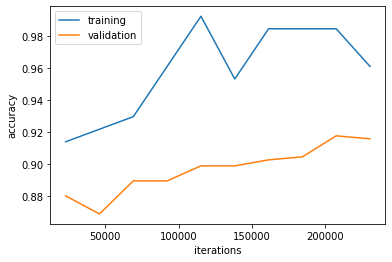

In [20]:
plt.figure()
plt.plot(df_train["seen"], df_train["acc_train"], label="training")
plt.plot(df_train["seen"], df_train["acc_val"], label="validation")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.show()

## Testing with Test Dataset

In [26]:
dl_test = DataLoader(
    ds_test,
    shuffle=False,
    batch_size=batch_size,
    drop_last=False,
)

predictions = []

with torch.no_grad():
    for (x, y) in tqdm(dl_test):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        # To-Do: Optimize Prediction & Accuracy?
        predictions.append(output.cpu().numpy())
    # Compute Validation Accuracy
    preds = np.argmax(np.concatenate(predictions, axis=0), axis=1)
    y = np.concatenate([item[1].numpy() for item in ds_test])
    acc_test = np.sum(preds == y) / len(preds)
    print(f'Test Acc: {acc_test}')

100%|██████████| 4/4 [02:32<00:00, 38.08s/it]


Test Acc: 0.9287169042769857


## Visualize Unmatched Result In Image

p.s. Use the last validation set

In [21]:
# Initialize transform proceduce for visualizing images
transforms_val_for_viz = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(128),
        transforms.CenterCrop(128),
    ]
)

# Initialize dataset for visualization
ds_val_for_viz = GreenFingerDataset(
    path_val,
    label_dict,
    transforms=transforms_val_for_viz
)
print("ds_val_for_viz", len(ds_val))

ds_val_for_viz 535


In [22]:
# Filter image's indices where preds != y (unmatched items' indices)
debug_idxs = np.where(preds != y)
debug_idxs

(array([ 13,  20,  25,  46,  49,  55,  57,  63,  73,  83,  85,  88, 118,
        133, 143, 144, 145, 148, 151, 153, 163, 166, 176, 183, 186, 194,
        201, 287, 289, 295, 308, 323, 363, 367, 372, 381, 397, 399, 400,
        407, 418, 426, 447, 505, 523]),)

In [23]:
# Filter ds_val_for_viz dataframe with unmatched items
debug_df = ds_val_for_viz.df.filter(items=debug_idxs[0], axis=0)
debug_df

,cat,image_path
13,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
20,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
25,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
46,Asplenium_nidus,/content/gdrive/MyDrive/Colab Notebooks/Final_...
49,Asplenium_nidus,/content/gdrive/MyDrive/Colab Notebooks/Final_...
55,Asplenium_nidus,/content/gdrive/MyDrive/Colab Notebooks/Final_...
57,Asplenium_nidus,/content/gdrive/MyDrive/Colab Notebooks/Final_...
63,Asplenium_nidus,/content/gdrive/MyDrive/Colab Notebooks/Final_...
73,Asplenium_nidus,/content/gdrive/MyDrive/Colab Notebooks/Final_...
83,Calathea_orbifolia,/content/gdrive/MyDrive/Colab Notebooks/Final_...


In [24]:
# Filter preds array with unmatched items
debug_preds = preds[debug_idxs]
debug_preds

array([19,  7,  9, 10, 11,  0, 11, 17, 18,  9,  6,  6, 19,  3, 17, 15, 17,
       10, 19,  9, 14, 14, 14, 14,  7,  7,  7, 18, 19, 13, 18,  6,  9, 19,
        8,  0, 10,  3,  3,  4,  4,  8, 14,  7,  7])

In [25]:
# Visualize unmatched items

fig = plt.figure()
fig.set_size_inches(30, 150)
for i in range(len(debug_df)):
  img_src, cat = debug_df.iloc[i][["image_path", "cat"]]
  img = Image.open(img_src)
  pred = debug_preds[i]
  pred = list(label_dict.keys())[list(label_dict.values()).index(pred)]
  plt.subplot(16, 5, i+1)
  plt.imshow(img)
  plt.title(f'P: {pred} \n vs\n T: {cat}')
  plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

## Load a model from cpu which was trained on gpu

Reference: https://pytorch.org/tutorials/recipes/recipes/save_load_across_devices.html#save-on-gpu-load-on-cpu

In [ ]:
# Specify which file would like to retrieve
log_file_path = ''

In [ ]:
"""
When loading a model on a CPU that was trained with a GPU, 
pass torch.device('cpu') to the map_location argument in the torch.load() function.
"""
model.load_state_dict(
    torch.load(
        log_file_path
        ),
        map_location="cpu",
)

model.to(device)
model.eval()

with torch.no_grad():
    for (x, y) in tqdm(dl_val):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        # To-Do: Optimize Prediction & Accuracy
        predictions.append(output.cpu().numpy())
    # Compute Validation Accuracy
    preds = np.argmax(np.concatenate(predictions, axis=0), axis=1)
    y = np.concatenate([item[1].numpy() for item in ds_val])
    acc_val = np.sum(preds == y) / len(preds)